In [1]:
import time
import os
import json
import string 
import re
from datetime import datetime

import random
import scipy
import numpy as np
from scipy.special import softmax

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, f1_score, classification_report, cohen_kappa_score, matthews_corrcoef, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data

import transformers
from transformers import AutoTokenizer, AutoModel
import evaluate

from tqdm.notebook import tqdm

tqdm.pandas()
sns.set_theme()

In [2]:
device = "cuda:0"

# Part 0: Data Loading and Analysis
I begin by loading the necessary data and performing some basic analysis on the data to familarise myself with it.

In [3]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yoyo1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yoyo1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yoyo1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
train_stances = pd.read_csv("./dataset/train_stances.csv")
train_bodies = pd.read_csv("./dataset/train_bodies.csv")

test_stances = pd.read_csv("./dataset/competition_test_stances.csv")
test_bodies = pd.read_csv("./dataset/competition_test_bodies.csv")

In [5]:
train_stances

,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated
4,Spider burrowed through tourist's stomach and ...,1923,disagree
...,...,...,...
49967,Urgent: The Leader of ISIL 'Abu Bakr al-Baghda...,1681,unrelated
49968,Brian Williams slams social media for speculat...,2419,unrelated
49969,Mexico Says Missing Students Not Found In Firs...,1156,agree
49970,US Lawmaker: Ten ISIS Fighters Have Been Appre...,1012,discuss


In [6]:
train_stances.nunique()

Headline    1648
Body ID     1683
Stance         4
dtype: int64

In [7]:
train_bodies

,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...
...,...,...
1678,2528,Intelligence agencies hunting for identity of ...
1679,2529,"While Daleks ""know no fear"" and ""must not fear..."
1680,2530,More than 200 schoolgirls were kidnapped in Ap...
1681,2531,A Guantanamo Bay prisoner released last year a...


In [8]:
train_bodies.nunique()

Body ID        1683
articleBody    1669
dtype: int64

<AxesSubplot: >

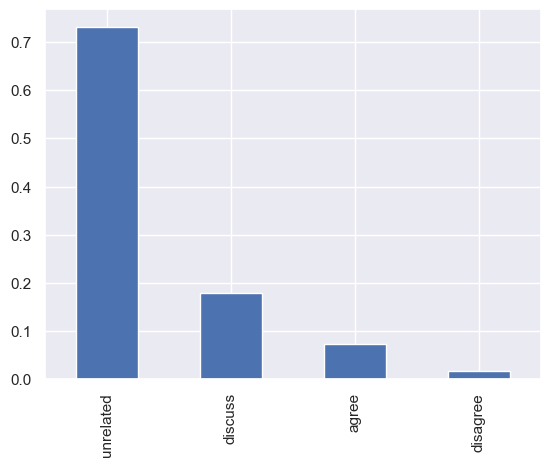

In [9]:
train_stances["Stance"].value_counts(normalize=True).plot(kind="bar")

In [10]:
train_stances["Stance"].mask(lambda row: row.eq("unrelated")).value_counts(normalize=True)

discuss     0.663514
agree       0.273926
disagree    0.062561
Name: Stance, dtype: float64

It's clear that there is a large overlap in the Headline and Body ID counts. For the first task we have an approximate 3:1 split for unrelated/related which is quite imbalanced but this gets substantially worse for the second task as once the unrelated is excluded we have an approximate 11:5:1 split for discuss/agree/disagree which is heavily imbalanced. 

It's also imperative to look at the lengths of sequences, especially for the transformer tasks. While this isn't a true count of their lengths (since the transformers will token them with WordPiece etc.) this will be useful to get a general feel for it.

In [11]:
train_stances["Headline"].apply(len).describe()

count    49972.000000
mean        69.356860
std         24.825253
min          9.000000
25%         54.000000
50%         65.000000
75%         79.000000
max        225.000000
Name: Headline, dtype: float64

In [12]:
train_bodies["articleBody"].apply(len).describe()

count     1683.000000
mean      2223.292929
std       1809.834941
min         38.000000
25%       1179.500000
50%       1822.000000
75%       2743.500000
max      27840.000000
Name: articleBody, dtype: float64

It is immediately clear that care will need to be taken to ensure we get a good balance of headline and body for classification

<AxesSubplot: >

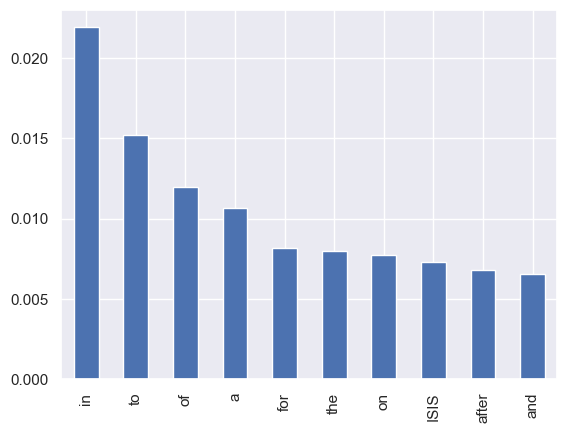

In [13]:
# Reference: https://stackoverflow.com/a/46786277
train_stances[train_stances["Stance"] == "agree"]["Headline"].str.split().explode().value_counts(normalize=True)[:10].plot(kind="bar")

<AxesSubplot: >

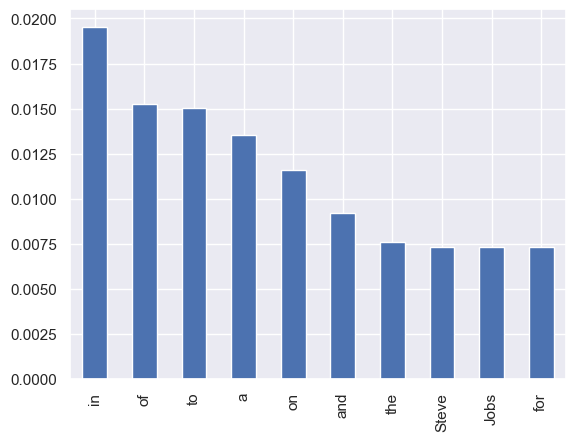

In [14]:
train_stances[train_stances["Stance"] == "disagree"]["Headline"].str.split().explode().value_counts(normalize=True)[:10].plot(kind="bar")

In [15]:
## TODO: EXTEND

In [16]:
train_stances.loc[train_stances["Headline"].isin(test_stances["Headline"])]

,Headline,Body ID,Stance
173,Cheese addiction breaks Kim Jong-un's ankles,2210,unrelated
1415,WSJ: Apple cut watch health features due to er...,1917,discuss
1418,Cheese blamed for North Korean leader Kim Jong...,1689,unrelated
1479,Cheese blamed for North Korean leader Kim Jong...,186,unrelated
1503,Cheese addiction breaks Kim Jong-un's ankles,2329,unrelated
...,...,...,...
48270,Apple was forced to nix key health features fr...,407,discuss
48852,Cheese blamed for North Korean leader Kim Jong...,2042,unrelated
49279,Cheese addiction breaks Kim Jong-un's ankles,1854,discuss
49349,Cheese blamed for North Korean leader Kim Jong...,2344,unrelated


In [17]:
train_bodies.loc[train_bodies["articleBody"].isin(test_bodies["articleBody"])]

,Body ID,articleBody
259,407,The health-focused smartwatch that Apple initi...
337,521,Apple apparently wanted its smartwatches to fo...
730,1095,North Korea leader Kim Jong-un is so fat from ...
800,1201,Citigroup Jim Suva on Apple Watch:\r\n\r\nWe e...
945,1415,Jim Suva with Citigroup this evening weighs in...
1028,1542,Apple Watch will take approximately two hours ...
1159,1750,In designing its first wearable device in the ...
1182,1788,Before Apple unveiled the Apple Watch last Sep...
1231,1854,No craving can be more important than your hea...
1275,1917,Apple originally planned for the Apple Watch t...


Interestingly there is actually overlap between the headlines and bodies between the train set and the test set. This makes splitting the data into disjoint sets difficult, following existing repos (TODO: CITE) I will split so that there is no overlap between 

## Data Splitting

In [18]:
train_and_val_df = train_stances.merge(train_bodies, on="Body ID")
train_and_val_df["Related"] = (train_and_val_df["Stance"] != "unrelated").astype(int)

In [19]:
test_df = test_stances.merge(test_bodies, on="Body ID")
test_df["Related"] = (test_df["Stance"] != "unrelated").astype(int)

In [20]:
# Split the train and validation sets by ensuring there is no overlap between the bodies
def split_train_val(df, ratio):
    val_count = int(ratio * df["Body ID"].nunique())
    all_ids = list(df["Body ID"].unique())
    val_body_ids = random.sample(all_ids, val_count)
    train_body_ids = set(all_ids) - set(val_body_ids)
    
    assert len(set(val_body_ids) & train_body_ids) == 0
    
    val_df = df.loc[df["Body ID"].isin(val_body_ids)]
    train_df = df.loc[df["Body ID"].isin(train_body_ids)]
    
    return val_df, train_df

In [21]:
val_split_ratio = 0.2
val_df, train_df = split_train_val(train_and_val_df, val_split_ratio)

In [22]:
val_df

,Headline,Body ID,Stance,articleBody,Related
124,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated,(Reuters) - A Canadian soldier was shot at the...,0
125,ISLAMIC STATE BEHEADS MISSING AMERICAN JOURNAL...,1034,unrelated,(Reuters) - A Canadian soldier was shot at the...,0
126,Elderly Woman Arrested for Kidnapping Neighbor...,1034,unrelated,(Reuters) - A Canadian soldier was shot at the...,0
127,Kim Jong-Un 'bans the name Kim Jong-un',1034,unrelated,(Reuters) - A Canadian soldier was shot at the...,0
128,Two blokes dared to eat 20-year-old burger for...,1034,unrelated,(Reuters) - A Canadian soldier was shot at the...,0
...,...,...,...,...,...
49955,Heartbroken girl spends week in KFC after gett...,159,discuss,A Chinese woman spent an entire week inside a ...,1
49956,"Comfort eating? Chinese woman, 26, spends an e...",159,discuss,A Chinese woman spent an entire week inside a ...,1
49958,"Rodney Constantine, Newfoundland Suspect, Keep...",828,agree,A man wanted by police turned himself in to th...,1
49959,A Wanted Man Responded To A Police Facebook Po...,828,agree,A man wanted by police turned himself in to th...,1


In [23]:
train_df

,Headline,Body ID,Stance,articleBody,Related
0,Police find mass graves with at least '15 bodi...,712,unrelated,Danny Boyle is directing the untitled film\r\n...,0
1,Seth Rogen to Play Apple’s Steve Wozniak,712,discuss,Danny Boyle is directing the untitled film\r\n...,1
2,Mexico police find mass grave near site 43 stu...,712,unrelated,Danny Boyle is directing the untitled film\r\n...,0
3,Mexico Says Missing Students Not Found In Firs...,712,unrelated,Danny Boyle is directing the untitled film\r\n...,0
4,New iOS 8 bug can delete all of your iCloud do...,712,unrelated,Danny Boyle is directing the untitled film\r\n...,0
...,...,...,...,...,...
49966,“Willie Nelson dead 2015” : Guitarist killed b...,553,agree,News of guitarist Willie Nelson’s death spread...,1
49967,Amazon Is Opening a Brick-and-Mortar Store in ...,464,agree,"Amazon, the cyber store that sells everything,...",1
49969,Fake BBC News website set up to carry Charlie ...,915,agree,A realistic-looking fake BBC News website has ...,1
49970,Apple was forced to nix key health features fr...,407,discuss,The health-focused smartwatch that Apple initi...,1


In [24]:
train_df["Body ID"].nunique()

1347

In [25]:
val_df["Body ID"].nunique()

336

In [26]:
test_df["Body ID"].nunique()

904

In [27]:
def prepare_df(df):
    df = df.drop("Body ID", axis=1)
    df = df.reset_index()
    df = df.drop("index", axis=1)
    # df["Related"] = df["Stance"] != "unrelated"
    return df

In [28]:
clean_train_df = prepare_df(train_df)
clean_val_df = prepare_df(val_df)
clean_test_df = prepare_df(test_df)

<AxesSubplot: >

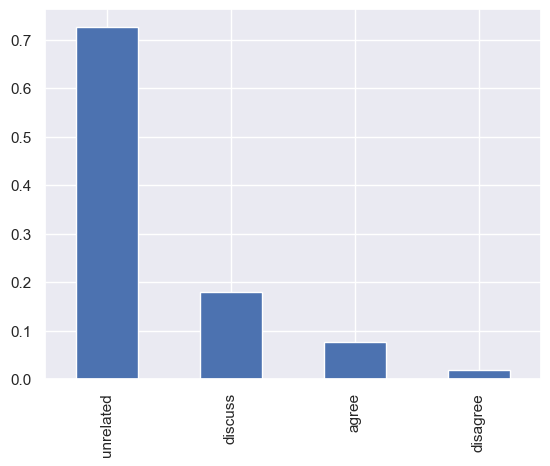

In [29]:
clean_train_df["Stance"].value_counts(normalize=True).plot(kind="bar")

<AxesSubplot: >

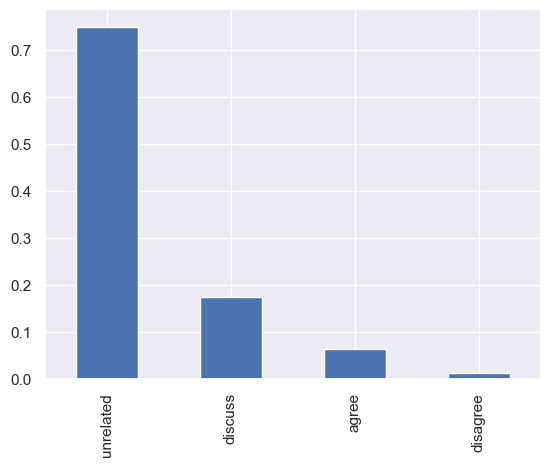

In [30]:
clean_val_df["Stance"].value_counts(normalize=True).plot(kind="bar")

<AxesSubplot: >

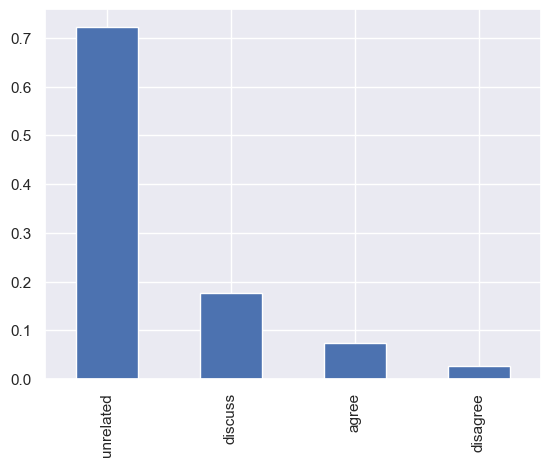

In [31]:
clean_test_df["Stance"].value_counts(normalize=True).plot(kind="bar")

The class distribution between the train and validation (and test although we wouldn't be able to control this anyway) are pretty similar which is good so we don't need to resample to ensure we have similar distributions.

# Part 1: Feature Extraction

## Part 1.a: TF-IDF Features

### Data Cleaning and Tokenisation
Now we have the data, need to clean the data and extract the TF-IDF features. Basic things to consider doing:
* Remove punctuation
* Remove URLs
* Remove HTML
* Remove numbers
* Remove emojis
* Convert to lowercase

And we should also:
* Tokenise
* Remove stopwords
* Lemmatisation or Stemming

In [32]:
# Keep clean copies as we will process differently for Transformers
train_df = clean_train_df.copy(deep=True)
val_df = clean_val_df.copy(deep=True)
test_df = clean_test_df.copy(deep=True)

In [32]:
# TODO: CITE Most of this from the first practical
additional_specials = ["—", "”", "“", "’", "‘"]

def remove_excess_whitespace(text):
    text = text.replace("\n", " ")
    text = text.replace("\t", " ")
    text = text.replace("\r", " ")
    text = text.strip()
    return text

def remove_punctuation(text):
    punc = str.maketrans('', '', string.punctuation)
    text = text.translate(punc)
    
    for special in additional_specials:
        text = text.replace(special, "")
    
    return text

def remove_urls(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub('', text)

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub('', text)

def remove_numbers(text):
    numbers = re.compile(r'\d+')
    return numbers.sub('', text)

def remove_emojis(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', text)

def apply_cleaning(text, excess=True, punc=True, urls=True, html=True, numbers=True, emojis=True, lower=True):
    if excess:
        text = " ".join(text.split())
        
    if punc:
        text = remove_punctuation(text)
    
    if urls:
        text = remove_urls(text)
    
    if html:
        text = remove_html(text)
    
    if numbers:
        text = remove_numbers(text)
        
    if emojis:
        text = remove_emojis(text)
        
    if lower:
        text = text.lower()
    
    return text

In [33]:
eng_stopwords = set(stopwords.words("english"))
lemmatiser = WordNetLemmatizer()
stemmer = PorterStemmer()

def lemmatise(text):
    tokens = word_tokenize(text)
    return " ".join([lemmatiser.lemmatize(x) for x in tokens])

def stematise(text):
    tokens = word_tokenize(text)
    return " ".join([stemmer.stem(x) for x in tokens])

def apply_tokeniser(text, stops=True, sl="lemmatise"):
    word_processor = None
    
    if sl == "lemmatise":
        word_processor = lemmatiser.lemmatize
    elif sl == "stematise":
        word_processor = stemmer.stem
    elif sl == "identity":
        word_processor = lambda x: x
    else:
        assert False, "Invalid"
    
    tokens = word_tokenize(text)
    filtered_tokens = []
    
    if stops:
        for token in tokens:
            if token not in eng_stopwords:
                filtered_tokens.append(token)
    else:
        filtered_tokens = tokens
        
    return " ".join([word_processor(token) for token in filtered_tokens])

In [35]:
config_remove_excess_whitespace = True
config_remove_punctuation = True
config_remove_urls = True
config_remove_html = True
config_remove_numbers = True
config_remove_emojis = True
config_convert_to_lowercase = True
config_stem_or_lemm = ["lemmatise", "stematise", "identity"][0]
config_remove_stopwords = True

In [36]:
def process_text(text):
    text = apply_cleaning(
        text, 
        excess=config_remove_excess_whitespace, 
        punc=config_remove_punctuation, 
        urls=config_remove_urls, 
        html=config_remove_html, 
        numbers=config_remove_numbers, 
        emojis=config_remove_emojis, 
        lower=config_convert_to_lowercase
    )
    
    text = apply_tokeniser(text, stops=config_remove_stopwords, sl=config_stem_or_lemm)
    return text

In [37]:
test_text = clean_train_df.iloc[812]["articleBody"]
print("Unprocessed:")
print(test_text)
print()
test_processed = process_text(test_text)
print("Processed:")
print(test_processed)

Unprocessed:
Led Zeppelin fans will be disappointed to learn that there’s no reunion tour and a story that appeared in the Daily Mirror suggesting that Robert Plant ripped up an $800 contract for such a gig is false, according to the Guardian.

The reported tour was supposedly financed by Virgin founder Richard Branson, who wanted to turn one of his Virgin planes into a new iteration of “The Starship,” the jet​ the band used to tour in the 1970s. The group was to play 35 dates in three locales-- London, Berlin and New Jersey.

Guitarist Jimmy Page and bassist John Paul Jones had signed on. And the late drummer John Bonham’s son Jason was to play drums for the band. “It was a no-brainer for them but Robert asked for 48 hours to think about it,” a source told the Daily Mirror. “When he said no and ripped up the paperwork he had been given, there was an enormous sense of shock. There is no way they can go ahead without him.”

Turns out, the entire tale is “rubbish,” said Plant’s publicist

In [38]:
train_df

,Headline,Stance,articleBody,Related
0,Police find mass graves with at least '15 bodi...,unrelated,Danny Boyle is directing the untitled film\r\n...,False
1,Seth Rogen to Play Apple’s Steve Wozniak,discuss,Danny Boyle is directing the untitled film\r\n...,True
2,Mexico police find mass grave near site 43 stu...,unrelated,Danny Boyle is directing the untitled film\r\n...,False
3,Mexico Says Missing Students Not Found In Firs...,unrelated,Danny Boyle is directing the untitled film\r\n...,False
4,New iOS 8 bug can delete all of your iCloud do...,unrelated,Danny Boyle is directing the untitled film\r\n...,False
...,...,...,...,...
40528,"NASA: Planetary Alignment On Jan 4, 2015 Will ...",discuss,via Daily Buzz Live\r\n\r\nStrange natural occ...,True
40529,“Willie Nelson dead 2015” : Guitarist killed b...,agree,News of guitarist Willie Nelson’s death spread...,True
40530,Elon University has not banned the term ‘fresh...,agree,"ELON, N.C. – A recent rumor claims that Elon U...",True
40531,Fake BBC News website set up to carry Charlie ...,agree,A realistic-looking fake BBC News website has ...,True


In [39]:
train_df["Processed Headline"] = train_df["Headline"].progress_apply(process_text)
train_df["Processed Body"] = train_df["articleBody"].progress_apply(process_text)

  0%|          | 0/40533 [00:00<?, ?it/s]

  0%|          | 0/40533 [00:00<?, ?it/s]

In [40]:
train_df

,Headline,Stance,articleBody,Related,Processed Headline,Processed Body
0,Police find mass graves with at least '15 bodi...,unrelated,Danny Boyle is directing the untitled film\r\n...,False,police find mass graf least body near mexico t...,danny boyle directing untitled film seth rogen...
1,Seth Rogen to Play Apple’s Steve Wozniak,discuss,Danny Boyle is directing the untitled film\r\n...,True,seth rogen play apple steve wozniak,danny boyle directing untitled film seth rogen...
2,Mexico police find mass grave near site 43 stu...,unrelated,Danny Boyle is directing the untitled film\r\n...,False,mexico police find mass grave near site studen...,danny boyle directing untitled film seth rogen...
3,Mexico Says Missing Students Not Found In Firs...,unrelated,Danny Boyle is directing the untitled film\r\n...,False,mexico say missing student found first mass graf,danny boyle directing untitled film seth rogen...
4,New iOS 8 bug can delete all of your iCloud do...,unrelated,Danny Boyle is directing the untitled film\r\n...,False,new io bug delete icloud document,danny boyle directing untitled film seth rogen...
...,...,...,...,...,...,...
40528,"NASA: Planetary Alignment On Jan 4, 2015 Will ...",discuss,via Daily Buzz Live\r\n\r\nStrange natural occ...,True,nasa planetary alignment jan decrease gravity ...,via daily buzz live strange natural occurrence...
40529,“Willie Nelson dead 2015” : Guitarist killed b...,agree,News of guitarist Willie Nelson’s death spread...,True,willie nelson dead guitarist killed internet d...,news guitarist willie nelson death spread quic...
40530,Elon University has not banned the term ‘fresh...,agree,"ELON, N.C. – A recent rumor claims that Elon U...",True,elon university banned term freshman despite r...,elon nc – recent rumor claim elon university b...
40531,Fake BBC News website set up to carry Charlie ...,agree,A realistic-looking fake BBC News website has ...,True,fake bbc news website set carry charlie hebdo ...,realisticlooking fake bbc news website set car...


In [41]:
val_df["Processed Headline"] = val_df["Headline"].progress_apply(process_text)
val_df["Processed Body"] = val_df["articleBody"].progress_apply(process_text)

  0%|          | 0/9439 [00:00<?, ?it/s]

  0%|          | 0/9439 [00:00<?, ?it/s]

In [42]:
val_df

,Headline,Stance,articleBody,Related,Processed Headline,Processed Body
0,'Nasa Confirms Earth Will Experience 6 Days of...,agree,Thousands of people have been duped by a fake ...,True,nasa confirms earth experience day total darkn...,thousand people duped fake news story claiming...
1,’6 Days Darkness in December 2014′ 100% Fake; ...,agree,Thousands of people have been duped by a fake ...,True,day darkness december ′ fake nasa confirmed da...,thousand people duped fake news story claiming...
2,Woman detained in Lebanon is not al-Baghdadi's...,agree,An Iraqi official denied that a woman detained...,True,woman detained lebanon albaghdadis wife iraq say,iraqi official denied woman detained lebanon w...
3,Lebanon 'holding IS leader's daughter and ex-w...,discuss,An Iraqi official denied that a woman detained...,True,lebanon holding leader daughter exwife,iraqi official denied woman detained lebanon w...
4,Lebanon detains wife and son of Al-Baghdadi,disagree,An Iraqi official denied that a woman detained...,True,lebanon detains wife son albaghdadi,iraqi official denied woman detained lebanon w...
...,...,...,...,...,...,...
9434,Axl Rose NOT Dead: Fake MSNBC Death Hoax Goes ...,agree,Axl Rose is NOT dead. He’s the victim of a new...,True,axl rose dead fake msnbc death hoax go viral f...,axl rose dead he victim new death hoax designe...
9435,"BMO forecasts 19M Apple Watch sales in 2015, w...",discuss,Momentum for the Apple Watch will likely take ...,True,bmo forecast apple watch sale half selling hol...,momentum apple watch likely take short time bu...
9436,Chinese parents try to SELL their son to pay f...,agree,A Chinese couple who can't afford live-saving ...,True,chinese parent try sell son pay medical treatm...,chinese couple cant afford livesaving medical ...
9437,Amazon Is Opening a Brick-and-Mortar Store in ...,agree,"Amazon, the cyber store that sells everything,...",True,amazon opening brickandmortar store manhattan,amazon cyber store sell everything plan open f...


In [43]:
test_df["Processed Headline"] = test_df["Headline"].progress_apply(process_text)
test_df["Processed Body"] = test_df["articleBody"].progress_apply(process_text)

  0%|          | 0/25413 [00:00<?, ?it/s]

  0%|          | 0/25413 [00:00<?, ?it/s]

In [44]:
test_df

,Headline,Stance,articleBody,Related,Processed Headline,Processed Body
0,Ferguson riots: Pregnant woman loses eye after...,unrelated,A RESPECTED senior French police officer inves...,False,ferguson riot pregnant woman loses eye cop fir...,respected senior french police officer investi...
1,Apple Stores to install safes to secure gold A...,unrelated,A RESPECTED senior French police officer inves...,False,apple store install safe secure gold apple watch,respected senior french police officer investi...
2,Pregnant woman loses eye after police shoot be...,unrelated,A RESPECTED senior French police officer inves...,False,pregnant woman loses eye police shoot bean bag,respected senior french police officer investi...
3,We just found out the #Ferguson Protester who ...,unrelated,A RESPECTED senior French police officer inves...,False,found ferguson protester claim shot eye rubber...,respected senior french police officer investi...
4,Police Chief In Charge of Paris Attacks Commit...,discuss,A RESPECTED senior French police officer inves...,True,police chief charge paris attack commits suicide,respected senior french police officer investi...
...,...,...,...,...,...,...
25408,A Sign That Obamacare Exchanges Are Failing,disagree,Remember how much Republicans wanted to repeal...,True,sign obamacare exchange failing,remember much republican wanted repeal obamaca...
25409,Republicans call Obamacare a 'failure.' These ...,agree,Remember how much Republicans wanted to repeal...,True,republican call obamacare failure chart show c...,remember much republican wanted repeal obamaca...
25410,CBO’s Alternate Facts Show Obamacare is Unsust...,disagree,Remember how much Republicans wanted to repeal...,True,cbos alternate fact show obamacare unsustainable,remember much republican wanted repeal obamaca...
25411,Why Obamacare failed,disagree,Remember how much Republicans wanted to repeal...,True,obamacare failed,remember much republican wanted repeal obamaca...


In [45]:
tfidf_train_df = train_df.copy(deep=True)
tfidf_val_df = val_df.copy(deep=True)
tfidf_test_df = test_df.copy(deep=True)

In [46]:
del train_df
del val_df
del test_df

### Feature Extraction

In [47]:
train_text = (tfidf_train_df["Processed Headline"].values + tfidf_train_df["Processed Body"].values).astype("U")

In [48]:
train_text_tfidf = TfidfVectorizer(decode_error="ignore", lowercase=True, min_df=2)
train_text_tfidf.fit(train_text)

TfidfVectorizer(decode_error='ignore', min_df=2)

In [49]:
train_headline_features = train_text_tfidf.transform(tfidf_train_df["Processed Headline"].values.astype("U"))
train_body_features = train_text_tfidf.transform(tfidf_train_df["Processed Body"].values.astype("U"))

In [50]:
print(train_headline_features.shape)
print(train_body_features.shape)

(40533, 26825)
(40533, 26825)


In [51]:
type(train_headline_features)

scipy.sparse._csr.csr_matrix

In [52]:
tfidf_train_input_features = scipy.sparse.hstack((train_headline_features, train_body_features))

In [53]:
tfidf_train_input_features.shape

(40533, 53650)

In [54]:
val_headline_features = train_text_tfidf.transform(tfidf_val_df["Processed Headline"].values.astype("U"))
val_body_features = train_text_tfidf.transform(tfidf_val_df["Processed Body"].values.astype("U"))
tfidf_val_input_features = scipy.sparse.hstack((val_headline_features, val_body_features))
tfidf_val_input_features.shape

(9439, 53650)

In [55]:
test_headline_features = train_text_tfidf.transform(tfidf_test_df["Processed Headline"].values.astype("U"))
test_body_features = train_text_tfidf.transform(tfidf_test_df["Processed Body"].values.astype("U"))
tfidf_test_input_features = scipy.sparse.hstack((test_headline_features, test_body_features))
tfidf_test_input_features.shape

(25413, 53650)

In [56]:
del train_headline_features
del train_body_features
del val_headline_features
del val_body_features
del test_headline_features
del test_body_features

### Dataset Preparation

In [57]:
coo = tfidf_train_input_features.tocoo()
tfidf_train_sparse_tensor = torch.sparse.FloatTensor(torch.LongTensor(np.vstack((coo.row, coo.col))), torch.FloatTensor(coo.data), torch.Size(coo.shape))
tfidf_train_labels_tensor = torch.FloatTensor(tfidf_train_df["Related"].values.astype(int)).unsqueeze(1)

In [58]:
coo = tfidf_val_input_features.tocoo()
tfidf_val_sparse_tensor = torch.sparse.FloatTensor(torch.LongTensor(np.vstack((coo.row, coo.col))), torch.FloatTensor(coo.data), torch.Size(coo.shape))
tfidf_val_labels_tensor = torch.FloatTensor(tfidf_val_df["Related"].values.astype(int)).unsqueeze(1)

In [59]:
coo = tfidf_test_input_features.tocoo()
tfidf_test_sparse_tensor = torch.sparse.FloatTensor(torch.LongTensor(np.vstack((coo.row, coo.col))), torch.FloatTensor(coo.data), torch.Size(coo.shape))
tfidf_test_labels_tensor = torch.FloatTensor(tfidf_test_df["Related"].values.astype(int)).unsqueeze(1)

## Part 1.b: Transformer Features

In [34]:
# https://huggingface.co/docs/transformers/model_doc/auto
selected_transformer_name = "distilroberta-base" # "bert-base-uncased"
tokeniser = AutoTokenizer.from_pretrained(selected_transformer_name)
max_input_length = tokeniser.max_model_input_sizes[selected_transformer_name]

### Data Cleaning
Uses the same functions as in Part 1.a but we don't need to do such deep cleaning as the transformer is more flexible and uses a better tokenisation system

In [35]:
# Keep clean copies as we will process differently for Transformers
train_df = clean_train_df.copy(deep=True)
val_df = clean_val_df.copy(deep=True)
test_df = clean_test_df.copy(deep=True)

In [36]:
config_remove_excess_whitespace = True
config_remove_punctuation = False
config_remove_urls = True
config_remove_html = True
config_remove_numbers = False
config_remove_emojis = True
config_convert_to_lowercase = False

In [37]:
def process_text_no_tokeniser(text):
    text = apply_cleaning(
        text, 
        excess=config_remove_excess_whitespace, 
        punc=config_remove_punctuation, 
        urls=config_remove_urls, 
        html=config_remove_html, 
        numbers=config_remove_numbers, 
        emojis=config_remove_emojis, 
        lower=config_convert_to_lowercase
    )
    
    return text

In [38]:
test_text = train_df.iloc[812]["articleBody"]
print("Unprocessed:")
print(test_text)
print()
test_processed = process_text_no_tokeniser(test_text)
print("Processed:")
print(test_processed)

Unprocessed:
The Islamic State released a video of its jihadists beheading American journalist James Wright Foley in Syria. The video is almost five minutes long and includes threats against President Barack Obama and the United States.
In the video, which was temporarily available on YouTube but has since been removed, the terrorists remind the audience Obama authorized military action against IS and replayed Obama’s press conference when he announced the airstrikes. To them the declaration is a “slippery slope towards a new war front against Muslims.”
Foley then appears on his knees in an orange jumpsuit. He relays a message that the US government is his true killer. He addresses his family as well. The message is choppy, which gives the appearance that he is reading off cards placed in front of the camera.
His executioner speaks with what appears to be a British accent, saying many Muslims worldwide accepted IS and a war against IS is, in essence, a war against Muslims. The UK has b

In [39]:
train_df

,Headline,Stance,articleBody,Related
0,Police find mass graves with at least '15 bodi...,unrelated,Danny Boyle is directing the untitled film\r\n...,0
1,Seth Rogen to Play Apple’s Steve Wozniak,discuss,Danny Boyle is directing the untitled film\r\n...,1
2,Mexico police find mass grave near site 43 stu...,unrelated,Danny Boyle is directing the untitled film\r\n...,0
3,Mexico Says Missing Students Not Found In Firs...,unrelated,Danny Boyle is directing the untitled film\r\n...,0
4,New iOS 8 bug can delete all of your iCloud do...,unrelated,Danny Boyle is directing the untitled film\r\n...,0
...,...,...,...,...
39945,“Willie Nelson dead 2015” : Guitarist killed b...,agree,News of guitarist Willie Nelson’s death spread...,1
39946,Amazon Is Opening a Brick-and-Mortar Store in ...,agree,"Amazon, the cyber store that sells everything,...",1
39947,Fake BBC News website set up to carry Charlie ...,agree,A realistic-looking fake BBC News website has ...,1
39948,Apple was forced to nix key health features fr...,discuss,The health-focused smartwatch that Apple initi...,1


In [40]:
train_df["Processed Headline"] = train_df["Headline"].progress_apply(process_text_no_tokeniser)
train_df["Processed Body"] = train_df["articleBody"].progress_apply(process_text_no_tokeniser)

  0%|          | 0/39950 [00:00<?, ?it/s]

  0%|          | 0/39950 [00:00<?, ?it/s]

In [41]:
train_df

,Headline,Stance,articleBody,Related,Processed Headline,Processed Body
0,Police find mass graves with at least '15 bodi...,unrelated,Danny Boyle is directing the untitled film\r\n...,0,Police find mass graves with at least '15 bodi...,Danny Boyle is directing the untitled film Set...
1,Seth Rogen to Play Apple’s Steve Wozniak,discuss,Danny Boyle is directing the untitled film\r\n...,1,Seth Rogen to Play Apple’s Steve Wozniak,Danny Boyle is directing the untitled film Set...
2,Mexico police find mass grave near site 43 stu...,unrelated,Danny Boyle is directing the untitled film\r\n...,0,Mexico police find mass grave near site 43 stu...,Danny Boyle is directing the untitled film Set...
3,Mexico Says Missing Students Not Found In Firs...,unrelated,Danny Boyle is directing the untitled film\r\n...,0,Mexico Says Missing Students Not Found In Firs...,Danny Boyle is directing the untitled film Set...
4,New iOS 8 bug can delete all of your iCloud do...,unrelated,Danny Boyle is directing the untitled film\r\n...,0,New iOS 8 bug can delete all of your iCloud do...,Danny Boyle is directing the untitled film Set...
...,...,...,...,...,...,...
39945,“Willie Nelson dead 2015” : Guitarist killed b...,agree,News of guitarist Willie Nelson’s death spread...,1,“Willie Nelson dead 2015” : Guitarist killed b...,News of guitarist Willie Nelson’s death spread...
39946,Amazon Is Opening a Brick-and-Mortar Store in ...,agree,"Amazon, the cyber store that sells everything,...",1,Amazon Is Opening a Brick-and-Mortar Store in ...,"Amazon, the cyber store that sells everything,..."
39947,Fake BBC News website set up to carry Charlie ...,agree,A realistic-looking fake BBC News website has ...,1,Fake BBC News website set up to carry Charlie ...,A realistic-looking fake BBC News website has ...
39948,Apple was forced to nix key health features fr...,discuss,The health-focused smartwatch that Apple initi...,1,Apple was forced to nix key health features fr...,The health-focused smartwatch that Apple initi...


In [42]:
val_df["Processed Headline"] = val_df["Headline"].progress_apply(process_text_no_tokeniser)
val_df["Processed Body"] = val_df["articleBody"].progress_apply(process_text_no_tokeniser)

  0%|          | 0/10022 [00:00<?, ?it/s]

  0%|          | 0/10022 [00:00<?, ?it/s]

In [43]:
val_df

,Headline,Stance,articleBody,Related,Processed Headline,Processed Body
0,HBO and Apple in Talks for $15/Month Apple TV ...,unrelated,(Reuters) - A Canadian soldier was shot at the...,0,HBO and Apple in Talks for $15/Month Apple TV ...,(Reuters) - A Canadian soldier was shot at the...
1,ISLAMIC STATE BEHEADS MISSING AMERICAN JOURNAL...,unrelated,(Reuters) - A Canadian soldier was shot at the...,0,ISLAMIC STATE BEHEADS MISSING AMERICAN JOURNAL...,(Reuters) - A Canadian soldier was shot at the...
2,Elderly Woman Arrested for Kidnapping Neighbor...,unrelated,(Reuters) - A Canadian soldier was shot at the...,0,Elderly Woman Arrested for Kidnapping Neighbor...,(Reuters) - A Canadian soldier was shot at the...
3,Kim Jong-Un 'bans the name Kim Jong-un',unrelated,(Reuters) - A Canadian soldier was shot at the...,0,Kim Jong-Un 'bans the name Kim Jong-un',(Reuters) - A Canadian soldier was shot at the...
4,Two blokes dared to eat 20-year-old burger for...,unrelated,(Reuters) - A Canadian soldier was shot at the...,0,Two blokes dared to eat 20-year-old burger for...,(Reuters) - A Canadian soldier was shot at the...
...,...,...,...,...,...,...
10017,Heartbroken girl spends week in KFC after gett...,discuss,A Chinese woman spent an entire week inside a ...,1,Heartbroken girl spends week in KFC after gett...,A Chinese woman spent an entire week inside a ...
10018,"Comfort eating? Chinese woman, 26, spends an e...",discuss,A Chinese woman spent an entire week inside a ...,1,"Comfort eating? Chinese woman, 26, spends an e...",A Chinese woman spent an entire week inside a ...
10019,"Rodney Constantine, Newfoundland Suspect, Keep...",agree,A man wanted by police turned himself in to th...,1,"Rodney Constantine, Newfoundland Suspect, Keep...",A man wanted by police turned himself in to th...
10020,A Wanted Man Responded To A Police Facebook Po...,agree,A man wanted by police turned himself in to th...,1,A Wanted Man Responded To A Police Facebook Po...,A man wanted by police turned himself in to th...


In [44]:
test_df["Processed Headline"] = test_df["Headline"].progress_apply(process_text_no_tokeniser)
test_df["Processed Body"] = test_df["articleBody"].progress_apply(process_text_no_tokeniser)

  0%|          | 0/25413 [00:00<?, ?it/s]

  0%|          | 0/25413 [00:00<?, ?it/s]

In [45]:
test_df

,Headline,Stance,articleBody,Related,Processed Headline,Processed Body
0,Ferguson riots: Pregnant woman loses eye after...,unrelated,A RESPECTED senior French police officer inves...,0,Ferguson riots: Pregnant woman loses eye after...,A RESPECTED senior French police officer inves...
1,Apple Stores to install safes to secure gold A...,unrelated,A RESPECTED senior French police officer inves...,0,Apple Stores to install safes to secure gold A...,A RESPECTED senior French police officer inves...
2,Pregnant woman loses eye after police shoot be...,unrelated,A RESPECTED senior French police officer inves...,0,Pregnant woman loses eye after police shoot be...,A RESPECTED senior French police officer inves...
3,We just found out the #Ferguson Protester who ...,unrelated,A RESPECTED senior French police officer inves...,0,We just found out the #Ferguson Protester who ...,A RESPECTED senior French police officer inves...
4,Police Chief In Charge of Paris Attacks Commit...,discuss,A RESPECTED senior French police officer inves...,1,Police Chief In Charge of Paris Attacks Commit...,A RESPECTED senior French police officer inves...
...,...,...,...,...,...,...
25408,A Sign That Obamacare Exchanges Are Failing,disagree,Remember how much Republicans wanted to repeal...,1,A Sign That Obamacare Exchanges Are Failing,Remember how much Republicans wanted to repeal...
25409,Republicans call Obamacare a 'failure.' These ...,agree,Remember how much Republicans wanted to repeal...,1,Republicans call Obamacare a 'failure.' These ...,Remember how much Republicans wanted to repeal...
25410,CBO’s Alternate Facts Show Obamacare is Unsust...,disagree,Remember how much Republicans wanted to repeal...,1,CBO’s Alternate Facts Show Obamacare is Unsust...,Remember how much Republicans wanted to repeal...
25411,Why Obamacare failed,disagree,Remember how much Republicans wanted to repeal...,1,Why Obamacare failed,Remember how much Republicans wanted to repeal...


### Tokenisation

In [46]:
test_processed

"The Islamic State released a video of its jihadists beheading American journalist James Wright Foley in Syria. The video is almost five minutes long and includes threats against President Barack Obama and the United States. In the video, which was temporarily available on YouTube but has since been removed, the terrorists remind the audience Obama authorized military action against IS and replayed Obama’s press conference when he announced the airstrikes. To them the declaration is a “slippery slope towards a new war front against Muslims.” Foley then appears on his knees in an orange jumpsuit. He relays a message that the US government is his true killer. He addresses his family as well. The message is choppy, which gives the appearance that he is reading off cards placed in front of the camera. His executioner speaks with what appears to be a British accent, saying many Muslims worldwide accepted IS and a war against IS is, in essence, a war against Muslims. The UK has been one of t

In [47]:
test_processed_tokens = tokeniser.tokenize(test_processed)

In [48]:
print(test_processed_tokens)

['The', 'ĠIslamic', 'ĠState', 'Ġreleased', 'Ġa', 'Ġvideo', 'Ġof', 'Ġits', 'Ġjihadists', 'Ġbe', 'heading', 'ĠAmerican', 'Ġjournalist', 'ĠJames', 'ĠWright', 'ĠFoley', 'Ġin', 'ĠSyria', '.', 'ĠThe', 'Ġvideo', 'Ġis', 'Ġalmost', 'Ġfive', 'Ġminutes', 'Ġlong', 'Ġand', 'Ġincludes', 'Ġthreats', 'Ġagainst', 'ĠPresident', 'ĠBarack', 'ĠObama', 'Ġand', 'Ġthe', 'ĠUnited', 'ĠStates', '.', 'ĠIn', 'Ġthe', 'Ġvideo', ',', 'Ġwhich', 'Ġwas', 'Ġtemporarily', 'Ġavailable', 'Ġon', 'ĠYouTube', 'Ġbut', 'Ġhas', 'Ġsince', 'Ġbeen', 'Ġremoved', ',', 'Ġthe', 'Ġterrorists', 'Ġremind', 'Ġthe', 'Ġaudience', 'ĠObama', 'Ġauthorized', 'Ġmilitary', 'Ġaction', 'Ġagainst', 'ĠIS', 'Ġand', 'Ġre', 'played', 'ĠObama', 'âĢ', 'Ļ', 's', 'Ġpress', 'Ġconference', 'Ġwhen', 'Ġhe', 'Ġannounced', 'Ġthe', 'Ġairstrikes', '.', 'ĠTo', 'Ġthem', 'Ġthe', 'Ġdeclaration', 'Ġis', 'Ġa', 'ĠâĢ', 'ľ', 'sl', 'ippery', 'Ġslope', 'Ġtowards', 'Ġa', 'Ġnew', 'Ġwar', 'Ġfront', 'Ġagainst', 'ĠMuslims', '.', 'âĢ', 'Ŀ', 'ĠFoley', 'Ġthen', 'Ġappears', 'Ġon', 'Ġhis

In [49]:
test_processed_indexes = tokeniser.convert_tokens_to_ids(test_processed_tokens)

In [50]:
print(test_processed_indexes)

[133, 2715, 331, 703, 10, 569, 9, 63, 24504, 28, 29086, 470, 5226, 957, 5825, 20291, 11, 1854, 4, 20, 569, 16, 818, 292, 728, 251, 8, 1171, 3455, 136, 270, 4282, 1284, 8, 5, 315, 532, 4, 96, 5, 569, 6, 61, 21, 8059, 577, 15, 4037, 53, 34, 187, 57, 2928, 6, 5, 7263, 8736, 5, 2437, 1284, 8672, 831, 814, 136, 3703, 8, 769, 13089, 1284, 17, 27, 29, 1228, 1019, 77, 37, 585, 5, 21176, 4, 598, 106, 5, 9394, 16, 10, 44, 48, 9996, 44610, 24553, 1567, 10, 92, 997, 760, 136, 6299, 4, 17, 46, 20291, 172, 2092, 15, 39, 15145, 11, 41, 8978, 13855, 6439, 4, 91, 6258, 4113, 10, 1579, 14, 5, 382, 168, 16, 39, 1528, 7844, 4, 91, 8480, 39, 284, 25, 157, 4, 20, 1579, 16, 14310, 12949, 6, 61, 2029, 5, 2772, 14, 37, 16, 2600, 160, 3591, 2325, 11, 760, 9, 5, 2280, 4, 832, 7356, 254, 4922, 19, 99, 2092, 7, 28, 10, 1089, 15056, 6, 584, 171, 6299, 3612, 3903, 3703, 8, 10, 997, 136, 3703, 16, 6, 11, 14981, 6, 10, 997, 136, 6299, 4, 20, 987, 34, 57, 65, 9, 5, 2715, 331, 18, 144, 2171, 3247, 9, 11049, 4, 572, 37, 

In [51]:
test_processed_encoded = tokeniser.encode(test_processed[:max_input_length])
test_processed_encoded_rev = tokeniser.convert_ids_to_tokens(test_processed_encoded)
print(test_processed_encoded_rev)

['<s>', 'The', 'ĠIslamic', 'ĠState', 'Ġreleased', 'Ġa', 'Ġvideo', 'Ġof', 'Ġits', 'Ġjihadists', 'Ġbe', 'heading', 'ĠAmerican', 'Ġjournalist', 'ĠJames', 'ĠWright', 'ĠFoley', 'Ġin', 'ĠSyria', '.', 'ĠThe', 'Ġvideo', 'Ġis', 'Ġalmost', 'Ġfive', 'Ġminutes', 'Ġlong', 'Ġand', 'Ġincludes', 'Ġthreats', 'Ġagainst', 'ĠPresident', 'ĠBarack', 'ĠObama', 'Ġand', 'Ġthe', 'ĠUnited', 'ĠStates', '.', 'ĠIn', 'Ġthe', 'Ġvideo', ',', 'Ġwhich', 'Ġwas', 'Ġtemporarily', 'Ġavailable', 'Ġon', 'ĠYouTube', 'Ġbut', 'Ġhas', 'Ġsince', 'Ġbeen', 'Ġremoved', ',', 'Ġthe', 'Ġterrorists', 'Ġremind', 'Ġthe', 'Ġaudience', 'ĠObama', 'Ġauthorized', 'Ġmilitary', 'Ġaction', 'Ġagainst', 'ĠIS', 'Ġand', 'Ġre', 'played', 'ĠObama', 'âĢ', 'Ļ', 's', 'Ġpress', 'Ġconference', 'Ġwhen', 'Ġhe', 'Ġannounced', 'Ġthe', 'Ġairstrikes', '.', 'ĠTo', 'Ġthem', 'Ġthe', 'Ġdeclaration', 'Ġis', 'Ġa', 'ĠâĢ', 'ľ', 'sl', 'ippery', 'Ġslope', 'Ġtowards', '</s>']


In [52]:
test_headline = train_df.iloc[812]["Processed Headline"]
test_body = train_df.iloc[812]["Processed Body"]

In [53]:
test_headline

"Michael Phelps' girlfriend was born male but did not tell swimmer about her past"

In [54]:
test_body

"The Islamic State released a video of its jihadists beheading American journalist James Wright Foley in Syria. The video is almost five minutes long and includes threats against President Barack Obama and the United States. In the video, which was temporarily available on YouTube but has since been removed, the terrorists remind the audience Obama authorized military action against IS and replayed Obama’s press conference when he announced the airstrikes. To them the declaration is a “slippery slope towards a new war front against Muslims.” Foley then appears on his knees in an orange jumpsuit. He relays a message that the US government is his true killer. He addresses his family as well. The message is choppy, which gives the appearance that he is reading off cards placed in front of the camera. His executioner speaks with what appears to be a British accent, saying many Muslims worldwide accepted IS and a war against IS is, in essence, a war against Muslims. The UK has been one of t

In [55]:
test_concat_ids = tokeniser(test_headline, test_body, truncation="longest_first", padding="max_length")["input_ids"]

In [56]:
test_concat_tokens = tokeniser.convert_ids_to_tokens(test_concat_ids)
print(test_concat_tokens)

['<s>', 'Michael', 'ĠPhelps', "'", 'Ġgirlfriend', 'Ġwas', 'Ġborn', 'Ġmale', 'Ġbut', 'Ġdid', 'Ġnot', 'Ġtell', 'Ġswim', 'mer', 'Ġabout', 'Ġher', 'Ġpast', '</s>', '</s>', 'The', 'ĠIslamic', 'ĠState', 'Ġreleased', 'Ġa', 'Ġvideo', 'Ġof', 'Ġits', 'Ġjihadists', 'Ġbe', 'heading', 'ĠAmerican', 'Ġjournalist', 'ĠJames', 'ĠWright', 'ĠFoley', 'Ġin', 'ĠSyria', '.', 'ĠThe', 'Ġvideo', 'Ġis', 'Ġalmost', 'Ġfive', 'Ġminutes', 'Ġlong', 'Ġand', 'Ġincludes', 'Ġthreats', 'Ġagainst', 'ĠPresident', 'ĠBarack', 'ĠObama', 'Ġand', 'Ġthe', 'ĠUnited', 'ĠStates', '.', 'ĠIn', 'Ġthe', 'Ġvideo', ',', 'Ġwhich', 'Ġwas', 'Ġtemporarily', 'Ġavailable', 'Ġon', 'ĠYouTube', 'Ġbut', 'Ġhas', 'Ġsince', 'Ġbeen', 'Ġremoved', ',', 'Ġthe', 'Ġterrorists', 'Ġremind', 'Ġthe', 'Ġaudience', 'ĠObama', 'Ġauthorized', 'Ġmilitary', 'Ġaction', 'Ġagainst', 'ĠIS', 'Ġand', 'Ġre', 'played', 'ĠObama', 'âĢ', 'Ļ', 's', 'Ġpress', 'Ġconference', 'Ġwhen', 'Ġhe', 'Ġannounced', 'Ġthe', 'Ġairstrikes', '.', 'ĠTo', 'Ġthem', 'Ġthe', 'Ġdeclaration', 'Ġis', 'Ġa'

In [57]:
def concated_headline_body_tokens(headline, body):
    concated = tokeniser(headline, body, truncation="longest_first", padding="max_length", return_tensors="pt")
    input_ids = concated["input_ids"]
    attention_mask = concated["attention_mask"]
    return input_ids, attention_mask

In [58]:
train_df

,Headline,Stance,articleBody,Related,Processed Headline,Processed Body
0,Police find mass graves with at least '15 bodi...,unrelated,Danny Boyle is directing the untitled film\r\n...,0,Police find mass graves with at least '15 bodi...,Danny Boyle is directing the untitled film Set...
1,Seth Rogen to Play Apple’s Steve Wozniak,discuss,Danny Boyle is directing the untitled film\r\n...,1,Seth Rogen to Play Apple’s Steve Wozniak,Danny Boyle is directing the untitled film Set...
2,Mexico police find mass grave near site 43 stu...,unrelated,Danny Boyle is directing the untitled film\r\n...,0,Mexico police find mass grave near site 43 stu...,Danny Boyle is directing the untitled film Set...
3,Mexico Says Missing Students Not Found In Firs...,unrelated,Danny Boyle is directing the untitled film\r\n...,0,Mexico Says Missing Students Not Found In Firs...,Danny Boyle is directing the untitled film Set...
4,New iOS 8 bug can delete all of your iCloud do...,unrelated,Danny Boyle is directing the untitled film\r\n...,0,New iOS 8 bug can delete all of your iCloud do...,Danny Boyle is directing the untitled film Set...
...,...,...,...,...,...,...
39945,“Willie Nelson dead 2015” : Guitarist killed b...,agree,News of guitarist Willie Nelson’s death spread...,1,“Willie Nelson dead 2015” : Guitarist killed b...,News of guitarist Willie Nelson’s death spread...
39946,Amazon Is Opening a Brick-and-Mortar Store in ...,agree,"Amazon, the cyber store that sells everything,...",1,Amazon Is Opening a Brick-and-Mortar Store in ...,"Amazon, the cyber store that sells everything,..."
39947,Fake BBC News website set up to carry Charlie ...,agree,A realistic-looking fake BBC News website has ...,1,Fake BBC News website set up to carry Charlie ...,A realistic-looking fake BBC News website has ...
39948,Apple was forced to nix key health features fr...,discuss,The health-focused smartwatch that Apple initi...,1,Apple was forced to nix key health features fr...,The health-focused smartwatch that Apple initi...


In [59]:
transformers.logging.set_verbosity_error()
train_df[["input_ids", "attention_mask"]] = train_df.progress_apply(lambda row: concated_headline_body_tokens(row["Processed Headline"], row["Processed Body"]), axis="columns", result_type="expand") # type: ignore
transformers.logging.set_verbosity_warning()

  0%|          | 0/39950 [00:00<?, ?it/s]

In [60]:
train_df

,Headline,Stance,articleBody,Related,Processed Headline,Processed Body,input_ids,attention_mask
0,Police find mass graves with at least '15 bodi...,unrelated,Danny Boyle is directing the untitled film\r\n...,0,Police find mass graves with at least '15 bodi...,Danny Boyle is directing the untitled film Set...,"[[tensor(0), tensor(9497), tensor(465), tensor...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
1,Seth Rogen to Play Apple’s Steve Wozniak,discuss,Danny Boyle is directing the untitled film\r\n...,1,Seth Rogen to Play Apple’s Steve Wozniak,Danny Boyle is directing the untitled film Set...,"[[tensor(0), tensor(104), tensor(4774), tensor...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
2,Mexico police find mass grave near site 43 stu...,unrelated,Danny Boyle is directing the untitled film\r\n...,0,Mexico police find mass grave near site 43 stu...,Danny Boyle is directing the untitled film Set...,"[[tensor(0), tensor(15780), tensor(249), tenso...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
3,Mexico Says Missing Students Not Found In Firs...,unrelated,Danny Boyle is directing the untitled film\r\n...,0,Mexico Says Missing Students Not Found In Firs...,Danny Boyle is directing the untitled film Set...,"[[tensor(0), tensor(15780), tensor(15674), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
4,New iOS 8 bug can delete all of your iCloud do...,unrelated,Danny Boyle is directing the untitled film\r\n...,0,New iOS 8 bug can delete all of your iCloud do...,Danny Boyle is directing the untitled film Set...,"[[tensor(0), tensor(4030), tensor(6894), tenso...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
...,...,...,...,...,...,...,...,...
39945,“Willie Nelson dead 2015” : Guitarist killed b...,agree,News of guitarist Willie Nelson’s death spread...,1,“Willie Nelson dead 2015” : Guitarist killed b...,News of guitarist Willie Nelson’s death spread...,"[[tensor(0), tensor(17), tensor(48), tensor(17...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
39946,Amazon Is Opening a Brick-and-Mortar Store in ...,agree,"Amazon, the cyber store that sells everything,...",1,Amazon Is Opening a Brick-and-Mortar Store in ...,"Amazon, the cyber store that sells everything,...","[[tensor(0), tensor(25146), tensor(1534), tens...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
39947,Fake BBC News website set up to carry Charlie ...,agree,A realistic-looking fake BBC News website has ...,1,Fake BBC News website set up to carry Charlie ...,A realistic-looking fake BBC News website has ...,"[[tensor(0), tensor(38193), tensor(3295), tens...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
39948,Apple was forced to nix key health features fr...,discuss,The health-focused smartwatch that Apple initi...,1,Apple was forced to nix key health features fr...,The health-focused smartwatch that Apple initi...,"[[tensor(0), tensor(20770), tensor(21), tensor...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."


In [61]:
transformers.logging.set_verbosity_error()
val_df[["input_ids", "attention_mask"]] = val_df.progress_apply(lambda row: concated_headline_body_tokens(row["Processed Headline"], row["Processed Body"]), axis="columns", result_type="expand") # type: ignore
transformers.logging.set_verbosity_warning()

  0%|          | 0/10022 [00:00<?, ?it/s]

In [62]:
transformers.logging.set_verbosity_error()
test_df[["input_ids", "attention_mask"]] = test_df.progress_apply(lambda row: concated_headline_body_tokens(row["Processed Headline"], row["Processed Body"]), axis="columns", result_type="expand") # type: ignore
transformers.logging.set_verbosity_warning()

  0%|          | 0/25413 [00:00<?, ?it/s]

In [63]:
transformer_train_df = train_df
transformer_val_df = val_df
transformer_test_df = test_df

In [64]:
del train_df
del val_df
del test_df

# Part 2.a.i: Related / Unrelated Classification with Standard ML Models

## TF-IDF Features

In [62]:
train_labels = np.array(tfidf_train_df["Related"].values.astype(int))
train_labels.shape

(39776,)

In [63]:
val_labels = np.array(tfidf_val_df["Related"].values.astype(int))
val_labels.shape

(10196,)

In [64]:
test_labels = np.array(tfidf_test_df["Related"].values.astype(int))
test_labels.shape

test_weights = compute_class_weight("balanced", classes=[0, 1], y=test_labels)
test_weights

array([0.69249005, 1.7987684 ])

In [71]:
def tfidf_feature_report(y_true, y_pred):
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    print()
    
    print("Additional Metrics:")
    
    binary_f1 = f1_score(y_true, y_pred)
    print("Binary F1 Score:", binary_f1)
    
    weighted_f1 = f1_score(y_true, y_pred, average="weighted")
    print("Weighted F1 Score:", weighted_f1)
    
    kappa = cohen_kappa_score(y_true, y_pred)
    print("Cohen-Kappa Score:", kappa)
    
    mcc = matthews_corrcoef(y_true, y_pred)
    print("MCC:", mcc)
    
    auc = roc_auc_score(y_true, y_pred)
    print("ROC AUC:", auc)
    
    print()
    
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=["Unrelated", "Related"], values_format="")
    plt.grid(False)
    plt.show
    
    RocCurveDisplay.from_predictions(y_true, y_pred)
    plt.gca().set_aspect("equal")
    plt.grid(True)
    plt.show()

### Naive Bayes

In [76]:
model = MultinomialNB()
model.fit(tfidf_train_input_features, train_labels)

MultinomialNB()

In [77]:
print("Train accuracy:", model.score(tfidf_train_input_features, train_labels))
print("Validation accuracy:", model.score(tfidf_val_input_features, val_labels))
print("Test accuracy:", model.score(tfidf_test_input_features, test_labels))

Train accuracy: 0.7973706279907257
Validation accuracy: 0.6909862142099682
Test accuracy: 0.6738283555660489


In [78]:
val_pred = model.predict(tfidf_val_input_features)

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.89      0.80      6723
           1       0.42      0.20      0.27      2707

    accuracy                           0.69      9430
   macro avg       0.58      0.54      0.54      9430
weighted avg       0.64      0.69      0.65      9430


Additional Metrics:
Binary F1 Score: 0.26857429718875503
Weighted F1 Score: 0.650380605085181
Cohen-Kappa Score: 0.10361690430038495
MCC: 0.11537941863200128
ROC AUC: 0.5436341818175024



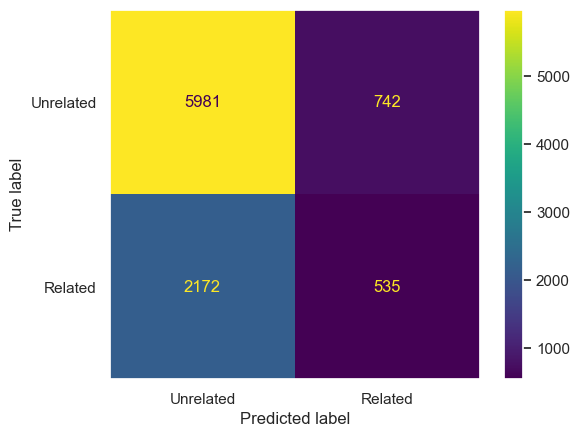

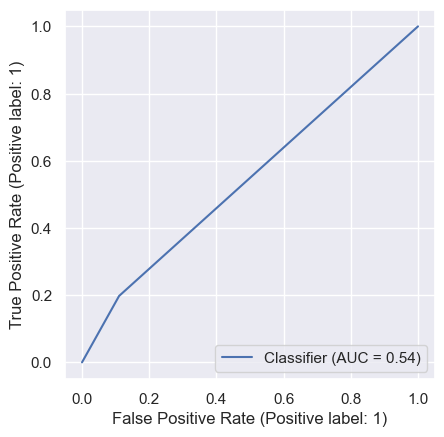

In [79]:
tfidf_feature_report(val_labels, val_pred)

In [80]:
y_pred = model.predict(tfidf_test_input_features)

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.85      0.79     18349
           1       0.35      0.21      0.26      7064

    accuracy                           0.67     25413
   macro avg       0.55      0.53      0.53     25413
weighted avg       0.63      0.67      0.64     25413


Additional Metrics:
Binary F1 Score: 0.26365816825086613
Weighted F1 Score: 0.6440677195180847
Cohen-Kappa Score: 0.07136045502449428
MCC: 0.07536537263920247
ROC AUC: 0.5312209008831966



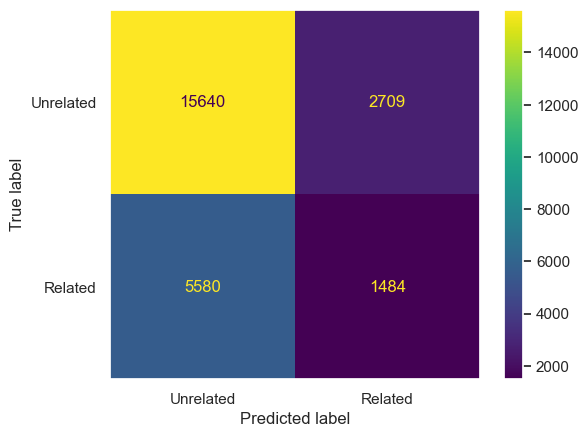

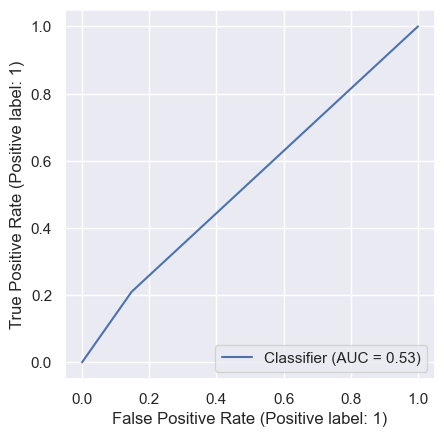

In [81]:
tfidf_feature_report(test_labels, y_pred)

In [82]:
del y_pred, model

### Complement Bayes

In [83]:
model = ComplementNB()
model.fit(tfidf_train_input_features, train_labels)

ComplementNB()

In [84]:
print("Train accuracy:", model.score(tfidf_train_input_features, train_labels))
print("Validation accuracy:", model.score(tfidf_val_input_features, val_labels))
print("Test accuracy:", model.score(tfidf_test_input_features, test_labels))

Train accuracy: 0.7996398796309999
Validation accuracy: 0.6669141039236479
Test accuracy: 0.5598315822610475


In [85]:
val_pred = model.predict(tfidf_val_input_features)

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      6723
           1       0.42      0.39      0.40      2707

    accuracy                           0.67      9430
   macro avg       0.59      0.59      0.59      9430
weighted avg       0.66      0.67      0.66      9430


Additional Metrics:
Binary F1 Score: 0.40409789413773484
Weighted F1 Score: 0.6641484318359752
Cohen-Kappa Score: 0.17319110405042604
MCC: 0.1733139338915987
ROC AUC: 0.5852292586454948



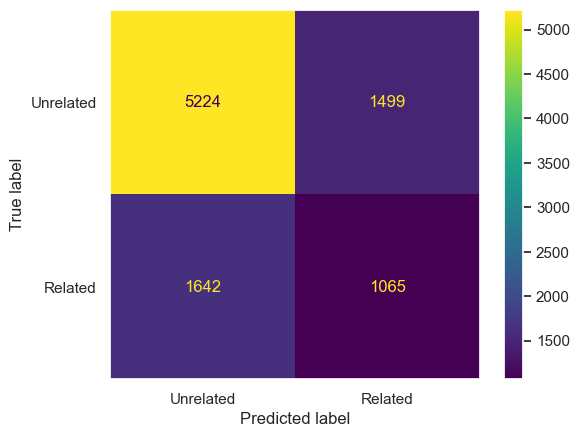

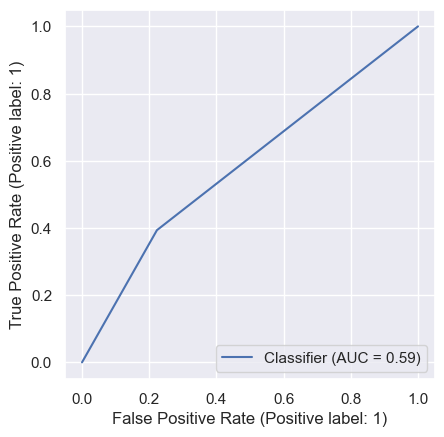

In [86]:
tfidf_feature_report(val_labels, val_pred)

In [71]:
y_pred = model.predict(tfidf_test_input_features)

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.58      0.65     18349
           1       0.32      0.52      0.40      7064

    accuracy                           0.56     25413
   macro avg       0.54      0.55      0.52     25413
weighted avg       0.64      0.56      0.58     25413


Additional Metrics:
Binary F1 Score: 0.3962651122625216
Weighted F1 Score: 0.5821144625630327
Cohen-Kappa Score: 0.07970138186226527
MCC: 0.08550010846621127
ROC AUC: 0.5474837216219287



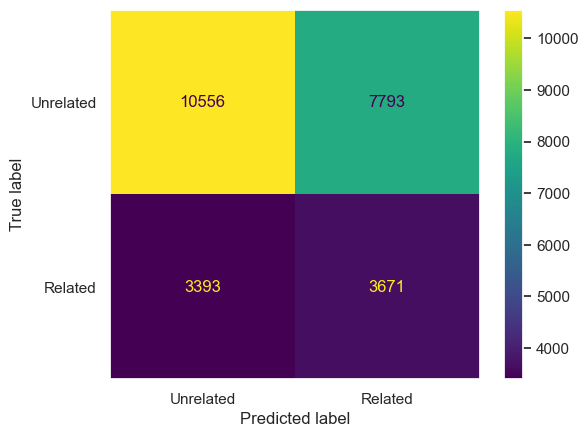

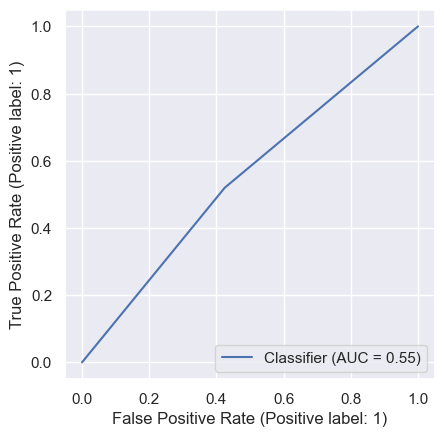

In [72]:
tfidf_feature_report(test_labels, y_pred)

In [73]:
del y_pred, model

### Gradient Boost

In [101]:
def f1_metric(ytrue,preds):
    ''' Return the F1 Score value for the preds and true values, ytrue '''
    return 'f1_score', f1_score((preds>=0.5).astype('int'), ytrue, average='weighted'), True

In [114]:
model = LGBMClassifier(learning_rate=0.06, n_estimators=1500, colsample_bytree=0.5, metric="f1_score", is_unbalance=True)
model.fit(
    tfidf_train_input_features.astype(np.float32),
    train_labels, 
    eval_set=[(tfidf_val_input_features.astype(np.float32), val_labels)],
    verbose=400
)

F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMClassifier(colsample_bytree=0.5, is_unbalance=True, learning_rate=0.06,
               metric='f1_score', n_estimators=1500)

In [115]:
print("Train accuracy:", model.score(tfidf_train_input_features.astype(np.float32), train_labels))
print("Validation accuracy:", model.score(tfidf_val_input_features.astype(np.float32), val_labels))
print("Test accuracy:", model.score(tfidf_test_input_features.astype(np.float32), test_labels))

Train accuracy: 0.9998273395491095
Validation accuracy: 0.9173913043478261
Test accuracy: 0.6063432101680243


In [116]:
val_pred = model.predict(tfidf_val_input_features)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      6723
           1       0.79      0.97      0.87      2707

    accuracy                           0.92      9430
   macro avg       0.89      0.93      0.91      9430
weighted avg       0.93      0.92      0.92      9430


Additional Metrics:
Binary F1 Score: 0.8711757896477591
Weighted F1 Score: 0.9196744871157291
Cohen-Kappa Score: 0.8113537465540331
MCC: 0.821057652106072
ROC AUC: 0.9340101172795823



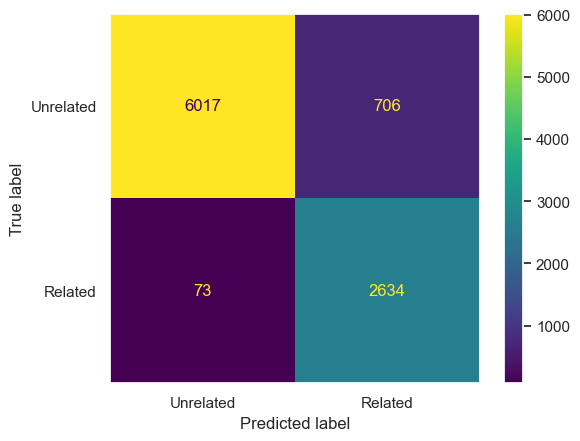

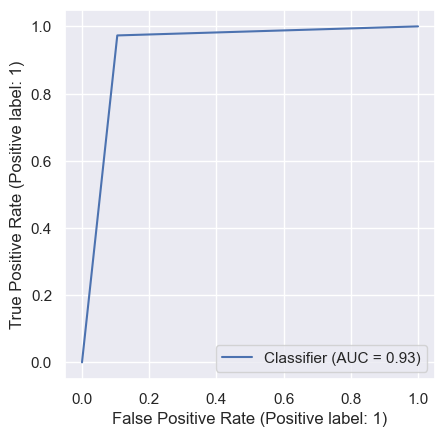

In [117]:
tfidf_feature_report(val_labels, val_pred)

In [118]:
y_pred = model.predict(tfidf_test_input_features)

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.53      0.66     18349
           1       0.40      0.80      0.53      7064

    accuracy                           0.61     25413
   macro avg       0.63      0.66      0.60     25413
weighted avg       0.74      0.61      0.62     25413


Additional Metrics:
Binary F1 Score: 0.52913489598042
Weighted F1 Score: 0.6249222764421071
Cohen-Kappa Score: 0.25129380025760406
MCC: 0.29693436930313233
ROC AUC: 0.6645799331965904



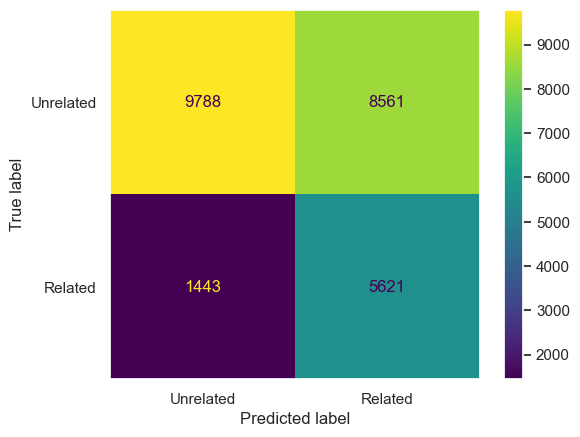

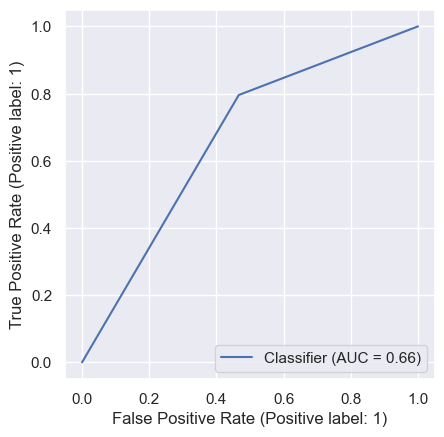

In [119]:
tfidf_feature_report(test_labels, y_pred)

In [120]:
del y_pred, model

### Decision Tree

In [121]:
model = DecisionTreeClassifier()
model.fit(tfidf_train_input_features, train_labels)

DecisionTreeClassifier()

In [122]:
print("Train accuracy:", model.score(tfidf_train_input_features, train_labels))
print("Validation accuracy:", model.score(tfidf_val_input_features, val_labels))
print("Test accuracy:", model.score(tfidf_test_input_features, test_labels))

Train accuracy: 1.0
Validation accuracy: 0.7200424178154825
Test accuracy: 0.5876913390784244


In [124]:
val_pred = model.predict(tfidf_val_input_features)

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.72      0.79      6723
           1       0.51      0.72      0.60      2707

    accuracy                           0.72      9430
   macro avg       0.69      0.72      0.69      9430
weighted avg       0.76      0.72      0.73      9430


Additional Metrics:
Binary F1 Score: 0.5976836330387078
Weighted F1 Score: 0.7314644282987918
Cohen-Kappa Score: 0.39292866950882843
MCC: 0.40737962836888264
ROC AUC: 0.7213493523135489



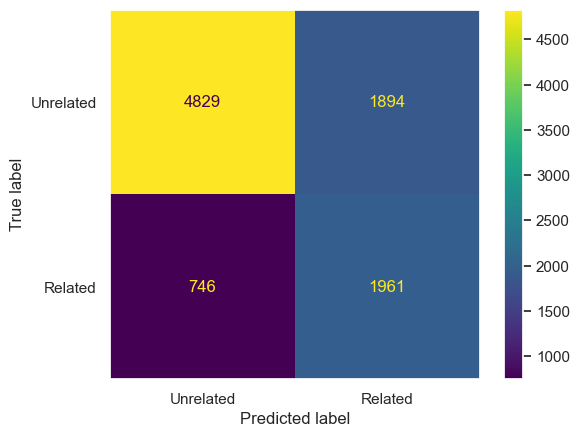

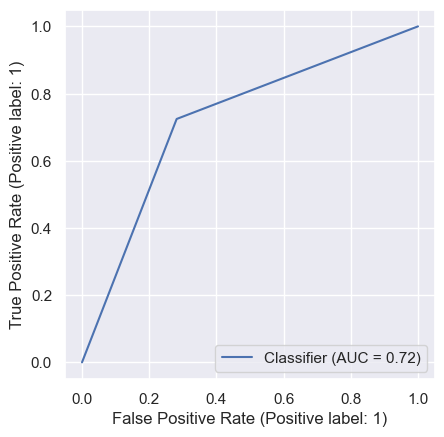

In [125]:
tfidf_feature_report(val_labels, val_pred)

In [123]:
y_pred = model.predict(tfidf_test_input_features)

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.65      0.69     18349
           1       0.32      0.43      0.37      7064

    accuracy                           0.59     25413
   macro avg       0.53      0.54      0.53     25413
weighted avg       0.63      0.59      0.60     25413


Additional Metrics:
Binary F1 Score: 0.3694029850746269
Weighted F1 Score: 0.6035668557332461
Cohen-Kappa Score: 0.07321085146562323
MCC: 0.07505072078701128
ROC AUC: 0.5405700708121327



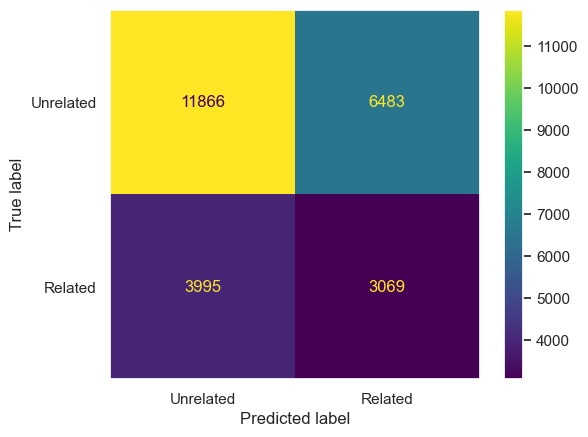

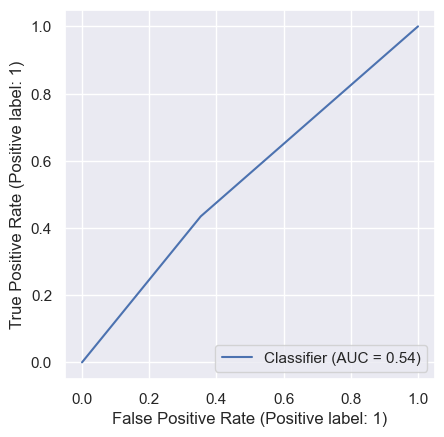

In [126]:
tfidf_feature_report(test_labels, y_pred)

In [127]:
del y_pred, model

### Random Forest

In [129]:
model = RandomForestClassifier()
model.fit(tfidf_train_input_features, train_labels)

RandomForestClassifier()

In [130]:
print("Train accuracy:", model.score(tfidf_train_input_features, train_labels))
print("Validation accuracy:", model.score(tfidf_val_input_features, val_labels))
print("Test accuracy:", model.score(tfidf_test_input_features, test_labels))

Train accuracy: 1.0
Validation accuracy: 0.7729586426299045
Test accuracy: 0.6938574745209145


In [131]:
val_pred = model.predict(tfidf_val_input_features)

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      6723
           1       0.58      0.79      0.67      2707

    accuracy                           0.77      9430
   macro avg       0.74      0.78      0.75      9430
weighted avg       0.81      0.77      0.78      9430


Additional Metrics:
Binary F1 Score: 0.6664589499922106
Weighted F1 Score: 0.7815618249384715
Cohen-Kappa Score: 0.5006818698592352
MCC: 0.5150283688701293
ROC AUC: 0.7781003475929467



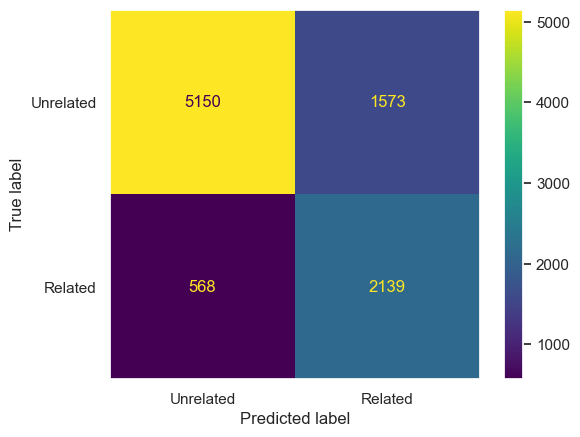

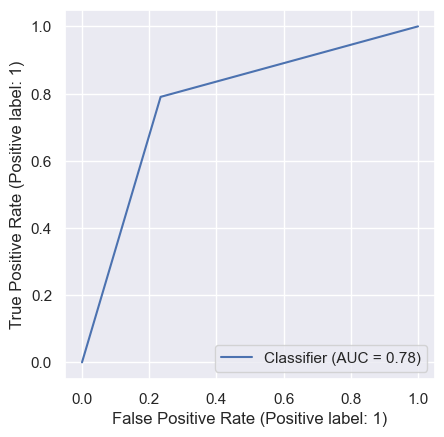

In [133]:
tfidf_feature_report(val_labels, val_pred)

In [132]:
y_pred = model.predict(tfidf_test_input_features)

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.88      0.81     18349
           1       0.40      0.20      0.27      7064

    accuracy                           0.69     25413
   macro avg       0.57      0.54      0.54     25413
weighted avg       0.65      0.69      0.66     25413


Additional Metrics:
Binary F1 Score: 0.26686769694685264
Weighted F1 Score: 0.6565248028655108
Cohen-Kappa Score: 0.09948901926032638
MCC: 0.10891647631624811
ROC AUC: 0.5421306915303367



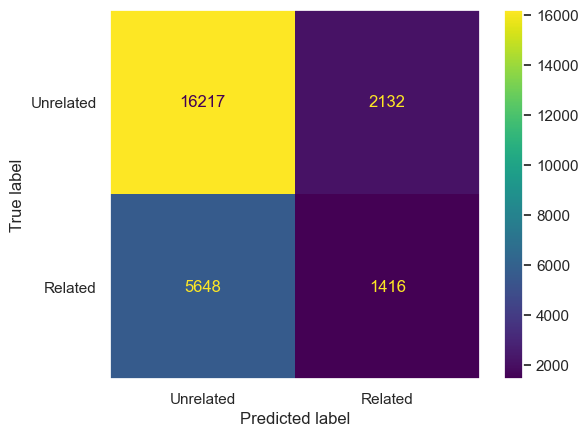

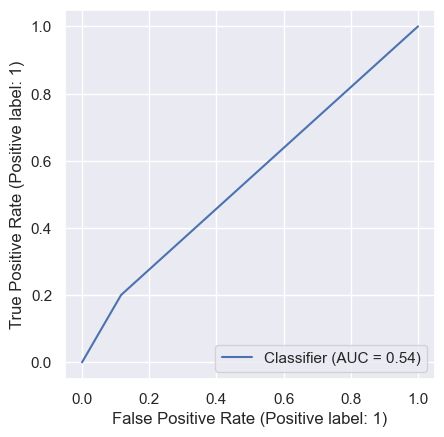

In [134]:
tfidf_feature_report(test_labels, y_pred)

In [135]:
del y_pred, model

## Transformer Features

In [65]:
train_labels_tensor = torch.LongTensor(transformer_train_df["Related"].values.astype(int))
train_labels_tensor.shape

torch.Size([40047])

In [66]:
val_labels_tensor = torch.LongTensor(transformer_val_df["Related"].values.astype(int))
val_labels_tensor.shape

torch.Size([9925])

In [67]:
test_labels_tensor = torch.LongTensor(transformer_test_df["Related"].values.astype(int))
test_labels_tensor.shape

torch.Size([25413])

In [68]:
class TransformerTokenDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_masks[idx],
            "labels": self.labels[idx] 
        }

        return item
    
    def get_labels(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)

In [69]:
train_transformer_input_ids = torch.concat(list(transformer_train_df["input_ids"].values))
train_transformer_attention_masks = torch.concat(list(transformer_train_df["attention_mask"].values))
transformer_train_dataset = TransformerTokenDataset(train_transformer_input_ids, train_transformer_attention_masks, train_labels_tensor)

In [70]:
val_transformer_input_ids = torch.concat(list(transformer_val_df["input_ids"].values))
val_transformer_attention_masks = torch.concat(list(transformer_val_df["attention_mask"].values))
transformer_val_dataset = TransformerTokenDataset(val_transformer_input_ids, val_transformer_attention_masks, val_labels_tensor)

In [71]:
test_transformer_input_ids = torch.concat(list(transformer_test_df["input_ids"].values))
test_transformer_attention_masks = torch.concat(list(transformer_test_df["attention_mask"].values))
transformer_test_dataset = TransformerTokenDataset(test_transformer_input_ids, test_transformer_attention_masks, test_labels_tensor)

In [72]:
transformer = AutoModel.from_pretrained(selected_transformer_name).to(device)

def extract_cls_tokens(dataset, cls_batch_size=64):
    rows = []
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=cls_batch_size, shuffle=False)
    
    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            
            cls_outputs = transformer(input_ids, attention_mask=attention_mask)["last_hidden_state"][:, 0, :].detach().cpu()
            
            for cls_output, label in zip(cls_outputs, batch["labels"]):
                rows.append({"CLS Output": cls_output.numpy(), "Related": label.item() == 1})
    
    cls_df = pd.DataFrame(rows)
    cls_df = cls_df.sample(frac=1).reset_index(drop=True)
    
    return cls_df

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [73]:
cls_train_df = extract_cls_tokens(transformer_train_dataset)

  0%|          | 0/626 [00:00<?, ?it/s]

In [74]:
cls_val_df = extract_cls_tokens(transformer_val_dataset)

  0%|          | 0/156 [00:00<?, ?it/s]

In [75]:
cls_test_df = extract_cls_tokens(transformer_test_dataset)

  0%|          | 0/398 [00:00<?, ?it/s]

In [76]:
cls_train_features = np.array(list(cls_train_df["CLS Output"].values))
cls_train_labels = cls_train_df["Related"].values.astype(int)

In [77]:
cls_train_features.shape

(40047, 768)

In [78]:
cls_train_labels.shape

(40047,)

In [79]:
cls_val_features = np.array(list(cls_val_df["CLS Output"].values))
cls_val_labels = cls_val_df["Related"].values.astype(int)

In [80]:
cls_val_features.shape

(9925, 768)

In [81]:
cls_val_labels.shape

(9925,)

In [82]:
cls_test_features = np.array(list(cls_test_df["CLS Output"].values))
cls_test_labels = cls_test_df["Related"].values.astype(int)

In [83]:
cls_test_features.shape

(25413, 768)

In [84]:
cls_test_labels.shape

(25413,)

In [85]:
def transformer_feature_report(y_true, y_pred):
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    print()
    
    print("Additional Metrics:")
    
    binary_f1 = f1_score(y_true, y_pred)
    print("Binary F1 Score:", binary_f1)
    
    weighted_f1 = f1_score(y_true, y_pred, average="weighted")
    print("Weighted F1 Score:", weighted_f1)
    
    kappa = cohen_kappa_score(y_true, y_pred)
    print("Cohen-Kappa Score:", kappa)
    
    mcc = matthews_corrcoef(y_true, y_pred)
    print("MCC:", mcc)
    
    auc = roc_auc_score(y_true, y_pred)
    print("ROC AUC:", auc)
    
    print()
    
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=["Unrelated", "Related"], values_format="")
    plt.grid(False)
    plt.show
    
    RocCurveDisplay.from_predictions(y_true, y_pred)
    plt.gca().set_aspect("equal")
    plt.grid(True)
    plt.show()

### Decision Trees

In [96]:
model = DecisionTreeClassifier()
model.fit(cls_train_features, cls_train_labels)

DecisionTreeClassifier()

In [97]:
print("Train accuracy:", model.score(cls_train_features, cls_train_labels))
print("Validation accuracy:", model.score(cls_val_features, cls_val_labels))
print("Test accuracy:", model.score(cls_test_features, cls_test_labels))

Train accuracy: 1.0
Validation accuracy: 0.5504725897920605
Test accuracy: 0.556093338055326


In [98]:
val_pred = model.predict(cls_val_features)

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.55      0.65      7967
           1       0.29      0.54      0.37      2613

    accuracy                           0.55     10580
   macro avg       0.54      0.55      0.51     10580
weighted avg       0.66      0.55      0.58     10580


Additional Metrics:
Binary F1 Score: 0.37404580152671757
Weighted F1 Score: 0.5813297157148883
Cohen-Kappa Score: 0.07392533352670083
MCC: 0.08334797762926212
ROC AUC: 0.5482370326775139



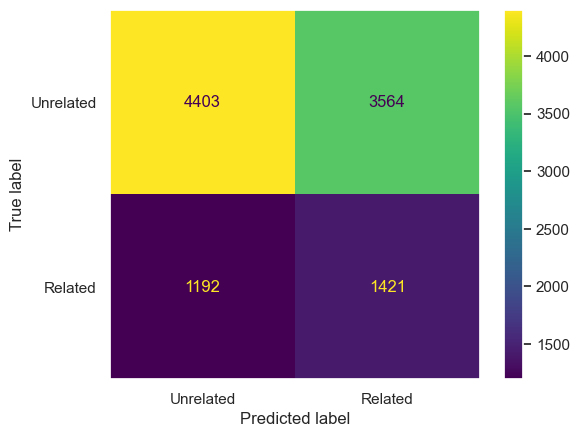

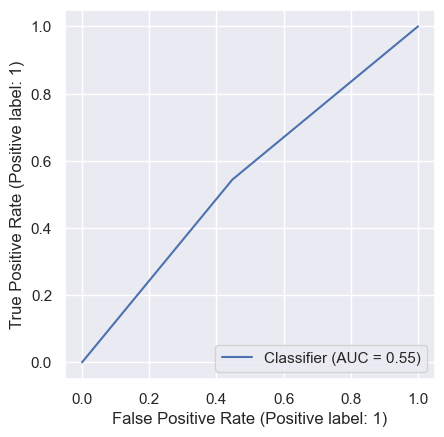

In [99]:
transformer_feature_report(cls_val_labels, val_pred)

In [100]:
y_pred = model.predict(cls_test_features)

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.56      0.65     18349
           1       0.32      0.54      0.40      7064

    accuracy                           0.56     25413
   macro avg       0.54      0.55      0.53     25413
weighted avg       0.64      0.56      0.58     25413


Additional Metrics:
Binary F1 Score: 0.40441370571775515
Weighted F1 Score: 0.5789891847054979
Cohen-Kappa Score: 0.08568131838450443
MCC: 0.09305334518094915
ROC AUC: 0.5518166103953873



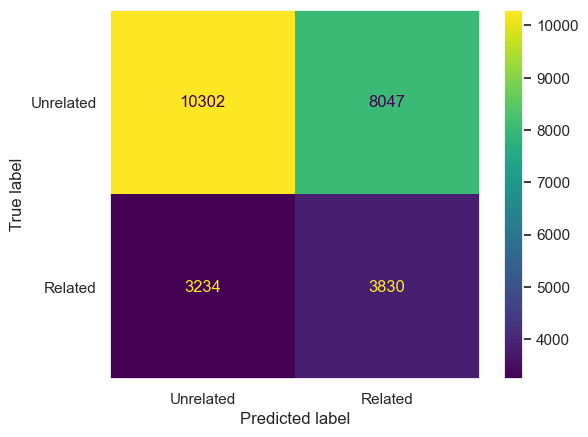

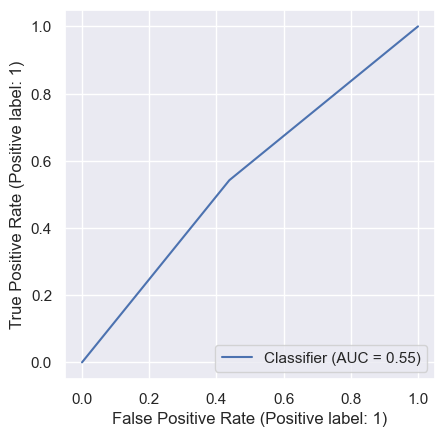

In [101]:
transformer_feature_report(cls_test_labels, y_pred)

In [102]:
del y_pred, model

### SVM

In [103]:
model = SVC(verbose=True)
model.fit(cls_train_features, cls_train_labels)

[LibSVM]

SVC(verbose=True)

In [104]:
print("Train accuracy:", model.score(cls_train_features, cls_train_labels))
print("Validation accuracy:", model.score(cls_val_features, cls_val_labels))
print("Test accuracy:", model.score(cls_test_features, cls_test_labels))

Train accuracy: 0.7254772542648253
Validation accuracy: 0.7530245746691872
Test accuracy: 0.7220320308503522


In [105]:
val_pred = model.predict(cls_val_features)

Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86      7967
           1       0.00      0.00      0.00      2613

    accuracy                           0.75     10580
   macro avg       0.38      0.50      0.43     10580
weighted avg       0.57      0.75      0.65     10580


Additional Metrics:
Binary F1 Score: 0.0
Weighted F1 Score: 0.6469344677187052
Cohen-Kappa Score: 0.0
MCC: 0.0
ROC AUC: 0.5



F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

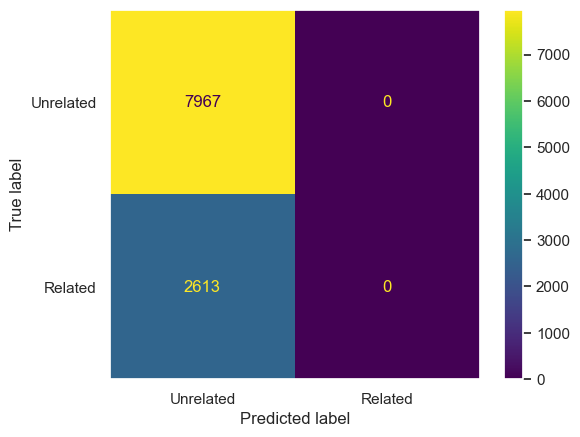

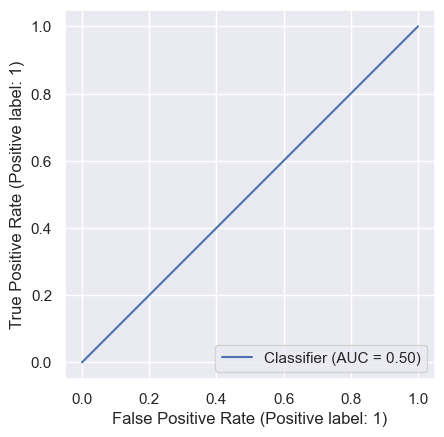

In [106]:
transformer_feature_report(cls_val_labels, val_pred)

In [107]:
y_pred = model.predict(cls_test_features)

Classification Report:
              precision    recall  f1-score   support

           0       0.72      1.00      0.84     18349
           1       0.00      0.00      0.00      7064

    accuracy                           0.72     25413
   macro avg       0.36      0.50      0.42     25413
weighted avg       0.52      0.72      0.61     25413


Additional Metrics:
Binary F1 Score: 0.0
Weighted F1 Score: 0.6054826440324077
Cohen-Kappa Score: 0.0
MCC: 0.0
ROC AUC: 0.5



F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

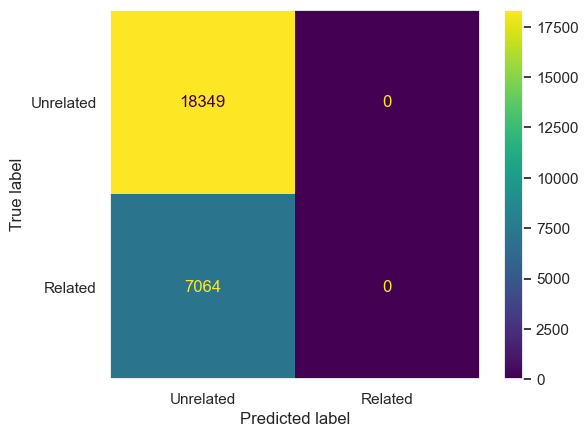

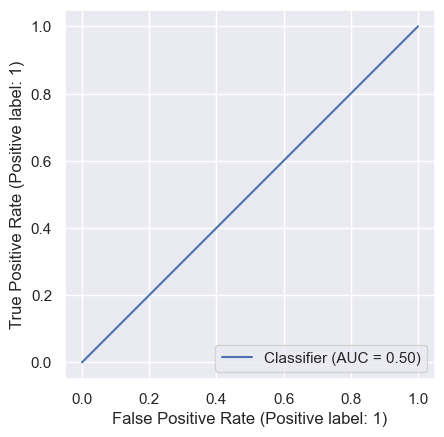

In [108]:
transformer_feature_report(cls_test_labels, y_pred)

In [91]:
del y_pred, model

### Gradient Boost

In [99]:
def f1_metric(ytrue,preds):
    ''' Return the F1 Score value for the preds and true values, ytrue '''
    return 'f1_score', f1_score((preds>=0.5).astype('int'), ytrue, average="weighted"), True

In [106]:
model = LGBMClassifier(learning_rate=0.06, n_estimators=1500, colsample_bytree=0.5, metric="f1_score", scale_pos_weighting=2.0)
model.fit(
    cls_train_features.astype(np.float32),
    cls_train_labels, 
    eval_set=[(cls_val_features.astype(np.float32), cls_val_labels)],
    verbose=400, 
    eval_metric=f1_metric
)

F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: scale_pos_weighting
[400]	valid_0's f1_score: 0.636138
[800]	valid_0's f1_score: 0.622192
[1200]	valid_0's f1_score: 0.622725


LGBMClassifier(colsample_bytree=0.5, learning_rate=0.06, metric='f1_score',
               n_estimators=1500, scale_pos_weighting=2.0)

In [107]:
print("Train accuracy:", model.score(cls_train_features, cls_train_labels))
print("Validation accuracy:", model.score(cls_val_features, cls_val_labels))
print("Test accuracy:", model.score(cls_test_features, cls_test_labels))

Train accuracy: 1.0
Validation accuracy: 0.6506801007556675
Test accuracy: 0.6941722740329752


In [108]:
val_pred = model.predict(cls_val_features)

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.62      0.72      7278
           1       0.41      0.75      0.53      2647

    accuracy                           0.65      9925
   macro avg       0.64      0.68      0.63      9925
weighted avg       0.75      0.65      0.67      9925


Additional Metrics:
Binary F1 Score: 0.5333153856508278
Weighted F1 Score: 0.6708534899150616
Cohen-Kappa Score: 0.2892985110968548
MCC: 0.3217490626392463
ROC AUC: 0.6817679655804509



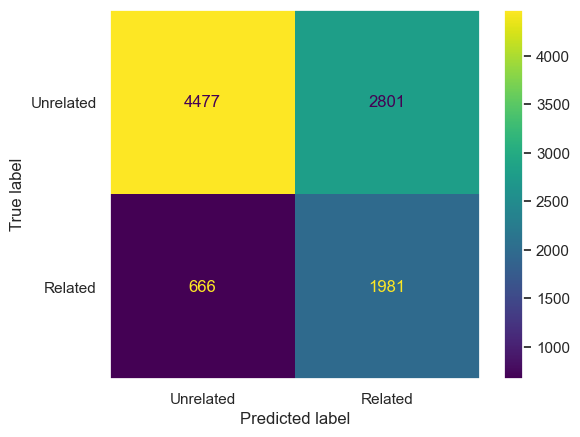

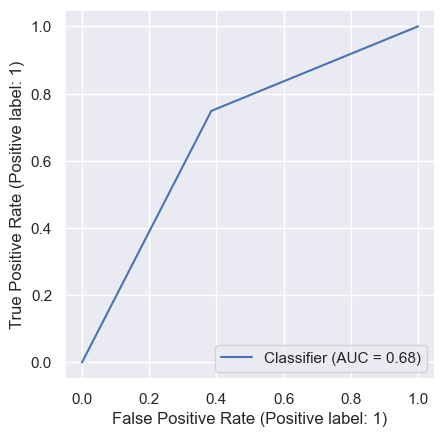

In [109]:
transformer_feature_report(cls_val_labels, val_pred)

In [110]:
y_pred = model.predict(cls_test_features)

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.74      0.78     18349
           1       0.46      0.57      0.51      7064

    accuracy                           0.69     25413
   macro avg       0.64      0.65      0.64     25413
weighted avg       0.72      0.69      0.70     25413


Additional Metrics:
Binary F1 Score: 0.5073529411764707
Weighted F1 Score: 0.7029562472297661
Cohen-Kappa Score: 0.2891042580959039
MCC: 0.2924459363579412
ROC AUC: 0.6549224017379898



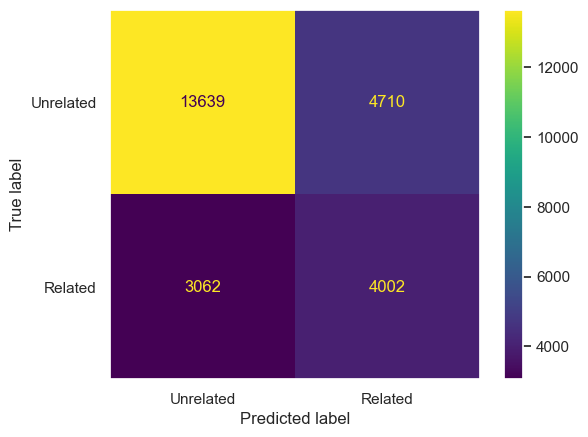

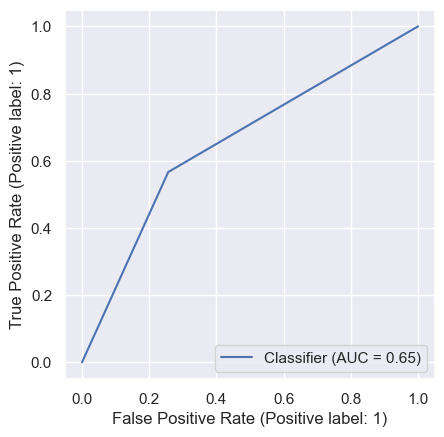

In [111]:
transformer_feature_report(cls_test_labels, y_pred)

In [ ]:
del y_pred, model

# Part 2.a.ii: Related / Unrelated Classification with Deep Learning Models

## TF-IDF

In [60]:
batch_size = 64
apply_loss_weighting = False

In [61]:
unique_class_labels = np.unique(tfidf_train_labels_tensor)
class_weights = compute_class_weight("balanced", classes=unique_class_labels, y=tfidf_train_labels_tensor.squeeze().numpy())
class_weights = torch.from_numpy(class_weights)
class_weights

tensor([0.6847, 1.8537], dtype=torch.float64)

In [62]:
tfidf_train_dataset = torch.utils.data.TensorDataset(tfidf_train_sparse_tensor, tfidf_train_labels_tensor)
tfidf_train_dataloader = torch.utils.data.DataLoader(tfidf_train_dataset, batch_size=batch_size, shuffle=True)

In [63]:
tfidf_val_dataset = torch.utils.data.TensorDataset(tfidf_val_sparse_tensor, tfidf_val_labels_tensor)
tfidf_val_dataloader = torch.utils.data.DataLoader(tfidf_val_dataset, batch_size=batch_size)

In [64]:
tfidf_test_dataset = torch.utils.data.TensorDataset(tfidf_test_sparse_tensor, tfidf_test_labels_tensor)
tfidf_test_dataloader = torch.utils.data.DataLoader(tfidf_test_dataset, batch_size=batch_size)

In [65]:
def evaluate_model(model, dataloader, apply_loss_weighting):
    if not apply_loss_weighting:
        loss_func = nn.BCEWithLogitsLoss()
    
    with torch.no_grad():
        model.eval()
        
        all_pred = np.array([])
        total_loss = 0
        
        for inp, labels in tqdm(dataloader):
            inp = inp.to_dense().to(device)
            labels = labels.to(device)
            
            loss_weights = torch.zeros_like(labels)
            loss_weights[labels == 0] = class_weights[0]
            loss_weights[labels == 1] = class_weights[1]
            loss_func = nn.BCEWithLogitsLoss(weight=loss_weights)
        
            pred = model(inp)
            loss = loss_func(pred, labels.float())
            pred = torch.sigmoid(pred)
            
            all_pred = np.concatenate([all_pred, pred.cpu().round().numpy().squeeze()])
            total_loss += loss.item()
        
        model.train()
    
    return all_pred, total_loss / len(dataloader)

In [72]:
create_classifier_model = lambda inp_dim: nn.Sequential(*[
    nn.Linear(inp_dim, 1024),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(128, 1)
])

In [73]:
classifier_model = create_classifier_model(tfidf_train_sparse_tensor.shape[1]).to(device)

In [74]:
classifier_model

Sequential(
  (0): Linear(in_features=53650, out_features=1024, bias=True)
  (1): Dropout(p=0.2, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): Dropout(p=0.2, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=256, bias=True)
  (7): Dropout(p=0.2, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=128, bias=True)
  (10): Dropout(p=0.2, inplace=False)
  (11): ReLU()
  (12): Linear(in_features=128, out_features=1, bias=True)
)

In [75]:
opt = optim.Adam(classifier_model.parameters(), lr=1e-3)

  0%|          | 0/634 [00:00<?, ?it/s]

[1:40] Loss: 0.593
[1:80] Loss: 0.486
[1:120] Loss: 0.441
[1:160] Loss: 0.353
[1:200] Loss: 0.284
[1:240] Loss: 0.235
[1:280] Loss: 0.205
[1:320] Loss: 0.177
[1:360] Loss: 0.151
[1:400] Loss: 0.135
[1:440] Loss: 0.105
[1:480] Loss: 0.124
[1:520] Loss: 0.099
[1:560] Loss: 0.084
[1:600] Loss: 0.080
[1:END] Took 194.795s
[1:END] Training Loss: 0.228


  0%|          | 0/148 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92      6945
         1.0       0.71      0.97      0.82      2494

    accuracy                           0.89      9439
   macro avg       0.85      0.91      0.87      9439
weighted avg       0.91      0.89      0.89      9439


Additional Metrics:
Binary F1 Score: 0.8187035786630654
Weighted F1 Score: 0.8910949706842858
Cohen-Kappa Score: 0.7387770745857353
MCC: 0.7586996461532419
ROC AUC: 0.913812588657703



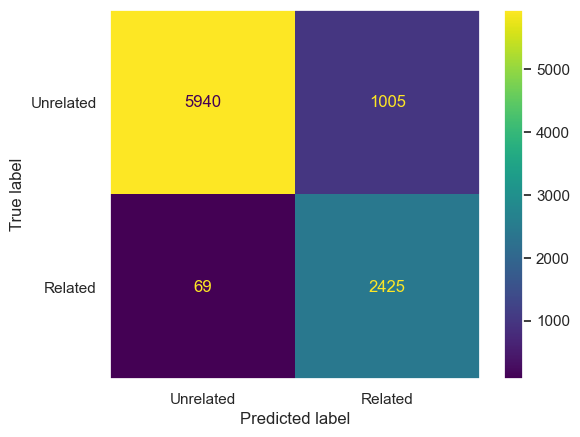

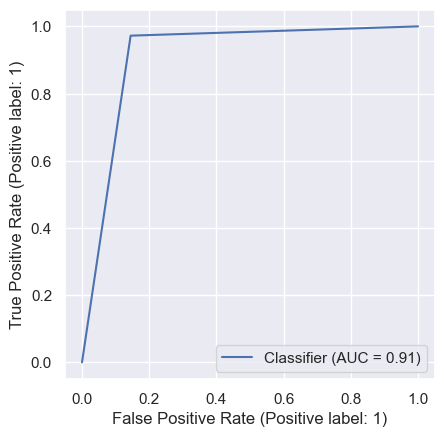

[1:END] Validation Loss: 0.215
[1:END] Validation Accuracy: 88.622%


  0%|          | 0/398 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.23      0.38     18349
         1.0       0.33      0.99      0.50      7064

    accuracy                           0.44     25413
   macro avg       0.66      0.61      0.44     25413
weighted avg       0.80      0.44      0.41     25413


Additional Metrics:
Binary F1 Score: 0.4961940670128762
Weighted F1 Score: 0.40967358263601344
Cohen-Kappa Score: 0.13694920372469366
MCC: 0.26174886703891626
ROC AUC: 0.6101645654868266



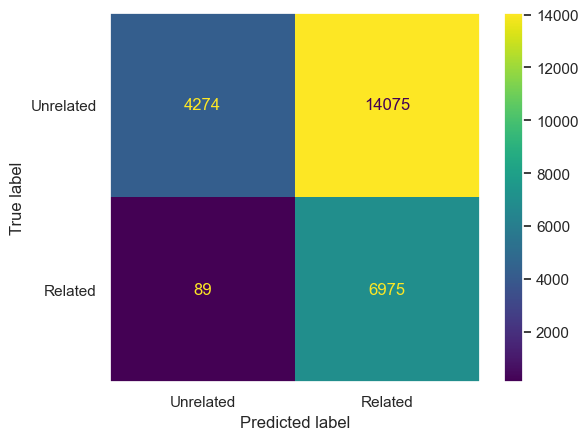

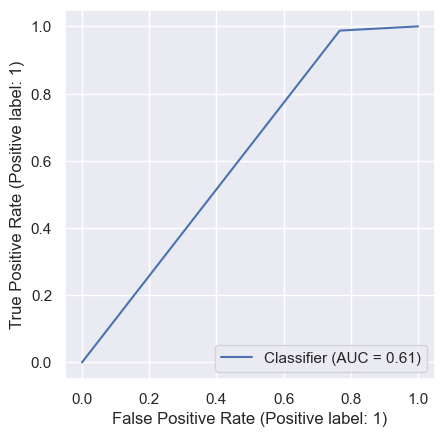

[1:END] Test Loss: 0.700
[1:END] Test Accuracy: 44.265%
[1:END] Validation loss improved, saved model to ./runs/1681904201.7140074_no_weight/model_1.pth


  0%|          | 0/634 [00:00<?, ?it/s]

[2:40] Loss: 0.048
[2:80] Loss: 0.049
[2:120] Loss: 0.052
[2:160] Loss: 0.040
[2:200] Loss: 0.044
[2:240] Loss: 0.037
[2:280] Loss: 0.039
[2:320] Loss: 0.030
[2:360] Loss: 0.050
[2:400] Loss: 0.038
[2:440] Loss: 0.031
[2:480] Loss: 0.041
[2:520] Loss: 0.039
[2:560] Loss: 0.030
[2:600] Loss: 0.029
[2:END] Took 193.039s
[2:END] Training Loss: 0.040


  0%|          | 0/148 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.85      0.92      6945
         1.0       0.71      0.99      0.83      2494

    accuracy                           0.89      9439
   macro avg       0.85      0.92      0.87      9439
weighted avg       0.92      0.89      0.89      9439


Additional Metrics:
Binary F1 Score: 0.8263052208835341
Weighted F1 Score: 0.8949106489290175
Cohen-Kappa Score: 0.7490299505769169
MCC: 0.7713617481008547
ROC AUC: 0.9220578055439607



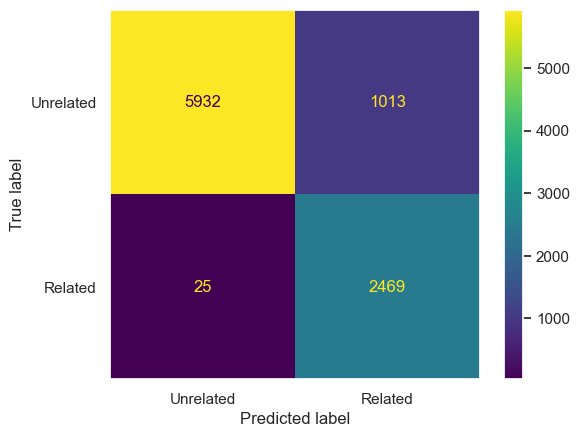

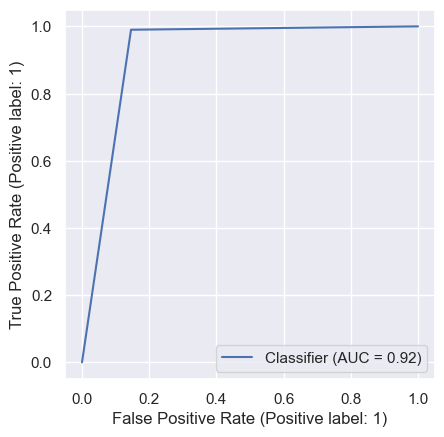

[2:END] Validation Loss: 0.180
[2:END] Validation Accuracy: 89.003%


  0%|          | 0/398 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.21      0.35     18349
         1.0       0.33      0.99      0.49      7064

    accuracy                           0.43     25413
   macro avg       0.66      0.60      0.42     25413
weighted avg       0.81      0.43      0.39     25413


Additional Metrics:
Binary F1 Score: 0.4915153423603093
Weighted F1 Score: 0.38694294215194935
Cohen-Kappa Score: 0.12551511231521284
MCC: 0.2542687833964321
ROC AUC: 0.6022425889080145



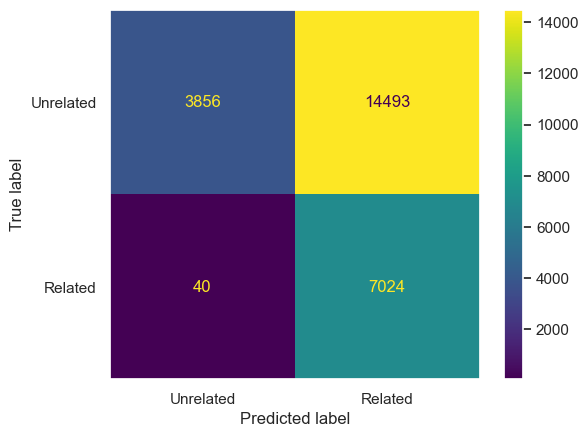

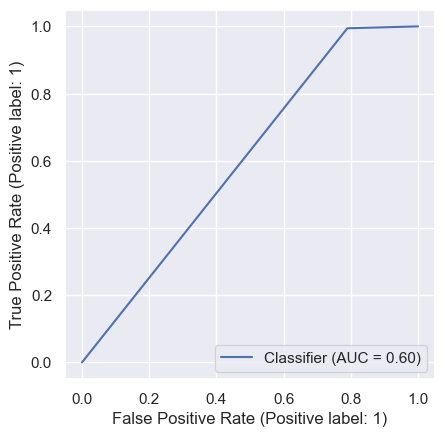

[2:END] Test Loss: 0.769
[2:END] Test Accuracy: 42.813%
[2:END] Validation loss improved, saved model to ./runs/1681904201.7140074_no_weight/model_2.pth


  0%|          | 0/634 [00:00<?, ?it/s]

[3:40] Loss: 0.017
[3:80] Loss: 0.019
[3:120] Loss: 0.013
[3:160] Loss: 0.017
[3:200] Loss: 0.014
[3:240] Loss: 0.019
[3:280] Loss: 0.014
[3:320] Loss: 0.014
[3:360] Loss: 0.010
[3:400] Loss: 0.021
[3:440] Loss: 0.019
[3:480] Loss: 0.015
[3:520] Loss: 0.024
[3:560] Loss: 0.016
[3:600] Loss: 0.011
[3:END] Took 176.100s
[3:END] Training Loss: 0.016


  0%|          | 0/148 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.91      0.95      6945
         1.0       0.80      0.98      0.88      2494

    accuracy                           0.93      9439
   macro avg       0.90      0.95      0.92      9439
weighted avg       0.94      0.93      0.93      9439


Additional Metrics:
Binary F1 Score: 0.8835529879039538
Weighted F1 Score: 0.9336539359078347
Cohen-Kappa Score: 0.8358729558541572
MCC: 0.8442119920281013
ROC AUC: 0.9475248299302055



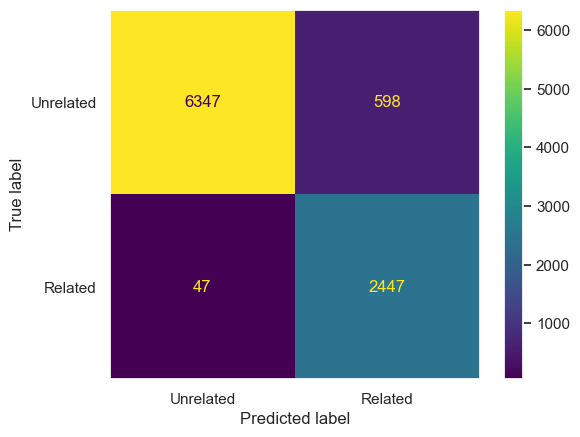

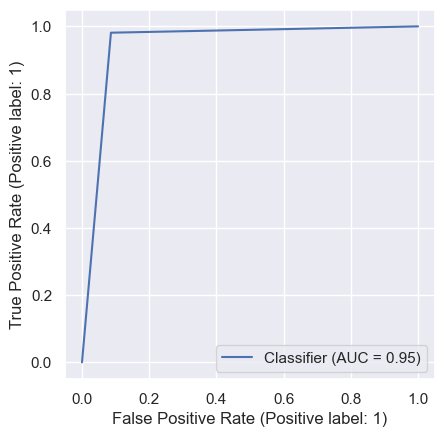

[3:END] Validation Loss: 0.154
[3:END] Validation Accuracy: 93.167%


  0%|          | 0/398 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.26      0.41     18349
         1.0       0.34      0.99      0.50      7064

    accuracy                           0.46     25413
   macro avg       0.66      0.62      0.46     25413
weighted avg       0.80      0.46      0.43     25413


Additional Metrics:
Binary F1 Score: 0.503867563073809
Weighted F1 Score: 0.43417174525919283
Cohen-Kappa Score: 0.1533749431283391
MCC: 0.27875926886482655
ROC AUC: 0.6218821608862568



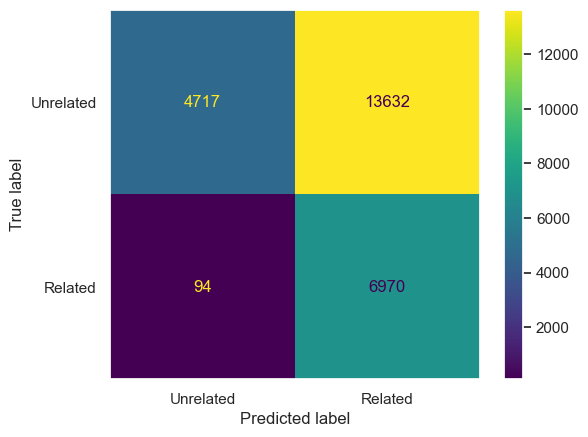

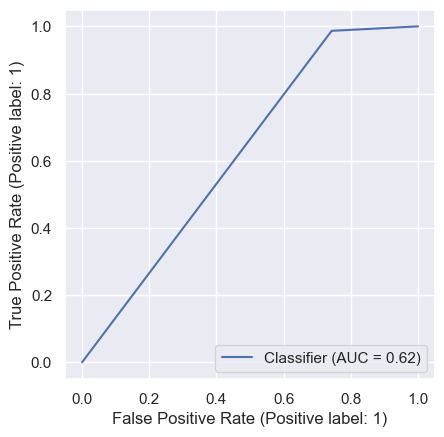

[3:END] Test Loss: 0.881
[3:END] Test Accuracy: 45.988%
[3:END] Validation loss improved, saved model to ./runs/1681904201.7140074_no_weight/model_3.pth


  0%|          | 0/634 [00:00<?, ?it/s]

[4:40] Loss: 0.008
[4:80] Loss: 0.014
[4:120] Loss: 0.014
[4:160] Loss: 0.007
[4:200] Loss: 0.009
[4:240] Loss: 0.010
[4:280] Loss: 0.014
[4:320] Loss: 0.006
[4:360] Loss: 0.008
[4:400] Loss: 0.021
[4:440] Loss: 0.015
[4:480] Loss: 0.007
[4:520] Loss: 0.014
[4:560] Loss: 0.009
[4:600] Loss: 0.014
[4:END] Took 189.936s
[4:END] Training Loss: 0.011


  0%|          | 0/148 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.90      0.95      6945
         1.0       0.79      0.98      0.87      2494

    accuracy                           0.92      9439
   macro avg       0.89      0.94      0.91      9439
weighted avg       0.94      0.92      0.93      9439


Additional Metrics:
Binary F1 Score: 0.8722341184867952
Weighted F1 Score: 0.9265534867355265
Cohen-Kappa Score: 0.8192162761964671
MCC: 0.8293085927192715
ROC AUC: 0.9420277781145592



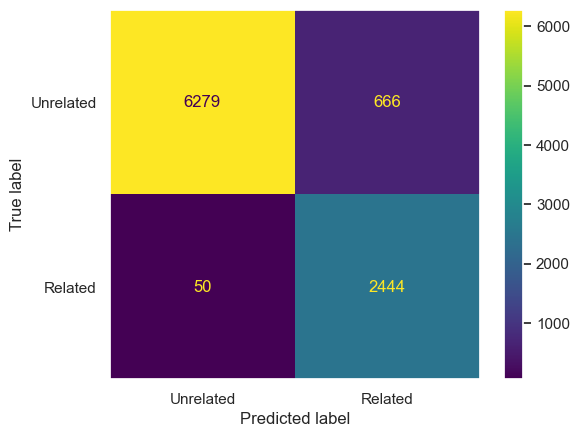

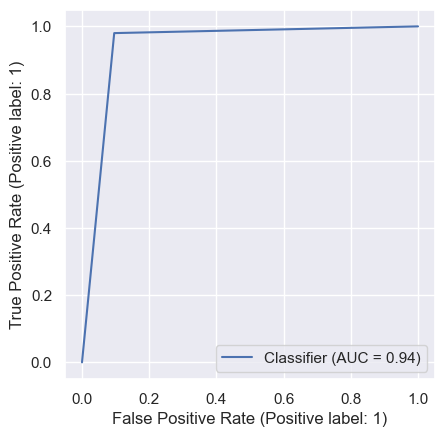

[4:END] Validation Loss: 0.188
[4:END] Validation Accuracy: 92.414%


  0%|          | 0/398 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.27      0.42     18349
         1.0       0.34      0.99      0.51      7064

    accuracy                           0.47     25413
   macro avg       0.66      0.63      0.46     25413
weighted avg       0.81      0.47      0.44     25413


Additional Metrics:
Binary F1 Score: 0.5085263425808093
Weighted F1 Score: 0.4449275927613623
Cohen-Kappa Score: 0.16252718280334533
MCC: 0.2903670180797173
ROC AUC: 0.6285785298040688



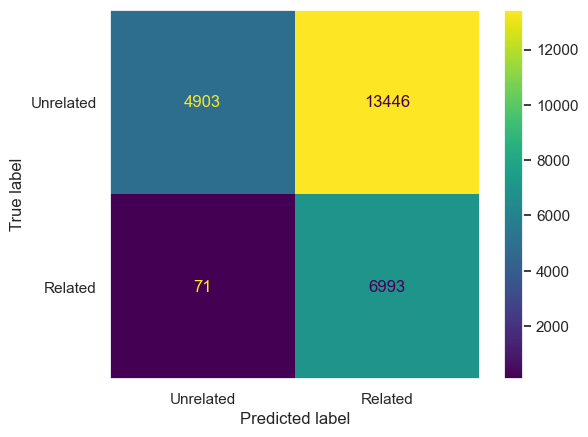

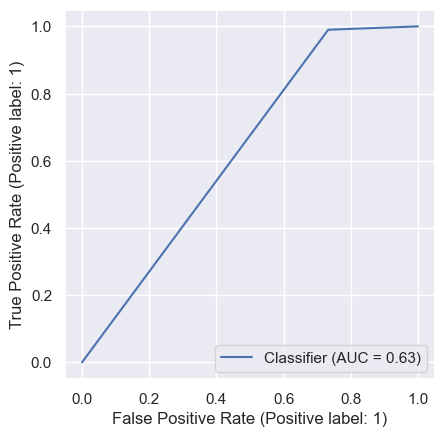

[4:END] Test Loss: 0.826
[4:END] Test Accuracy: 46.811%


  0%|          | 0/634 [00:00<?, ?it/s]

[5:40] Loss: 0.004
[5:80] Loss: 0.003
[5:120] Loss: 0.006
[5:160] Loss: 0.008
[5:200] Loss: 0.003
[5:240] Loss: 0.013
[5:280] Loss: 0.002
[5:320] Loss: 0.004
[5:360] Loss: 0.008
[5:400] Loss: 0.005
[5:440] Loss: 0.012
[5:480] Loss: 0.004
[5:520] Loss: 0.003
[5:560] Loss: 0.002
[5:600] Loss: 0.005
[5:END] Took 177.927s
[5:END] Training Loss: 0.006


  0%|          | 0/148 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92      6945
         1.0       0.72      0.99      0.83      2494

    accuracy                           0.89      9439
   macro avg       0.86      0.92      0.88      9439
weighted avg       0.92      0.89      0.90      9439


Additional Metrics:
Binary F1 Score: 0.8318943626206197
Weighted F1 Score: 0.8992549356271362
Cohen-Kappa Score: 0.7580064085813615
MCC: 0.7777628478644946
ROC AUC: 0.9237557033929666



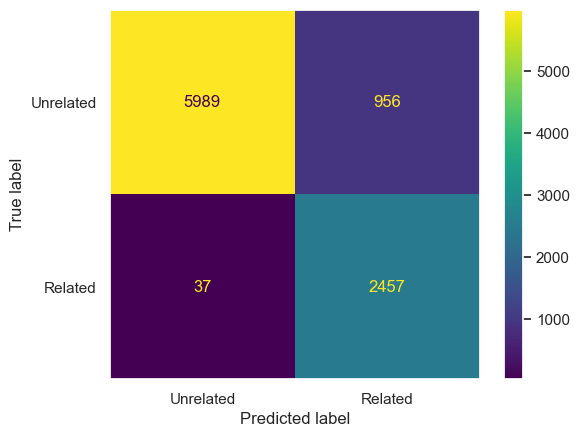

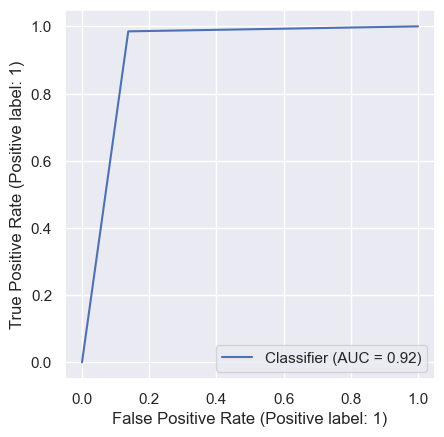

[5:END] Validation Loss: 0.290
[5:END] Validation Accuracy: 89.480%


  0%|          | 0/398 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.22      0.36     18349
         1.0       0.33      1.00      0.49      7064

    accuracy                           0.43     25413
   macro avg       0.66      0.61      0.43     25413
weighted avg       0.81      0.43      0.40     25413


Additional Metrics:
Binary F1 Score: 0.49465240641711233
Weighted F1 Score: 0.3965678517807359
Cohen-Kappa Score: 0.1320430748507878
MCC: 0.26211889113444536
ROC AUC: 0.6071089364157276



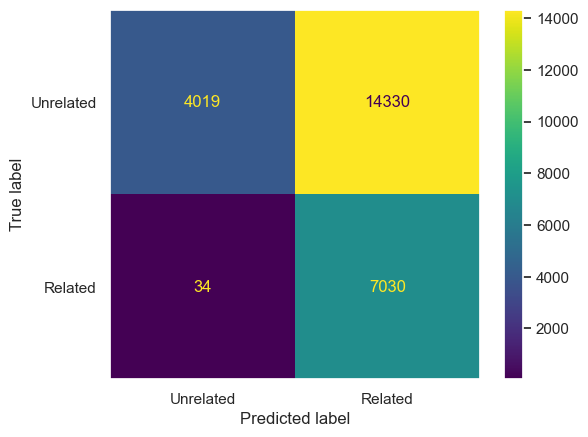

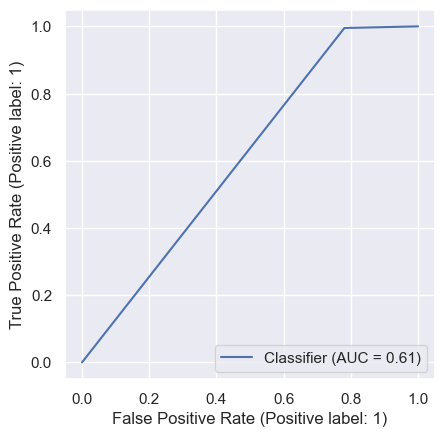

[5:END] Test Loss: 1.134
[5:END] Test Accuracy: 43.478%
[END] Stopping early as validation loss hasn't improved in 2 epochs
Training complete


In [76]:
best_validation_loss = 1e9
save_path = f"./runs/{time.time()}_{'weighted' if apply_loss_weighting else 'no_weight'}"
epochs_since_best_validation = 0

os.makedirs(save_path, exist_ok=True)

val_labels = tfidf_val_labels_tensor.squeeze().numpy()
test_labels = tfidf_test_labels_tensor.squeeze().numpy()

if not apply_loss_weighting:
    loss_func = nn.BCEWithLogitsLoss()

for epoch in range(1, 16):
    epoch_st = time.time()
    epoch_loss = 0
    
    batch_acc_loss = 0
    
    for batch_no, (inp, labels) in enumerate(tqdm(tfidf_train_dataloader)):
        inp = inp.to_dense().to(device)
        labels = labels.to(device)
        
        if apply_loss_weighting:
            loss_weights = torch.zeros_like(labels)
            loss_weights[labels == 0] = class_weights[0]
            loss_weights[labels == 1] = class_weights[1]
            loss_func = nn.BCEWithLogitsLoss(weight=loss_weights)
        
        predictions = classifier_model(inp)
        loss = loss_func(predictions, labels.float())
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        epoch_loss += loss.item()
        batch_acc_loss += loss.item()
        
        if batch_no != 0 and batch_no % 40 == 0:
            print(f"[{epoch}:{batch_no}] Loss: {(batch_acc_loss / 40):.3f}")
            batch_acc_loss = 0
    
    epoch_dt = time.time() - epoch_st
    print(f"[{epoch}:END] Took {epoch_dt:.3f}s")
    print(f"[{epoch}:END] Training Loss: {(epoch_loss / len(tfidf_train_dataloader)):.3f}")
    
    validation_pred, avg_validation_loss = evaluate_model(classifier_model, tfidf_val_dataloader, apply_loss_weighting)
    tfidf_feature_report(val_labels, validation_pred)
    print(f"[{epoch}:END] Validation Loss: {avg_validation_loss:.3f}")
    print(f"[{epoch}:END] Validation Accuracy: {(validation_pred == val_labels).mean() * 100:.3f}%")
    
    test_pred, avg_test_loss = evaluate_model(classifier_model, tfidf_test_dataloader, apply_loss_weighting)
    tfidf_feature_report(test_labels, test_pred)
    print(f"[{epoch}:END] Test Loss: {avg_test_loss:.3f}")
    print(f"[{epoch}:END] Test Accuracy: {(test_pred == test_labels).mean() * 100:.3f}%")
    
    epochs_since_best_validation += 1
    
    if avg_validation_loss < best_validation_loss:
        epochs_since_best_validation = 0
        best_validation_loss = avg_validation_loss
        torch.save(classifier_model.state_dict(), f"{save_path}/model_{epoch}.pth")
        print(f"[{epoch}:END] Validation loss improved, saved model to {save_path}/model_{epoch}.pth")
    
    if epochs_since_best_validation >= 2:
        print(f"[END] Stopping early as validation loss hasn't improved in 2 epochs")
        break
        
print("Training complete")

In [229]:
del classifier_model

## Transformer

In [68]:
train_labels_tensor = torch.LongTensor(transformer_train_df["Related"].values.astype(int))
train_labels_tensor.shape

torch.Size([39950])

In [69]:
val_labels_tensor = torch.LongTensor(transformer_val_df["Related"].values.astype(int))
val_labels_tensor.shape

torch.Size([10022])

In [70]:
test_labels_tensor = torch.LongTensor(transformer_test_df["Related"].values.astype(int))
test_labels_tensor.shape

torch.Size([25413])

### Classes

In [77]:
def transformer_feature_report(y_true, y_pred):
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    print()
    
    print("Additional Metrics:")
    
    binary_f1 = f1_score(y_true, y_pred)
    print("Binary F1 Score:", binary_f1)
    
    weighted_f1 = f1_score(y_true, y_pred, average="weighted")
    print("Weighted F1 Score:", weighted_f1)
    
    kappa = cohen_kappa_score(y_true, y_pred)
    print("Cohen-Kappa Score:", kappa)
    
    mcc = matthews_corrcoef(y_true, y_pred)
    print("MCC:", mcc)
    
    auc = roc_auc_score(y_true, y_pred)
    print("ROC AUC:", auc)
    
    print()
    
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=["Unrelated", "Related"], values_format="")
    plt.grid(False)
    plt.show
    
    RocCurveDisplay.from_predictions(y_true, y_pred)
    plt.gca().set_aspect("equal")
    plt.grid(True)
    plt.show()

In [78]:
class TransformerTokenDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_masks[idx],
            "labels": self.labels[idx] 
        }

        return item
    
    def get_labels(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)

In [79]:
class WeightedDatasetSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, dataset, label_weights=None):
        self.sample_labels = [x.item() for x in dataset.labels.squeeze()]
        self.unique_labels = sorted(list(set(self.sample_labels)))
        
        print("Unique labels", self.unique_labels)
        
        self.label_indices = [[] for _ in self.unique_labels]
        
        for idx, sample_label in enumerate(self.sample_labels):
            self.label_indices[sample_label].append(idx)
        
        label_sample_distribution = label_weights
        
        if callable(label_weights):
            label_sample_distribution = [label_weights(len(self.label_indices[unique]), len(self.sample_labels)) for unique in self.unique_labels]
            print("Calculated balanced with lambda")
        elif label_weights is None:
            label_sample_distribution = [len(self.label_indices[unique]) / len(self.sample_labels) for unique in self.unique_labels]
            print("Calculated raw distribution")
        elif label_weights == "balanced":
            label_sample_distribution = [1 for unique in self.unique_labels]
            print("Calculated balanced")
        elif label_weights == "inverse":
            label_sample_distribution = [len(self.sample_labels) / len(self.label_indices[unique]) for unique in self.unique_labels]
            print("Calculated inverse")
        elif label_weights == "log_inverse":
            log_total = np.log(len(self.sample_labels))
            label_sample_distribution = [log_total - np.log(len(self.label_indices[unique])) for unique in self.unique_labels]
        
        print("Distribution", label_sample_distribution)
        
        total = sum(label_sample_distribution) # type: ignore
        label_sample_distribution = [x / total for x in label_sample_distribution] # type: ignore
        
        print("Normalised Distribution", label_sample_distribution)
        
        self.label_sample_distribution = label_sample_distribution

    def __iter__(self):
        selected_classes = random.choices(population=self.unique_labels, weights=self.label_sample_distribution, k=len(self))
        possible_choices = [
            random.sample(range(len(indices)), len(indices))
            for indices in self.label_indices
        ]
        
        class_counts = [0 for _ in self.label_indices]
        max_counts = [len(indices) for indices in self.label_indices]
        
        for _i, selected_class in enumerate(selected_classes):
            # Try and visit all samples
            if class_counts[selected_class] < max_counts[selected_class]:
                yield possible_choices[selected_class][class_counts[selected_class]]
                class_counts[selected_class] += 1
                
                if class_counts[selected_class] == max_counts[selected_class]:
                    print(f"Class {selected_class} exhausted, falling back to randomised sampling fromthe class")
            else:
                # Then randomly sample
                yield random.choice(self.label_indices[selected_class])
                class_counts[selected_class] += 1
        
        print("Expected ratio:", self.label_sample_distribution)
        total = sum(class_counts)
        print("Actual ratio:", [x / total for x in class_counts])
    
    def __len__(self):
        return len(self.sample_labels)

In [357]:
from transformers import default_data_collator

class TransformerBasedModelTrainer:
    def __init__(
        self, 
        model_class,
        model_transformer,
        model_freeze_transformer,
        model_config,
        optimiser_class,
        optimiser_config,
        hf_scheduler_name,
        hf_scheduler_config,
        loss_class,
        batch_size,
        max_epochs,
        train_dataset,
        val_dataset,
        test_dataset,
        label_names,
        sampling_weight_fn,
        no_improvement_epochs_stop=3,
        eval_batch_size=None,
        loss_weights=None,
        device="cuda:0",
        excluded_freeze=None
    ):
        excluded_freeze_layers = excluded_freeze if excluded_freeze is not None else []
        
        for name, param in model_transformer.named_parameters():
            if name in excluded_freeze_layers:
                param.requires_grad = True
                continue
                
            param.requires_grad = not model_freeze_transformer
        
        if model_freeze_transformer:
            print("Transformer Frozen")
        
        self.model = model_class(model_transformer, **model_config).to(device)
        print("Model Initialised")
        
        print(self.model)
        
        self.optimiser = optimiser_class(self.model.parameters(), **optimiser_config)
        print("Model Initialised")
        
        if loss_weights is not None:
            assert False, "Need to implement!"

        if hf_scheduler_name is not None:
            self.scheduler = transformers.get_scheduler(hf_scheduler_name, self.optimiser, **hf_scheduler_config)
        else:
            self.scheduler = None
        
        self.loss_fn = loss_class().to(device)
        print("Loss Initialised")
        
        self.batch_size = batch_size
        self.eval_batch_size = eval_batch_size if eval_batch_size is not None else batch_size
        
        self.max_epochs = max_epochs
        self.no_improvement_epochs_stop = no_improvement_epochs_stop
        
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.test_dataset = test_dataset
        
        # train_sampler = WeightedDatasetSampler(train_dataset, label_weights=sampling_weight_fn)
        # self.sampling_weights = train_sampler.label_sample_distribution
        # print("Train Data Sampler Initialised")
        self.sampling_weights = None
        
        self.train_dataloader = torch.utils.data.DataLoader(train_dataset, collate_fn=default_data_collator, batch_size=self.batch_size, drop_last=True, shuffle=True)
        print("Dataloaders Initialised")
        
        self.label_names = label_names
        self.device = device
        self.is_trained = False
        
        self.high_level_name = f"{model_class.__qualname__}/{time.time()}"
        self.save_folder = f"./runs/{self.high_level_name}"
        os.makedirs(self.save_folder)
        
        save_config = {
            "model": {
                "model_class": model_class.__qualname__,
                "model_transformer": model_transformer.__class__.__qualname__,
                "model_freeze_transformer": model_freeze_transformer,
                "model_config": model_config,
                "model_trainable_layers": [name for name, param in self.model.named_parameters() if param.requires_grad]
            },
            "loss": {
                "loss_class": loss_class.__qualname__,
                "loss_weights": loss_weights
            },
            "optimiser": {
                "optimiser_class": optimiser_class.__qualname__,
                "optimiser_config": optimiser_config,
                "scheduler_name": hf_scheduler_name,
                "scheduler_config": hf_scheduler_config
            },
            "datasets": {
                "train_size": len(train_dataset),
                "val_size": len(val_dataset),
                "test_size": len(test_dataset),
                "sampling_weights": self.sampling_weights
            },
            "train_settings": {
                "max_epochs": max_epochs,
                "batch_size": batch_size,
                "no_improvement_epochs_stop": no_improvement_epochs_stop,
                "label_names": label_names
            }
        }
        
        with open(f"{self.save_folder}/info.json", "w+") as fp:
            json.dump(save_config, fp, indent=2)
        
        print("Dumped Config")
        
        # wandb.init(
        #     project=self.high_level_name.replace("/", "_"),
        #     config=save_config
        # )
        
        self._stored_log = []
        
        self._best_validation_loss = 1e9
        self._best_validation_epoch = -1

    def _log(self, msg):
        message = f"[{datetime.today().strftime('%Y-%m-%d %H:%M:%S')}]"
        
        if msg.startswith("["):
            message += msg
        else:
            message = f"{message} {msg}"
        
        self._stored_log.append(message)
        print(message)
    
    def _save_log(self, file_name):
        loc = f"{self.save_folder}/{file_name}"
        
        with open(loc, "w+") as fp:
            fp.write("\n".join(self._stored_log))
        
        self._stored_log = []
    
    def train(self):
        if self.is_trained:
            assert False, "Model already trained"
        
        self.is_trained = True
        
        for epoch in range(1, self.max_epochs + 1):
            self._log(f"Starting epoch {epoch}")
            
            self._log("Starting epoch training")
            epoch_loss = self._train_epoch(epoch)
            self._log("Finished epoch training")

            self._log(f"Epoch Loss: {epoch_loss}")
            
            self._log("Starting validation evaluation")
            validation_results = self.evaluate_model(self.val_dataset, f"{epoch}_validation_set")
            self._log(f"Epoch Accuracy {validation_results['evaluate']['accuracy']}")
            self._log("Finished validation evaluation")
            
            if validation_results["avg_validation_loss"] < self._best_validation_loss:
                self._log(f"Beat best validation loss, new validation loss: {validation_results['avg_validation_loss']} (surpassed {self._best_validation_loss} from epoch {self._best_validation_epoch})")
                self._best_validation_epoch = epoch
                self._best_validation_loss = validation_results["avg_validation_loss"]
                
                torch.save(self.model.state_dict(), f"{self.save_folder}/{epoch}_model.pth")
                
                self._log(f"Saved best model")
            elif epoch - self._best_validation_epoch >= self.no_improvement_epochs_stop:
                self._log(f"Early stopping triggered, best validation loss achieved at {self._best_validation_epoch} (loss: {self._best_validation_loss})")
                self._save_log(f"log_epoch_{epoch}.txt")
                break
                
            # wandb.log({"val_acc": validation_results["accuracy"], "train_loss": epoch_loss, "val_loss": validation_results["avg_validation_loss"]})
            
            self._log("Logged to wandb")
            self._save_log(f"log_epoch_{epoch}.txt")
            break # TODO REMOVE
            
        self._log(f"Loading best model (epoch {self._best_validation_loss}) for evaluation")
        self.model.load_state_dict(torch.load(f"{self.save_folder}/{self._best_validation_epoch}_model.pth"))
        self.model.to(self.device)
        self.model.eval()
        
        self._log("Starting test evaluation")
        test_results = self.evaluate_model(self.test_dataset, f"final_test_set")
        self._log("Finished test evaluation")
        
        self._save_log(f"log_final_evaluation.txt")
        
    def _train_epoch(self, epoch):
        self.model.train()
        self._log("Set model to train mode")
        
        epoch_st = time.time()
        epoch_loss = 0

        batch_acc_loss = 0

        for batch_no, batch in enumerate(tqdm(self.train_dataloader)):
            tokens = batch["input_ids"].to(self.device)
            attention_masks = batch["attention_mask"].to(self.device)
            labels = batch["labels"].to(self.device).squeeze()
            
            # print out tokens, am, labels?

            logits = self.model(tokens, attention_masks)
            loss = self.loss_fn(logits, labels)

            self.optimiser.zero_grad()
            loss.backward()
            self.optimiser.step()

            if self.scheduler is not None:
                self.scheduler.step()

            epoch_loss += loss.item()
            batch_acc_loss += loss.item()

            if batch_no != 0 and batch_no % 40 == 0:
                self._log(f"[{epoch}:{batch_no}] Loss: {(batch_acc_loss / 40):.3f}")
                self._log(f"[{epoch}:{batch_no}] LR: {self.scheduler.get_last_lr()[0]}")
                batch_acc_loss = 0

        epoch_dt = time.time() - epoch_st
        self._log(f"[{epoch}:END] Took {epoch_dt:.3f}s")
        self._log(f"[{epoch}:END] Training Loss: {(epoch_loss / len(self.train_dataloader)):.3f}")
        
        return epoch_loss / len(self.train_dataloader)
    
    def evaluate_model(self, dataset, base_save_name=None):
        results = self._evaluate_model(dataset) 
        
        ConfusionMatrixDisplay.from_predictions(results["y_true"], results["y_pred"], display_labels=self.label_names)
        plt.grid(False)
        
        if base_save_name is not None:
            plt.savefig(f"{self.save_folder}/{base_save_name}_confusion_matrix.png", bbox_inches="tight")
        
        plt.show()
        
        self._log("Classification Report:")
        self._log(classification_report(results["y_true"], results["y_pred"]))
        
        if base_save_name is not None:
            saveable_results = {k: v for k, v in results.items() if k not in ["y_true", "y_pred"]}
            
            saveable_results["y_pred"] = list(results["y_pred"])
            saveable_results["y_true"] = list(results["y_true"].detach().squeeze().cpu().numpy())
            
            with open(f"{self.save_folder}/{base_save_name}_results.json", "w+") as fp:
                json.dump(saveable_results, fp, indent=2, default=lambda o: str(o))
        
        return results
        
    def _evaluate_model(self, dataset):
        y_true = dataset.labels
        y_logits = np.empty((len(y_true), len(self.label_names)))
        y_pred = np.empty(len(y_true))
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.eval_batch_size, collate_fn=default_data_collator)
        
        self._log("Using model to generate predictions")
        
        with torch.inference_mode():
            self.model.eval()
            self._log("Set model to eval mode")

            total_loss = 0

            for i, batch in enumerate(tqdm(dataloader)):
                upper = ((i + 1) if i + 1 < len(dataloader) else len(dataloader)) * self.eval_batch_size

                tokens = batch["input_ids"].to(self.device)
                attention_masks = batch["attention_mask"].to(self.device)
                labels = batch["labels"].to(self.device)

                logits = self.model(tokens, attention_masks)
                y_logits[i * self.eval_batch_size : upper] = logits.cpu().numpy()
                
                loss = self.loss_fn(logits, labels)

                pred = torch.argmax(logits, 1)
                y_pred[i * self.eval_batch_size : upper] = pred.cpu().numpy()
                
                total_loss += loss.item()

            self.model.train()
            self._log("Set model to train mode")
        
        # y_true = y_true[:32]
        # y_pred = y_pred[:32]
        
        report = classification_report(y_true, y_pred, output_dict=True)
        
        probs = softmax(y_logits, axis=-1)
        
        accuracy = evaluate.load("accuracy").compute(predictions=y_pred, references=y_true)
        precision = evaluate.load("precision").compute(predictions=y_pred, references=y_true, average="weighted")
        recall = evaluate.load("recall").compute(predictions=y_pred, references=y_true, average="weighted")
        f1 = evaluate.load("f1").compute(predictions=y_pred, references=y_true, average="weighted")
        
        if len(self.label_names) == 2:
            roc_auc = roc_auc_score(y_true, y_pred)
        else:
            roc_auc = evaluate.load("roc_auc", "multiclass").compute(prediction_scores=probs, references=y_true.squeeze(), average="weighted", multi_class="ovr")
            
        mcc = evaluate.load("matthews_correlation").compute(predictions=y_pred, references=y_true)
        kappa = cohen_kappa_score(y_true, y_pred)
        
        results = {
            "y_true": y_true,
            "y_pred": y_pred,
            "evaluate": {
                "accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "f1": f1,
                "roc_auc": roc_auc,
                "mcc": mcc,
                "kappa": kappa
            },
            "accuracy": (y_true.squeeze().numpy() == y_pred).mean() * 100,
            "avg_validation_loss": total_loss / len(dataloader),
            "classification_report": report
        }

        return results

In [358]:
train_dataset = TransformerTokenDataset(
    torch.concat(list(transformer_train_df["input_ids"].values)),
    torch.concat(list(transformer_train_df["attention_mask"].values)),
    train_labels_tensor
)

In [359]:
val_dataset = TransformerTokenDataset(
    torch.concat(list(transformer_val_df["input_ids"].values)),
    torch.concat(list(transformer_val_df["attention_mask"].values)),
    val_labels_tensor
)

In [360]:
test_dataset = TransformerTokenDataset(
    torch.concat(list(transformer_test_df["input_ids"].values)),
    torch.concat(list(transformer_test_df["attention_mask"].values)),
    test_labels_tensor
)

In [361]:
labels2id = {
    "Unrelated": 0,
    "Related": 1
}

### Test 

In [134]:
mode = "ur"

from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification
import evaluate
from scipy.special import softmax
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc,f1_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    probs = softmax(logits, axis=1)

    accuracy = evaluate.load("accuracy").compute(predictions=predictions, references=labels)
    precision = evaluate.load("precision").compute(predictions=predictions, references=labels, average="weighted")
    recall = evaluate.load("recall").compute(predictions=predictions, references=labels, average="weighted")
    f1 = evaluate.load("f1").compute(predictions=predictions, references=labels, average="weighted")

    if mode == "stance":
        roc_auc = evaluate.load("roc_auc", "multiclass").compute(prediction_scores=probs, references=labels.squeeze(), average="weighted", multi_class="ovr")
    else:
        roc_auc = 0 # evaluate.load("roc_auc").compute(prediction_scores=probs, references=labels.squeeze(), average="weighted")

    confusion_labels = [0, 1, 2] if mode == "stance" else [0, 1]

    confusion = metrics.confusion_matrix(labels.squeeze(), predictions, labels=confusion_labels)
    print(confusion)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1, "roc_auc": roc_auc}

# https://stackoverflow.com/q/70979844
class WeightedCETrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_func = nn.CrossEntropyLoss(weight=class_weights_tensor.float().to(device)).to(device)
        loss = loss_func(logits.view(-1, self.model.config.num_labels), labels.view(-1)) # type: ignore

        return (loss, outputs) if return_outputs else loss

from sadice import SelfAdjDiceLoss 

# https://stackoverflow.com/q/70979844
class SelfAdjDiceTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels").view(-1)
        outputs = model(**inputs)
        
        # print(outputs.get("logits").shape, outputs.get("logits").view(-1, self.model.config.num_labels).shape)
        # print(inputs.get("labels").shape, inputs.get("labels").view(-1).shape)
        
        logits = outputs.get("logits").view(-1, self.model.config.num_labels) # type: ignore
        loss_func = SelfAdjDiceLoss().to(device)

        # print(logits.shape, labels.shape)

        loss = loss_func(logits, labels)

        return (loss, outputs) if return_outputs else loss

model: torch.nn.Module = AutoModelForSequenceClassification.from_pretrained(
    selected_transformer_name,
    num_labels=3 if mode == "stance" else 2
) # type: ignore

training_args = TrainingArguments(f"test-trainer-{time.time()}", evaluation_strategy="epoch", num_train_epochs=10)

trainer = SelfAdjDiceTrainer(
    model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Remove the tokenizer and check it all works still

trainer.train()

loading configuration file config.json from cache at C:\Users\yoyo1/.cache\huggingface\hub\models--distilroberta-base\snapshots\d5411c3ee9e1793fd9ef58390b40a80a4c10df32\config.json
Model config RobertaConfig {
  "_name_or_path": "distilroberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file pytorch_model.bin from cache at C:\Users\yoyo1/.cache\huggingface\hub\models--distilroberta-base\snapshots\d5411c3ee9e179

tensor([0, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
tensor([0, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')



Epoch,Training Loss,Validation Loss


tensor([0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
tensor([0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')

tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')

tensor([0, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
tensor([0, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')

tensor([0, 0, 1, 1, 1, 0, 1, 0], device='cuda:0')
tensor([0, 0, 1, 1, 1, 0, 1, 0], device='cuda:0')

tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')

tensor([0, 1, 1, 0, 1, 0, 1, 0], device='cuda:0')
tensor([0, 1, 1, 0, 1, 0, 1, 0], device='cuda:0')

tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')



KeyboardInterrupt: 

### Finetuned Transformer

In [362]:
1/0

ZeroDivisionError: division by zero

In [363]:
import gc

# model_trainer.model = None

model_trainer = None
bert = None

gc.collect()

with torch.no_grad():
    torch.cuda.empty_cache()

In [321]:
class TransformerMLPDummy(nn.Module):
    def __init__(self, transformer):
        super().__init__()
        self.transformer = transformer
        
    def forward(self, input_ids, mask):
        out = self.transformer(input_ids, attention_mask=mask)
        print(out)
        return out["logits"]

In [364]:
class RobertaClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self):
        super().__init__()
        self.dense = nn.Linear(768, 768)
        self.dropout = nn.Dropout(0.1)
        self.out_proj = nn.Linear(768, 2)

    def forward(self, features, **kwargs):
        x = features[:, 0, :]  # take <s> token (equiv. to [CLS])
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

class TransformerTest(nn.Module):
    def __init__(self, transformer):
        super().__init__()
        self.transformer = transformer
        # self.layers = nn.Sequential(*[
        #     nn.Linear(768, 768, bias=True),
        #     nn.Dropout(p=0.1),
        #     nn.Linear(768, 2, bias=True)
        # ])
        self.head = RobertaClassificationHead()
    
    def forward(self, ids, atm):
        x = self.transformer(ids, attention_mask=atm)[0] # [:, 0, :]
        x = self.head(x)
        # x = self.layers(x)
        return x

In [365]:
from transformers import AutoModelForSequenceClassification

# transformer = AutoModelForSequenceClassification.from_pretrained(
#     selected_transformer_name,
#     num_labels=2
# )

# print(transformer)

transformer = AutoModel.from_pretrained(selected_transformer_name)

model_trainer = TransformerBasedModelTrainer(
    model_class=TransformerTest,
    model_transformer=transformer,
    model_freeze_transformer=False,
    model_config={},
    optimiser_class=optim.AdamW,
    optimiser_config={
        "lr": 5e-5
    },
    hf_scheduler_name="linear",
    hf_scheduler_config={
        "num_warmup_steps": 0,
        "num_training_steps": 1 * (len(train_dataset) + 1) // 8
    },
    loss_class=nn.CrossEntropyLoss,
    batch_size=8,
    max_epochs=1,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    label_names=list(labels2id.keys()),
    sampling_weight_fn=[0.015, 0.985],
    no_improvement_epochs_stop=2,
    eval_batch_size=None,
    loss_weights=None,
    device="cuda:0",
    excluded_freeze=["classifier.dense.weight", "classifier.dense.bias", "classifier.out_proj.weight", "classifier.out_proj.bias"]
)

loading configuration file config.json from cache at C:\Users\yoyo1/.cache\huggingface\hub\models--distilroberta-base\snapshots\d5411c3ee9e1793fd9ef58390b40a80a4c10df32\config.json
Model config RobertaConfig {
  "_name_or_path": "distilroberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file pytorch_model.bin from cache at C:\Users\yoyo1/.cache\huggingface\hub\models--distilroberta-base\snapshots\d5411c3ee9e179

Model Initialised
TransformerTest(
  (transformer): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (L

[2023-04-20 23:41:18] Starting epoch 1
[2023-04-20 23:41:18] Starting epoch training
[2023-04-20 23:41:18] Set model to train mode


  0%|          | 0/4993 [00:00<?, ?it/s]

[2023-04-20 23:41:30][1:40] Loss: 0.646
[2023-04-20 23:41:30][1:40] LR: 4.958942519527339e-05
[2023-04-20 23:41:40][1:80] Loss: 0.513
[2023-04-20 23:41:40][1:80] LR: 4.918886441017425e-05
[2023-04-20 23:41:51][1:120] Loss: 0.200
[2023-04-20 23:41:51][1:120] LR: 4.878830362507511e-05
[2023-04-20 23:42:01][1:160] Loss: 0.238
[2023-04-20 23:42:01][1:160] LR: 4.838774283997597e-05
[2023-04-20 23:42:12][1:200] Loss: 0.128
[2023-04-20 23:42:12][1:200] LR: 4.798718205487683e-05
[2023-04-20 23:42:23][1:240] Loss: 0.152
[2023-04-20 23:42:23][1:240] LR: 4.758662126977769e-05
[2023-04-20 23:42:33][1:280] Loss: 0.076
[2023-04-20 23:42:33][1:280] LR: 4.718606048467855e-05
[2023-04-20 23:42:44][1:320] Loss: 0.102
[2023-04-20 23:42:44][1:320] LR: 4.678549969957942e-05
[2023-04-20 23:42:55][1:360] Loss: 0.147
[2023-04-20 23:42:55][1:360] LR: 4.638493891448028e-05
[2023-04-20 23:43:05][1:400] Loss: 0.045
[2023-04-20 23:43:05][1:400] LR: 4.598437812938113e-05
[2023-04-20 23:43:16][1:440] Loss: 0.193
[20

  0%|          | 0/1253 [00:00<?, ?it/s]

[2023-04-21 00:05:10] Set model to train mode


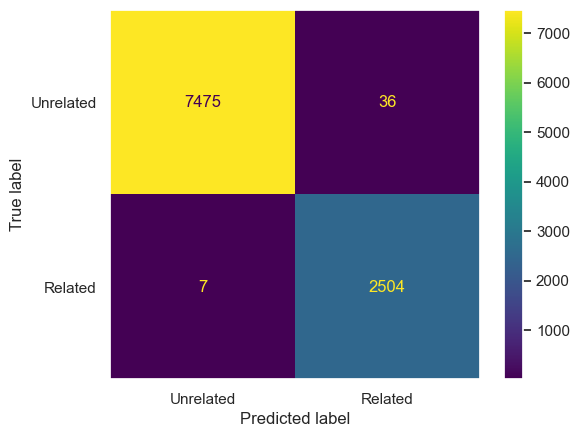

[2023-04-21 00:05:13] Classification Report:
[2023-04-21 00:05:13]               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7511
           1       0.99      1.00      0.99      2511

    accuracy                           1.00     10022
   macro avg       0.99      1.00      0.99     10022
weighted avg       1.00      1.00      1.00     10022

[2023-04-21 00:05:13] Epoch Accuracy {'accuracy': 0.9957094392336859}
[2023-04-21 00:05:13] Finished validation evaluation
[2023-04-21 00:05:13] Beat best validation loss, new validation loss: 0.01094401095630681 (surpassed 1000000000.0 from epoch -1)
[2023-04-21 00:05:15] Saved best model
[2023-04-21 00:05:15] Logged to wandb
[2023-04-21 00:05:15] Loading best model (epoch 0.01094401095630681) for evaluation
[2023-04-21 00:05:15] Starting test evaluation
[2023-04-21 00:05:15] Using model to generate predictions
[2023-04-21 00:05:15] Set model to eval mode


  0%|          | 0/3177 [00:00<?, ?it/s]

In [ ]:
model_trainer.train()

### ?

In [120]:
class BERTGRUSentiment(nn.Module):
    def __init__(self,
                 bert,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        
        super().__init__()
        
        self.bert = bert
        
        embedding_dim = bert.config.to_dict()['hidden_size']
        
        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, ids, mask):
        embedded = self.bert(input_ids=ids, attention_mask=mask)[0]
        
        # print(embedded.shape)
        
        _, hidden = self.rnn(embedded)
    
        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
        
        output = self.out(hidden)        
        
        return output

In [121]:
bert = AutoModel.from_pretrained(selected_transformer_name)
bert = bert.to(device)

model_trainer = TransformerBasedModelTrainer(
    model_class=BERTGRUSentiment,
    model_transformer=bert,
    model_freeze_transformer=False,
    model_config={
        "hidden_dim": 256,
        "output_dim": 2,
        "n_layers": 2,
        "bidirectional": True,
        "dropout": 0.25
    },
    optimiser_class=optim.AdamW,
    optimiser_config={
        "lr": 5e-5
    },
    hf_scheduler_name="linear",
    hf_scheduler_config={
        "num_warmup_steps": 0,
        "num_training_steps": 10 * (len(train_dataset) + 1) // 8
    },
    loss_class=nn.CrossEntropyLoss,
    batch_size=8,
    max_epochs=100,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    label_names=list(labels2id.keys()),
    sampling_weight_fn="inverse",
    no_improvement_epochs_stop=3,
    eval_batch_size=None,
    loss_weights=None,
    device="cuda:0"
)

loading configuration file config.json from cache at C:\Users\yoyo1/.cache\huggingface\hub\models--distilroberta-base\snapshots\d5411c3ee9e1793fd9ef58390b40a80a4c10df32\config.json
Model config RobertaConfig {
  "_name_or_path": "distilroberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file pytorch_model.bin from cache at C:\Users\yoyo1/.cache\huggingface\hub\models--distilroberta-base\snapshots\d5411c3ee9e179

Model Initialised
Model Initialised
Loss Initialised
Dataloaders Initialised
Dumped Config


[2023-04-20 13:54:33] Starting epoch 1
[2023-04-20 13:54:33] Starting epoch training
[2023-04-20 13:54:33] Set model to train mode


  0%|          | 0/4993 [00:00<?, ?it/s]

[2023-04-20 13:54:47][1:40] Loss: 0.457
[2023-04-20 13:54:59][1:80] Loss: 0.160
[2023-04-20 13:55:12][1:120] Loss: 0.138
[2023-04-20 13:55:24][1:160] Loss: 0.121
[2023-04-20 13:55:37][1:200] Loss: 0.082
[2023-04-20 13:55:49][1:240] Loss: 0.118
[2023-04-20 13:56:02][1:280] Loss: 0.087
[2023-04-20 13:56:14][1:320] Loss: 0.075
[2023-04-20 13:56:27][1:360] Loss: 0.104
[2023-04-20 13:56:39][1:400] Loss: 0.084
[2023-04-20 13:56:52][1:440] Loss: 0.104
[2023-04-20 13:57:04][1:480] Loss: 0.057
[2023-04-20 13:57:17][1:520] Loss: 0.081
[2023-04-20 13:57:29][1:560] Loss: 0.067
[2023-04-20 13:57:42][1:600] Loss: 0.059
[2023-04-20 13:57:54][1:640] Loss: 0.073
[2023-04-20 13:58:07][1:680] Loss: 0.118
[2023-04-20 13:58:19][1:720] Loss: 0.059
[2023-04-20 13:58:32][1:760] Loss: 0.109
[2023-04-20 13:58:44][1:800] Loss: 0.029
[2023-04-20 13:58:57][1:840] Loss: 0.120
[2023-04-20 13:59:09][1:880] Loss: 0.087
[2023-04-20 13:59:22][1:920] Loss: 0.060
[2023-04-20 13:59:34][1:960] Loss: 0.048
[2023-04-20 13:59:

  0%|          | 0/1253 [00:00<?, ?it/s]

[2023-04-20 14:22:44] Set model to train mode


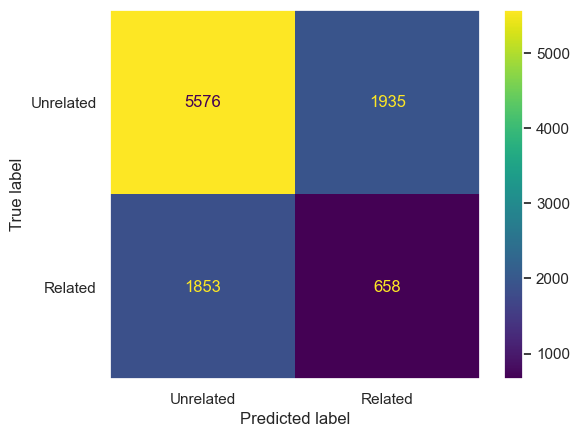

[2023-04-20 14:22:47] Classification Report:
[2023-04-20 14:22:47]               precision    recall  f1-score   support

           0       0.75      0.74      0.75      7511
           1       0.25      0.26      0.26      2511

    accuracy                           0.62     10022
   macro avg       0.50      0.50      0.50     10022
weighted avg       0.63      0.62      0.62     10022

[2023-04-20 14:22:47] Epoch Accuracy {'accuracy': 0.6220315306326083}
[2023-04-20 14:22:47] Finished validation evaluation
[2023-04-20 14:22:47] Beat best validation loss, new validation loss: 0.04426615047968525 (surpassed 1000000000.0 from epoch -1)
[2023-04-20 14:22:48] Saved best model
[2023-04-20 14:22:48] Logged to wandb
[2023-04-20 14:22:48] Starting epoch 2
[2023-04-20 14:22:48] Starting epoch training
[2023-04-20 14:22:48] Set model to train mode


  0%|          | 0/4993 [00:00<?, ?it/s]

[2023-04-20 14:23:01][2:40] Loss: 0.009
[2023-04-20 14:23:14][2:80] Loss: 0.036
[2023-04-20 14:23:26][2:120] Loss: 0.028
[2023-04-20 14:23:38][2:160] Loss: 0.014
[2023-04-20 14:23:51][2:200] Loss: 0.023
[2023-04-20 14:24:03][2:240] Loss: 0.022
[2023-04-20 14:24:16][2:280] Loss: 0.010
[2023-04-20 14:24:28][2:320] Loss: 0.005
[2023-04-20 14:24:41][2:360] Loss: 0.023
[2023-04-20 14:24:53][2:400] Loss: 0.021
[2023-04-20 14:25:05][2:440] Loss: 0.010
[2023-04-20 14:25:18][2:480] Loss: 0.015
[2023-04-20 14:25:30][2:520] Loss: 0.007
[2023-04-20 14:25:43][2:560] Loss: 0.013
[2023-04-20 14:25:55][2:600] Loss: 0.022
[2023-04-20 14:26:08][2:640] Loss: 0.008
[2023-04-20 14:26:20][2:680] Loss: 0.007
[2023-04-20 14:26:32][2:720] Loss: 0.036
[2023-04-20 14:26:45][2:760] Loss: 0.084
[2023-04-20 14:26:57][2:800] Loss: 0.079
[2023-04-20 14:27:10][2:840] Loss: 0.020
[2023-04-20 14:27:22][2:880] Loss: 0.035
[2023-04-20 14:27:35][2:920] Loss: 0.012
[2023-04-20 14:27:47][2:960] Loss: 0.035
[2023-04-20 14:27:

  0%|          | 0/1253 [00:00<?, ?it/s]

[2023-04-20 14:50:46] Set model to train mode


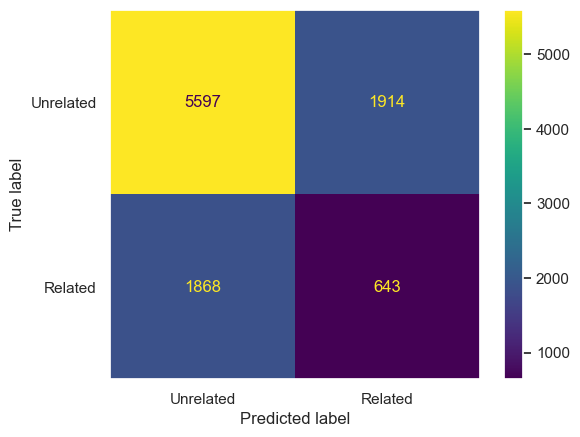

[2023-04-20 14:50:49] Classification Report:
[2023-04-20 14:50:49]               precision    recall  f1-score   support

           0       0.75      0.75      0.75      7511
           1       0.25      0.26      0.25      2511

    accuracy                           0.62     10022
   macro avg       0.50      0.50      0.50     10022
weighted avg       0.62      0.62      0.62     10022

[2023-04-20 14:50:49] Epoch Accuracy {'accuracy': 0.6226302135302335}
[2023-04-20 14:50:49] Finished validation evaluation
[2023-04-20 14:50:49] Beat best validation loss, new validation loss: 0.03288423241756623 (surpassed 0.04426615047968525 from epoch 1)
[2023-04-20 14:50:51] Saved best model
[2023-04-20 14:50:51] Logged to wandb
[2023-04-20 14:50:51] Starting epoch 3
[2023-04-20 14:50:51] Starting epoch training
[2023-04-20 14:50:51] Set model to train mode


  0%|          | 0/4993 [00:00<?, ?it/s]

[2023-04-20 14:51:04][3:40] Loss: 0.002
[2023-04-20 14:51:16][3:80] Loss: 0.015
[2023-04-20 14:51:28][3:120] Loss: 0.047
[2023-04-20 14:51:41][3:160] Loss: 0.002
[2023-04-20 14:51:53][3:200] Loss: 0.033
[2023-04-20 14:52:06][3:240] Loss: 0.015
[2023-04-20 14:52:18][3:280] Loss: 0.014
[2023-04-20 14:52:30][3:320] Loss: 0.004
[2023-04-20 14:52:43][3:360] Loss: 0.016
[2023-04-20 14:52:55][3:400] Loss: 0.012
[2023-04-20 14:53:08][3:440] Loss: 0.018
[2023-04-20 14:53:20][3:480] Loss: 0.032
[2023-04-20 14:53:32][3:520] Loss: 0.085
[2023-04-20 14:53:45][3:560] Loss: 0.051
[2023-04-20 14:53:57][3:600] Loss: 0.020
[2023-04-20 14:54:10][3:640] Loss: 0.014
[2023-04-20 14:54:22][3:680] Loss: 0.028
[2023-04-20 14:54:35][3:720] Loss: 0.002
[2023-04-20 14:54:47][3:760] Loss: 0.008
[2023-04-20 14:54:59][3:800] Loss: 0.005
[2023-04-20 14:55:12][3:840] Loss: 0.021
[2023-04-20 14:55:24][3:880] Loss: 0.017
[2023-04-20 14:55:37][3:920] Loss: 0.003
[2023-04-20 14:55:49][3:960] Loss: 0.015
[2023-04-20 14:56:

KeyboardInterrupt: 

In [122]:
model_trainer.train()

# Part 2.b: Stance Classification

## Dataset Preparation

In [229]:
labels2id = {
    "agree": 0,
    "disagree": 1,
    "discuss": 2
}

In [253]:
train_df = transformer_train_df.copy(deep=True)
val_df = transformer_val_df.copy(deep=True)
test_df = transformer_test_df.copy(deep=True)

In [254]:
train_df = train_df[train_df["Related"] == True]
val_df = val_df[val_df["Related"] == True]
test_df = test_df[test_df["Related"] == True]

In [255]:
train_labels = np.array([labels2id[x] for x in train_df["Stance"].values])
train_labels_tensor = torch.LongTensor(train_labels).unsqueeze(1)
train_labels_tensor.shape

torch.Size([10483, 1])

In [256]:
val_labels = np.array([labels2id[x] for x in val_df["Stance"].values])
val_labels_tensor = torch.LongTensor(val_labels).unsqueeze(1)
val_labels_tensor.shape

torch.Size([2944, 1])

In [257]:
test_labels = np.array([labels2id[x] for x in test_df["Stance"].values])
test_labels_tensor = torch.LongTensor(test_labels).unsqueeze(1)
test_labels_tensor.shape

torch.Size([7064, 1])

In [258]:
train_transformer_input_ids = torch.concat(list(train_df["input_ids"].values))
train_transformer_attention_masks = torch.concat(list(train_df["attention_mask"].values))
train_dataset = TransformerTokenDataset(train_transformer_input_ids, train_transformer_attention_masks, train_labels_tensor)

In [259]:
val_transformer_input_ids = torch.concat(list(val_df["input_ids"].values))
val_transformer_attention_masks = torch.concat(list(val_df["attention_mask"].values))
val_dataset = TransformerTokenDataset(val_transformer_input_ids, val_transformer_attention_masks, val_labels_tensor)

In [260]:
test_transformer_input_ids = torch.concat(list(test_df["input_ids"].values))
test_transformer_attention_masks = torch.concat(list(test_df["attention_mask"].values))
test_dataset = TransformerTokenDataset(test_transformer_input_ids, test_transformer_attention_masks, test_labels_tensor)

## Reset CUDA

In [273]:
1/0

ZeroDivisionError: division by zero

In [274]:
import gc

# model_trainer.model = None

model_trainer = None
bert = None

gc.collect()

with torch.no_grad():
    torch.cuda.empty_cache()

## Transformer CNN+GRU

In [261]:
class BERTWithCNNGRU(nn.Module):
    def __init__(self, transformer):
        super().__init__()
        
        self.transformer = transformer
        embedding_dim = transformer.config.to_dict()["hidden_size"]
        
        self.first_conv = nn.Sequential(
            nn.Conv1d(768, 512, 5, padding=2),
            nn.ReLU()
        )
        
        self.second_conv = nn.Sequential(
            nn.Conv1d(512, 256, 5, padding=2),
            nn.ReLU(),
        )
        
        self.rnn = nn.GRU(256,
                          256,
                          num_layers = 2,
                          bidirectional = True,
                          batch_first = True,
                          dropout = 0.2)
        
        self.out = nn.Linear(256 * 2, 3)
        
        self.dropout = nn.Dropout(0.2)
        
        # self.conv = nn.Conv1d(768, 384, 5, padding=2)
    
    def forward(self, ids, mask):
        embedded = self.transformer(input_ids=ids, attention_mask=mask)[0]
        
        # (b, 512, 768)
        # print("BERT Embeddings (N, L, C)", embedded.shape)
        
        embedded = embedded.permute(0, 2, 1)
        # print("Rearranged to (N, C, L)", embedded.shape)
        
        x = self.first_conv(embedded)
        # print("After Conv", x.shape)
        
        x = self.second_conv(x)
        # print("After Conv 2", x.shape)
        
        x = x.permute(0, 2, 1)
        # print("Rearranged to (N, L, C)", embedded.shape)
        
        
        _, hidden = self.rnn(x)
    
        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
        
        output = self.out(hidden)        
        
        return output
        
        # processed = processed.permute(0, 2, 1)
        # print(processed.shape)
        # embedded = embedded.permute(0, 2, 1)
        
        #x = self.layers(embedded)
        #print(x.shape)
        

In [270]:
transformer = AutoModel.from_pretrained(selected_transformer_name)
transformer = transformer.to(device)

model_trainer = TransformerBasedModelTrainer(
    model_class=BERTWithCNNGRU,
    model_transformer=transformer,
    model_freeze_transformer=True,
    model_config={},
    optimiser_class=optim.AdamW,
    optimiser_config={
        "lr": 5e-5
    },
    hf_scheduler_name="linear",
    hf_scheduler_config={
        "num_warmup_steps": 0,
        "num_training_steps": 10 * (len(train_dataset) + 1) // 8
    },
    loss_class=nn.CrossEntropyLoss,
    batch_size=8,
    max_epochs=10,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    label_names=list(labels2id.keys()),
    sampling_weight_fn=[0.25, 0.25, 0.125],
    no_improvement_epochs_stop=3,
    eval_batch_size=None,
    loss_weights=None,
    device="cuda:0"
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Transformer Frozen
Model Initialised
Model Initialised
Loss Initialised
Unique labels [0, 1, 2]
Distribution [0.25, 0.25, 0.125]
Normalised Distribution [0.4, 0.4, 0.2]
Train Data Sampler Initialised
Dataloaders Initialised
Dumped Config


[2023-04-17 18:06:04] Starting epoch 1
[2023-04-17 18:06:04] Starting epoch training
[2023-04-17 18:06:04] Set model to train mode


  0%|          | 0/1310 [00:00<?, ?it/s]

[2023-04-17 18:06:25][1:40] Loss: 1.091
[2023-04-17 18:06:35][1:80] Loss: 1.049
[2023-04-17 18:06:44][1:120] Loss: 1.019
[2023-04-17 18:06:54][1:160] Loss: 0.932
[2023-04-17 18:07:03][1:200] Loss: 0.920
[2023-04-17 18:07:13][1:240] Loss: 0.803
[2023-04-17 18:07:22][1:280] Loss: 0.883
[2023-04-17 18:07:32][1:320] Loss: 0.816
[2023-04-17 18:07:41][1:360] Loss: 0.796
[2023-04-17 18:07:51][1:400] Loss: 0.832
[2023-04-17 18:08:00][1:440] Loss: 0.798
[2023-04-17 18:08:09][1:480] Loss: 0.743
[2023-04-17 18:08:19][1:520] Loss: 0.737
[2023-04-17 18:08:28][1:560] Loss: 0.725
[2023-04-17 18:08:38][1:600] Loss: 0.711
[2023-04-17 18:08:47][1:640] Loss: 0.687
[2023-04-17 18:08:57][1:680] Loss: 0.611
[2023-04-17 18:09:06][1:720] Loss: 0.677
[2023-04-17 18:09:15][1:760] Loss: 0.652
[2023-04-17 18:09:25][1:800] Loss: 0.628
[2023-04-17 18:09:34][1:840] Loss: 0.564
[2023-04-17 18:09:43][1:880] Loss: 0.568
[2023-04-17 18:09:53][1:920] Loss: 0.634
[2023-04-17 18:10:02][1:960] Loss: 0.543
[2023-04-17 18:10:

  0%|          | 0/368 [00:00<?, ?it/s]

[2023-04-17 18:12:33] Set model to train mode


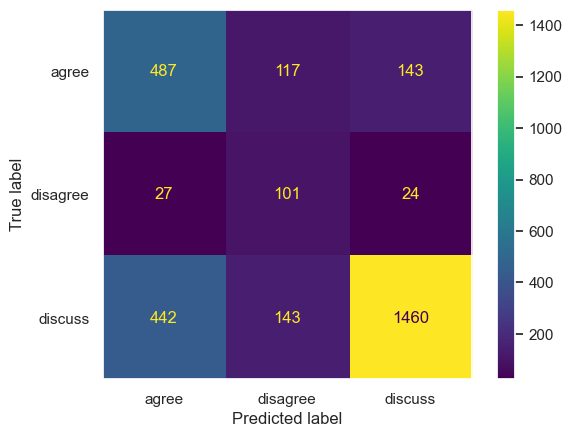

[2023-04-17 18:12:37] Classification Report:
[2023-04-17 18:12:37]               precision    recall  f1-score   support

           0       0.51      0.65      0.57       747
           1       0.28      0.66      0.39       152
           2       0.90      0.71      0.80      2045

    accuracy                           0.70      2944
   macro avg       0.56      0.68      0.59      2944
weighted avg       0.77      0.70      0.72      2944

[2023-04-17 18:12:38] Epoch Accuracy {'accuracy': 0.6956521739130435}
[2023-04-17 18:12:38] Finished validation evaluation
[2023-04-17 18:12:38] Beat best validation loss, new validation loss: 0.6939564700663575 (surpassed 1000000000.0 from epoch -1)
[2023-04-17 18:12:39] Saved best model
[2023-04-17 18:12:39] Logged to wandb
[2023-04-17 18:12:39] Starting epoch 2
[2023-04-17 18:12:39] Starting epoch training
[2023-04-17 18:12:39] Set model to train mode


  0%|          | 0/1310 [00:00<?, ?it/s]

[2023-04-17 18:12:49][2:40] Loss: 0.550
[2023-04-17 18:12:58][2:80] Loss: 0.430
[2023-04-17 18:13:07][2:120] Loss: 0.496
[2023-04-17 18:13:17][2:160] Loss: 0.547
[2023-04-17 18:13:26][2:200] Loss: 0.497
[2023-04-17 18:13:35][2:240] Loss: 0.501
[2023-04-17 18:13:44][2:280] Loss: 0.483
[2023-04-17 18:13:54][2:320] Loss: 0.489
[2023-04-17 18:14:03][2:360] Loss: 0.504
[2023-04-17 18:14:12][2:400] Loss: 0.375
[2023-04-17 18:14:22][2:440] Loss: 0.470
[2023-04-17 18:14:31][2:480] Loss: 0.408
[2023-04-17 18:14:40][2:520] Loss: 0.508
[2023-04-17 18:14:50][2:560] Loss: 0.451
[2023-04-17 18:14:59][2:600] Loss: 0.354
[2023-04-17 18:15:08][2:640] Loss: 0.399
[2023-04-17 18:15:18][2:680] Loss: 0.437
[2023-04-17 18:15:27][2:720] Loss: 0.359
[2023-04-17 18:15:36][2:760] Loss: 0.359
[2023-04-17 18:15:46][2:800] Loss: 0.445
[2023-04-17 18:15:55][2:840] Loss: 0.381
[2023-04-17 18:16:05][2:880] Loss: 0.329
[2023-04-17 18:16:14][2:920] Loss: 0.356
[2023-04-17 18:16:23][2:960] Loss: 0.447
[2023-04-17 18:16:

  0%|          | 0/368 [00:00<?, ?it/s]

[2023-04-17 18:18:55] Set model to train mode


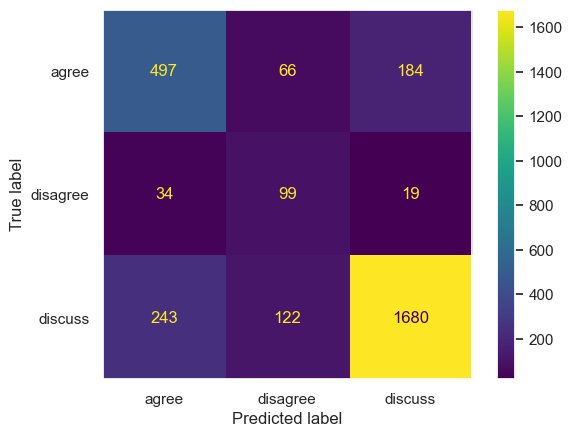

[2023-04-17 18:19:01] Classification Report:
[2023-04-17 18:19:01]               precision    recall  f1-score   support

           0       0.64      0.67      0.65       747
           1       0.34      0.65      0.45       152
           2       0.89      0.82      0.86      2045

    accuracy                           0.77      2944
   macro avg       0.63      0.71      0.65      2944
weighted avg       0.80      0.77      0.78      2944

[2023-04-17 18:19:01] Epoch Accuracy {'accuracy': 0.7730978260869565}
[2023-04-17 18:19:01] Finished validation evaluation
[2023-04-17 18:19:01] Beat best validation loss, new validation loss: 0.5542085119320647 (surpassed 0.6939564700663575 from epoch 1)
[2023-04-17 18:19:19] Saved best model
[2023-04-17 18:19:19] Logged to wandb
[2023-04-17 18:19:19] Starting epoch 3
[2023-04-17 18:19:19] Starting epoch training
[2023-04-17 18:19:19] Set model to train mode


  0%|          | 0/1310 [00:00<?, ?it/s]

[2023-04-17 18:19:28][3:40] Loss: 0.312
[2023-04-17 18:19:37][3:80] Loss: 0.314
[2023-04-17 18:19:46][3:120] Loss: 0.355
[2023-04-17 18:19:56][3:160] Loss: 0.390
[2023-04-17 18:20:05][3:200] Loss: 0.277
[2023-04-17 18:20:14][3:240] Loss: 0.295
[2023-04-17 18:20:23][3:280] Loss: 0.386
[2023-04-17 18:20:32][3:320] Loss: 0.289
[2023-04-17 18:20:42][3:360] Loss: 0.315
[2023-04-17 18:20:51][3:400] Loss: 0.325
[2023-04-17 18:21:00][3:440] Loss: 0.369
[2023-04-17 18:21:09][3:480] Loss: 0.305
[2023-04-17 18:21:18][3:520] Loss: 0.300
[2023-04-17 18:21:28][3:560] Loss: 0.269
[2023-04-17 18:21:37][3:600] Loss: 0.312
[2023-04-17 18:21:46][3:640] Loss: 0.282
[2023-04-17 18:21:55][3:680] Loss: 0.293
[2023-04-17 18:22:04][3:720] Loss: 0.232
[2023-04-17 18:22:14][3:760] Loss: 0.328
[2023-04-17 18:22:23][3:800] Loss: 0.214
[2023-04-17 18:22:32][3:840] Loss: 0.341
[2023-04-17 18:22:41][3:880] Loss: 0.274
[2023-04-17 18:22:50][3:920] Loss: 0.260
[2023-04-17 18:23:00][3:960] Loss: 0.251
[2023-04-17 18:23:

  0%|          | 0/368 [00:00<?, ?it/s]

[2023-04-17 18:25:28] Set model to train mode


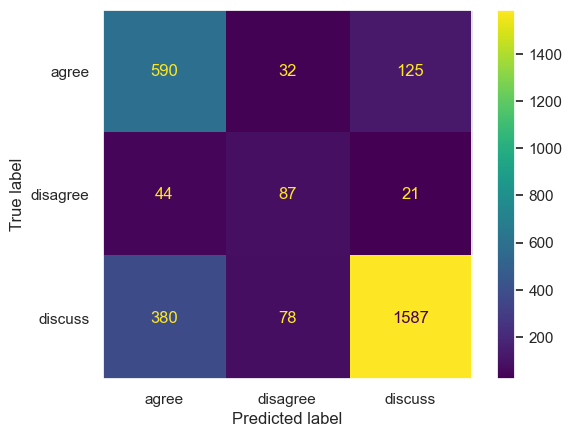

[2023-04-17 18:25:32] Classification Report:
[2023-04-17 18:25:32]               precision    recall  f1-score   support

           0       0.58      0.79      0.67       747
           1       0.44      0.57      0.50       152
           2       0.92      0.78      0.84      2045

    accuracy                           0.77      2944
   macro avg       0.65      0.71      0.67      2944
weighted avg       0.81      0.77      0.78      2944

[2023-04-17 18:25:32] Epoch Accuracy {'accuracy': 0.7690217391304348}
[2023-04-17 18:25:32] Finished validation evaluation
[2023-04-17 18:25:32] Logged to wandb
[2023-04-17 18:25:32] Starting epoch 4
[2023-04-17 18:25:32] Starting epoch training
[2023-04-17 18:25:32] Set model to train mode


  0%|          | 0/1310 [00:00<?, ?it/s]

[2023-04-17 18:25:41][4:40] Loss: 0.231
[2023-04-17 18:25:51][4:80] Loss: 0.280
[2023-04-17 18:26:00][4:120] Loss: 0.224
[2023-04-17 18:26:09][4:160] Loss: 0.245
[2023-04-17 18:26:18][4:200] Loss: 0.198
[2023-04-17 18:26:28][4:240] Loss: 0.267
[2023-04-17 18:26:37][4:280] Loss: 0.257
[2023-04-17 18:26:46][4:320] Loss: 0.248
[2023-04-17 18:26:55][4:360] Loss: 0.263
[2023-04-17 18:27:04][4:400] Loss: 0.304
[2023-04-17 18:27:14][4:440] Loss: 0.221
[2023-04-17 18:27:23][4:480] Loss: 0.205
[2023-04-17 18:27:32][4:520] Loss: 0.217
[2023-04-17 18:27:41][4:560] Loss: 0.253
[2023-04-17 18:27:50][4:600] Loss: 0.237
[2023-04-17 18:28:00][4:640] Loss: 0.157
[2023-04-17 18:28:09][4:680] Loss: 0.189
[2023-04-17 18:28:18][4:720] Loss: 0.188
[2023-04-17 18:28:27][4:760] Loss: 0.219
[2023-04-17 18:28:36][4:800] Loss: 0.227
[2023-04-17 18:28:45][4:840] Loss: 0.226
[2023-04-17 18:28:55][4:880] Loss: 0.201
[2023-04-17 18:29:04][4:920] Loss: 0.231
[2023-04-17 18:29:13][4:960] Loss: 0.185
[2023-04-17 18:29:

  0%|          | 0/368 [00:00<?, ?it/s]

[2023-04-17 18:31:42] Set model to train mode


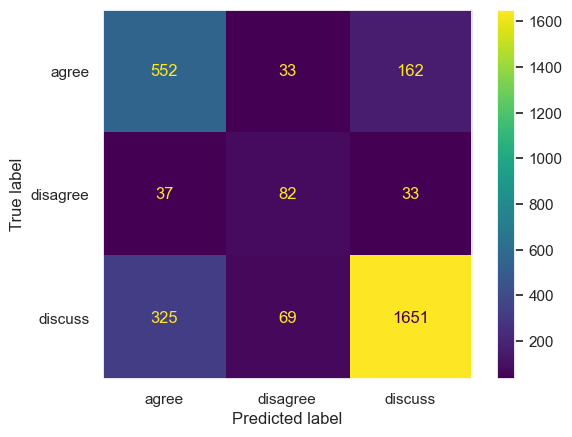

[2023-04-17 18:31:46] Classification Report:
[2023-04-17 18:31:46]               precision    recall  f1-score   support

           0       0.60      0.74      0.66       747
           1       0.45      0.54      0.49       152
           2       0.89      0.81      0.85      2045

    accuracy                           0.78      2944
   macro avg       0.65      0.70      0.67      2944
weighted avg       0.80      0.78      0.78      2944

[2023-04-17 18:31:46] Epoch Accuracy {'accuracy': 0.7761548913043478}
[2023-04-17 18:31:46] Finished validation evaluation
[2023-04-17 18:31:46] Logged to wandb
[2023-04-17 18:31:46] Starting epoch 5
[2023-04-17 18:31:46] Starting epoch training
[2023-04-17 18:31:46] Set model to train mode


  0%|          | 0/1310 [00:00<?, ?it/s]

[2023-04-17 18:31:55][5:40] Loss: 0.157
[2023-04-17 18:32:04][5:80] Loss: 0.203
[2023-04-17 18:32:14][5:120] Loss: 0.128
[2023-04-17 18:32:23][5:160] Loss: 0.193
[2023-04-17 18:32:32][5:200] Loss: 0.186
[2023-04-17 18:32:41][5:240] Loss: 0.163
[2023-04-17 18:32:51][5:280] Loss: 0.193
[2023-04-17 18:33:00][5:320] Loss: 0.145
[2023-04-17 18:33:09][5:360] Loss: 0.224
[2023-04-17 18:33:18][5:400] Loss: 0.207
[2023-04-17 18:33:27][5:440] Loss: 0.141
[2023-04-17 18:33:36][5:480] Loss: 0.159
[2023-04-17 18:33:46][5:520] Loss: 0.181
[2023-04-17 18:33:55][5:560] Loss: 0.175
[2023-04-17 18:34:04][5:600] Loss: 0.188
[2023-04-17 18:34:13][5:640] Loss: 0.225
[2023-04-17 18:34:22][5:680] Loss: 0.106
[2023-04-17 18:34:32][5:720] Loss: 0.100
[2023-04-17 18:34:41][5:760] Loss: 0.128
[2023-04-17 18:34:50][5:800] Loss: 0.125
[2023-04-17 18:34:59][5:840] Loss: 0.134
[2023-04-17 18:35:08][5:880] Loss: 0.127
[2023-04-17 18:35:17][5:920] Loss: 0.149
[2023-04-17 18:35:27][5:960] Loss: 0.144
[2023-04-17 18:35:

  0%|          | 0/368 [00:00<?, ?it/s]

[2023-04-17 18:37:55] Set model to train mode


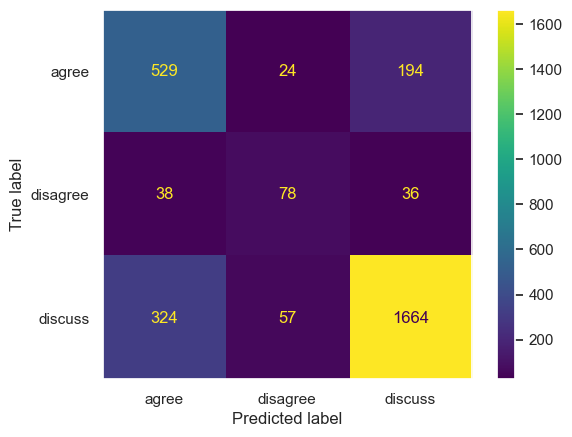

[2023-04-17 18:37:59] Classification Report:
[2023-04-17 18:37:59]               precision    recall  f1-score   support

           0       0.59      0.71      0.65       747
           1       0.49      0.51      0.50       152
           2       0.88      0.81      0.84      2045

    accuracy                           0.77      2944
   macro avg       0.65      0.68      0.66      2944
weighted avg       0.79      0.77      0.78      2944

[2023-04-17 18:37:59] Epoch Accuracy {'accuracy': 0.7713994565217391}
[2023-04-17 18:37:59] Finished validation evaluation
[2023-04-17 18:37:59] Early stopping triggered, best validation loss achieved at 2 (loss: 0.5542085119320647)
[2023-04-17 18:37:59] Loading best model (epoch 0.5542085119320647) for evaluation
[2023-04-17 18:37:59] Starting test evaluation
[2023-04-17 18:37:59] Using model to generate predictions
[2023-04-17 18:37:59] Set model to eval mode


  0%|          | 0/883 [00:00<?, ?it/s]

[2023-04-17 18:40:43] Set model to train mode


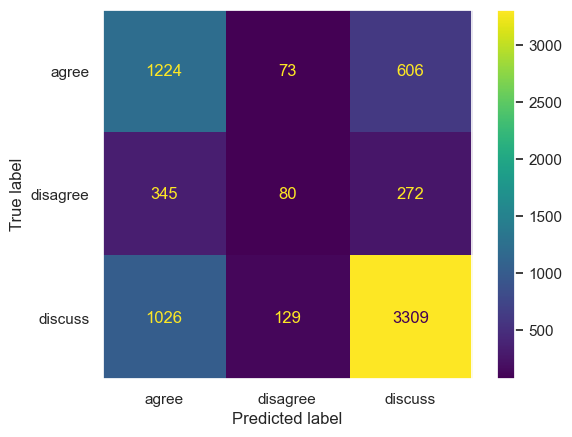

[2023-04-17 18:40:47] Classification Report:
[2023-04-17 18:40:47]               precision    recall  f1-score   support

           0       0.47      0.64      0.54      1903
           1       0.28      0.11      0.16       697
           2       0.79      0.74      0.76      4464

    accuracy                           0.65      7064
   macro avg       0.52      0.50      0.49      7064
weighted avg       0.65      0.65      0.65      7064

[2023-04-17 18:40:47] Finished test evaluation


In [263]:
model_trainer.train()

## Transformer MLP Head

In [ ]:
class TransformerWithMLPHead(nn.Module):
    def __init__(self, transformer, hidden_layers, hidden_dim, output_dim, dropout_prob):
        super().__init__()
        
        self.transformer = transformer
        embedding_dim = bert.config.to_dict()['hidden_size']
        
        if hidden_layers == 0:
            hidden_dim = [embedding_dim]
        else:
            if type(hidden_dim) is int:
                hidden_dim = [embedding_dim] + [hidden_dim] * hidden_layers
            else:
                hidden_dim = [embedding_dim] + hidden_dim
        
        layers = []
        
        for i in range(hidden_layers):
            layers += [
                nn.Linear(hidden_dim[i], hidden_dim[i + 1]),
                nn.Dropout(dropout_prob)
            ]
            
        if hidden_layers == 0:
            layers.append(nn.Dropout(dropout_prob))
        
        layers.append(nn.Linear(hidden_dim[-1], output_dim))
        
        self.head = nn.Sequential(*layers)
        
    def forward(self, input_ids, mask):
        with torch.no_grad():
            transformer_embeddings = self.transformer(input_ids, attention_mask=mask)[0][:, 0, :]
        
        output = self.head(transformer_embeddings)
        return output

In [ ]:
transformer = AutoModel.from_pretrained(selected_transformer_name)
transformer = transformer.to(device)

model_trainer = TransformerBasedModelTrainer(
    model_class=TransformerWithMLPHead,
    model_transformer=transformer,
    model_freeze_transformer=False,
    model_config={
        "hidden_layers": 0,
        "hidden_dim": [],
        "output_dim": 3,
        "dropout_prob": 0.2
    },
    optimiser_class=optim.AdamW,
    optimiser_config={
        "lr": 5e-5
    },
    hf_scheduler_name="linear",
    hf_scheduler_config={
        "num_warmup_steps": 0,
        "num_training_steps": 10 * (len(train_dataset) + 1) // 8
    },
    loss_class=nn.CrossEntropyLoss,
    batch_size=8,
    max_epochs=100,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    label_names=list(labels2id.keys()),
    sampling_weight_fn=None,
    no_improvement_epochs_stop=3,
    eval_batch_size=None,
    loss_weights=None,
    device="cuda:0"
)

In [ ]:
model_trainer.train()

## Transformer RNN

In [301]:
class TransformerRNN(nn.Module):
    def __init__(self, transformer, rnn_type, stacked_layers, hidden_dim, output_dim, bidirectional, dropout_prob):
        super().__init__()
        
        self.transformer = transformer
        embedding_dim = transformer.config.to_dict()["hidden_size"]
        
        rnn_class = None
        
        if rnn_type.lower() == "lstm":
            rnn_class = nn.LSTM
        elif rnn_type.lower() == "gru":
            rnn_class = nn.GRU
        else:
            assert 1 == 0, "Invalid RNN type"
        
        self.rnn_type = rnn_type
        self.rnn = rnn_class(embedding_dim, hidden_dim, num_layers=stacked_layers, bidirectional=bidirectional, batch_first=True, dropout=dropout_prob)
        self.classifier = nn.Linear(hidden_dim * (1 + bidirectional), output_dim)
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, ids, mask):
        embeddings = self.transformer(input_ids=ids, attention_mask=mask)[0]
        
        if self.rnn_type == "gru":
            _, hidden_state = self.rnn(embeddings)
        else:
            _, (hidden_state, _) = self.rnn(embeddings)
        
        if self.rnn.bidirectional:
            hidden_state = self.dropout(torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim=1))
        else:
            hidden_state = self.dropout(hidden_state[-1,:,:])
        
        return self.classifier(hidden_state)

In [304]:
transformer = AutoModel.from_pretrained(selected_transformer_name)
transformer = transformer.to(device)

model_trainer = TransformerBasedModelTrainer(
    model_class=TransformerRNN,
    model_transformer=transformer,
    model_freeze_transformer=True,
    model_config={
        "rnn_type": "lstm",
        "stacked_layers": 2,
        "hidden_dim": 256,
        "output_dim": 3,
        "dropout_prob": 0.2,
        "bidirectional": True,
        "dropout_prob": 0.15
    },
    optimiser_class=optim.AdamW,
    optimiser_config={
        "lr": 5e-5
    },
    hf_scheduler_name="linear",
    hf_scheduler_config={
        "num_warmup_steps": 0,
        "num_training_steps": 10 * (len(train_dataset) + 1) // 8
    },
    loss_class=nn.CrossEntropyLoss,
    batch_size=8,
    max_epochs=10,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    label_names=list(labels2id.keys()),
    sampling_weight_fn=[0.25, 0.5, 0.15],
    no_improvement_epochs_stop=3,
    eval_batch_size=None,
    loss_weights=None,
    device="cuda:0"
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Transformer Frozen
Model Initialised
Model Initialised
Loss Initialised
Unique labels [0, 1, 2]
Distribution [0.25, 0.5, 0.15]
Normalised Distribution [0.2777777777777778, 0.5555555555555556, 0.16666666666666666]
Train Data Sampler Initialised
Dataloaders Initialised
Dumped Config


[2023-04-17 21:50:39] Starting epoch 1
[2023-04-17 21:50:39] Starting epoch training
[2023-04-17 21:50:39] Set model to train mode


  0%|          | 0/1310 [00:00<?, ?it/s]

[2023-04-17 21:50:48][1:40] Loss: 1.049
[2023-04-17 21:50:58][1:80] Loss: 0.939
[2023-04-17 21:51:07][1:120] Loss: 0.949
[2023-04-17 21:51:17][1:160] Loss: 0.932
[2023-04-17 21:51:27][1:200] Loss: 0.901
[2023-04-17 21:51:36][1:240] Loss: 0.888
[2023-04-17 21:51:46][1:280] Loss: 0.790
[2023-04-17 21:51:55][1:320] Loss: 0.827
[2023-04-17 21:52:05][1:360] Loss: 0.766
[2023-04-17 21:52:14][1:400] Loss: 0.716
[2023-04-17 21:52:24][1:440] Loss: 0.673
[2023-04-17 21:52:33][1:480] Loss: 0.819
[2023-04-17 21:52:43][1:520] Loss: 0.740
[2023-04-17 21:52:52][1:560] Loss: 0.688
[2023-04-17 21:53:02][1:600] Loss: 0.685
[2023-04-17 21:53:11][1:640] Loss: 0.750
[2023-04-17 21:53:21][1:680] Loss: 0.676
[2023-04-17 21:53:30][1:720] Loss: 0.651
[2023-04-17 21:53:40][1:760] Loss: 0.674
[2023-04-17 21:53:50][1:800] Loss: 0.630
[2023-04-17 21:53:59][1:840] Loss: 0.557
[2023-04-17 21:54:09][1:880] Loss: 0.648
[2023-04-17 21:54:18][1:920] Loss: 0.615
[2023-04-17 21:54:28][1:960] Loss: 0.584
[2023-04-17 21:54:

  0%|          | 0/368 [00:00<?, ?it/s]

[2023-04-17 21:57:00] Set model to train mode


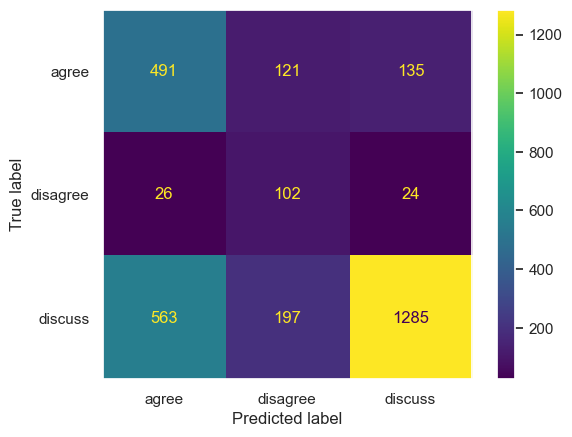

[2023-04-17 21:57:04] Classification Report:
[2023-04-17 21:57:04]               precision    recall  f1-score   support

           0       0.45      0.66      0.54       747
           1       0.24      0.67      0.36       152
           2       0.89      0.63      0.74      2045

    accuracy                           0.64      2944
   macro avg       0.53      0.65      0.54      2944
weighted avg       0.75      0.64      0.67      2944

[2023-04-17 21:57:04] Epoch Accuracy {'accuracy': 0.6379076086956522}
[2023-04-17 21:57:04] Finished validation evaluation
[2023-04-17 21:57:04] Beat best validation loss, new validation loss: 0.7919521754526574 (surpassed 1000000000.0 from epoch -1)
[2023-04-17 21:57:06] Saved best model
[2023-04-17 21:57:06] Logged to wandb
[2023-04-17 21:57:06] Starting epoch 2
[2023-04-17 21:57:06] Starting epoch training
[2023-04-17 21:57:06] Set model to train mode


  0%|          | 0/1310 [00:00<?, ?it/s]

[2023-04-17 21:57:16][2:40] Loss: 0.452
[2023-04-17 21:57:25][2:80] Loss: 0.516
[2023-04-17 21:57:34][2:120] Loss: 0.459
[2023-04-17 21:57:44][2:160] Loss: 0.453
[2023-04-17 21:57:53][2:200] Loss: 0.454
[2023-04-17 21:58:03][2:240] Loss: 0.448
[2023-04-17 21:58:12][2:280] Loss: 0.426
[2023-04-17 21:58:22][2:320] Loss: 0.425
[2023-04-17 21:58:31][2:360] Loss: 0.425
[2023-04-17 21:58:41][2:400] Loss: 0.390
[2023-04-17 21:58:50][2:440] Loss: 0.481
[2023-04-17 21:59:00][2:480] Loss: 0.390
[2023-04-17 21:59:09][2:520] Loss: 0.392
[2023-04-17 21:59:19][2:560] Loss: 0.495
[2023-04-17 21:59:28][2:600] Loss: 0.390
[2023-04-17 21:59:38][2:640] Loss: 0.497
[2023-04-17 21:59:47][2:680] Loss: 0.400
[2023-04-17 21:59:56][2:720] Loss: 0.376
[2023-04-17 22:00:06][2:760] Loss: 0.372
[2023-04-17 22:00:15][2:800] Loss: 0.347
[2023-04-17 22:00:25][2:840] Loss: 0.432
[2023-04-17 22:00:34][2:880] Loss: 0.361
[2023-04-17 22:00:44][2:920] Loss: 0.368
[2023-04-17 22:00:53][2:960] Loss: 0.354
[2023-04-17 22:01:

  0%|          | 0/368 [00:00<?, ?it/s]

[2023-04-17 22:03:25] Set model to train mode


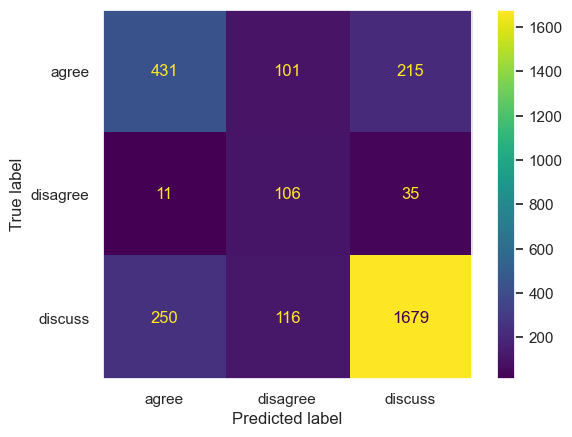

[2023-04-17 22:03:29] Classification Report:
[2023-04-17 22:03:29]               precision    recall  f1-score   support

           0       0.62      0.58      0.60       747
           1       0.33      0.70      0.45       152
           2       0.87      0.82      0.84      2045

    accuracy                           0.75      2944
   macro avg       0.61      0.70      0.63      2944
weighted avg       0.78      0.75      0.76      2944

[2023-04-17 22:03:29] Epoch Accuracy {'accuracy': 0.7527173913043478}
[2023-04-17 22:03:29] Finished validation evaluation
[2023-04-17 22:03:29] Beat best validation loss, new validation loss: 0.6127809498398362 (surpassed 0.7919521754526574 from epoch 1)
[2023-04-17 22:03:31] Saved best model
[2023-04-17 22:03:31] Logged to wandb
[2023-04-17 22:03:31] Starting epoch 3
[2023-04-17 22:03:31] Starting epoch training
[2023-04-17 22:03:31] Set model to train mode


  0%|          | 0/1310 [00:00<?, ?it/s]

[2023-04-17 22:03:41][3:40] Loss: 0.461
[2023-04-17 22:03:50][3:80] Loss: 0.317
[2023-04-17 22:03:59][3:120] Loss: 0.360
[2023-04-17 22:04:09][3:160] Loss: 0.311
[2023-04-17 22:04:18][3:200] Loss: 0.337
[2023-04-17 22:04:28][3:240] Loss: 0.349
[2023-04-17 22:04:37][3:280] Loss: 0.333
[2023-04-17 22:04:47][3:320] Loss: 0.323
[2023-04-17 22:04:56][3:360] Loss: 0.340
[2023-04-17 22:05:06][3:400] Loss: 0.297
[2023-04-17 22:05:15][3:440] Loss: 0.356
[2023-04-17 22:05:25][3:480] Loss: 0.375
[2023-04-17 22:05:34][3:520] Loss: 0.354
[2023-04-17 22:05:44][3:560] Loss: 0.305
[2023-04-17 22:05:53][3:600] Loss: 0.372
[2023-04-17 22:06:03][3:640] Loss: 0.334
[2023-04-17 22:06:12][3:680] Loss: 0.345
[2023-04-17 22:06:21][3:720] Loss: 0.277
[2023-04-17 22:06:31][3:760] Loss: 0.363
[2023-04-17 22:06:40][3:800] Loss: 0.340
[2023-04-17 22:06:50][3:840] Loss: 0.370
[2023-04-17 22:06:59][3:880] Loss: 0.302
[2023-04-17 22:07:09][3:920] Loss: 0.365
[2023-04-17 22:07:18][3:960] Loss: 0.323
[2023-04-17 22:07:

  0%|          | 0/368 [00:00<?, ?it/s]

[2023-04-17 22:09:50] Set model to train mode


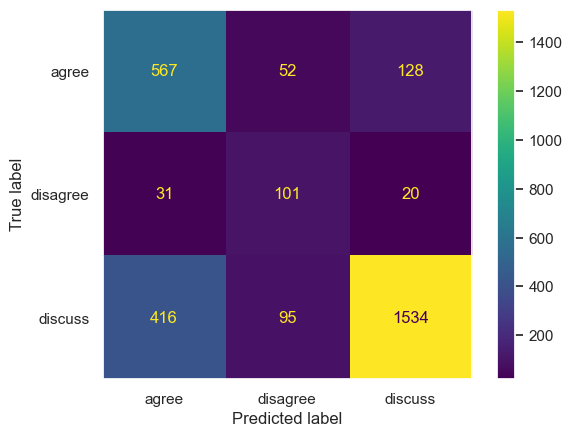

[2023-04-17 22:09:54] Classification Report:
[2023-04-17 22:09:54]               precision    recall  f1-score   support

           0       0.56      0.76      0.64       747
           1       0.41      0.66      0.51       152
           2       0.91      0.75      0.82      2045

    accuracy                           0.75      2944
   macro avg       0.63      0.72      0.66      2944
weighted avg       0.80      0.75      0.76      2944

[2023-04-17 22:09:54] Epoch Accuracy {'accuracy': 0.7479619565217391}
[2023-04-17 22:09:54] Finished validation evaluation
[2023-04-17 22:09:54] Logged to wandb
[2023-04-17 22:09:54] Starting epoch 4
[2023-04-17 22:09:54] Starting epoch training
[2023-04-17 22:09:54] Set model to train mode


  0%|          | 0/1310 [00:00<?, ?it/s]

[2023-04-17 22:10:03][4:40] Loss: 0.313
[2023-04-17 22:10:13][4:80] Loss: 0.256
[2023-04-17 22:10:22][4:120] Loss: 0.308
[2023-04-17 22:10:32][4:160] Loss: 0.250
[2023-04-17 22:10:41][4:200] Loss: 0.277
[2023-04-17 22:10:51][4:240] Loss: 0.292
[2023-04-17 22:11:00][4:280] Loss: 0.399
[2023-04-17 22:11:10][4:320] Loss: 0.247
[2023-04-17 22:11:19][4:360] Loss: 0.222
[2023-04-17 22:11:28][4:400] Loss: 0.205
[2023-04-17 22:11:38][4:440] Loss: 0.275
[2023-04-17 22:11:47][4:480] Loss: 0.349
[2023-04-17 22:11:57][4:520] Loss: 0.314
[2023-04-17 22:12:06][4:560] Loss: 0.302
[2023-04-17 22:12:16][4:600] Loss: 0.303
[2023-04-17 22:12:25][4:640] Loss: 0.245
[2023-04-17 22:12:35][4:680] Loss: 0.205
[2023-04-17 22:12:44][4:720] Loss: 0.254
[2023-04-17 22:12:53][4:760] Loss: 0.263
[2023-04-17 22:13:03][4:800] Loss: 0.306
[2023-04-17 22:13:12][4:840] Loss: 0.276
[2023-04-17 22:13:22][4:880] Loss: 0.327
[2023-04-17 22:13:31][4:920] Loss: 0.258
[2023-04-17 22:13:41][4:960] Loss: 0.260
[2023-04-17 22:13:

  0%|          | 0/368 [00:00<?, ?it/s]

[2023-04-17 22:16:12] Set model to train mode


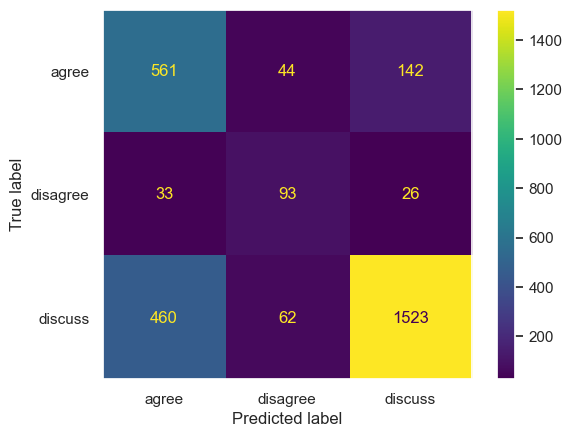

[2023-04-17 22:16:16] Classification Report:
[2023-04-17 22:16:16]               precision    recall  f1-score   support

           0       0.53      0.75      0.62       747
           1       0.47      0.61      0.53       152
           2       0.90      0.74      0.82      2045

    accuracy                           0.74      2944
   macro avg       0.63      0.70      0.66      2944
weighted avg       0.78      0.74      0.75      2944

[2023-04-17 22:16:16] Epoch Accuracy {'accuracy': 0.7394701086956522}
[2023-04-17 22:16:16] Finished validation evaluation
[2023-04-17 22:16:16] Logged to wandb
[2023-04-17 22:16:16] Starting epoch 5
[2023-04-17 22:16:16] Starting epoch training
[2023-04-17 22:16:16] Set model to train mode


  0%|          | 0/1310 [00:00<?, ?it/s]

[2023-04-17 22:16:26][5:40] Loss: 0.247
[2023-04-17 22:16:35][5:80] Loss: 0.261
[2023-04-17 22:16:45][5:120] Loss: 0.176
[2023-04-17 22:16:54][5:160] Loss: 0.200
[2023-04-17 22:17:04][5:200] Loss: 0.223
[2023-04-17 22:17:13][5:240] Loss: 0.161
[2023-04-17 22:17:23][5:280] Loss: 0.275
[2023-04-17 22:17:32][5:320] Loss: 0.198
[2023-04-17 22:17:41][5:360] Loss: 0.267
[2023-04-17 22:17:51][5:400] Loss: 0.178
[2023-04-17 22:18:00][5:440] Loss: 0.188
[2023-04-17 22:18:10][5:480] Loss: 0.227
[2023-04-17 22:18:19][5:520] Loss: 0.222
[2023-04-17 22:18:29][5:560] Loss: 0.195
[2023-04-17 22:18:38][5:600] Loss: 0.202
[2023-04-17 22:18:48][5:640] Loss: 0.235
[2023-04-17 22:18:57][5:680] Loss: 0.147
[2023-04-17 22:19:07][5:720] Loss: 0.254
[2023-04-17 22:19:16][5:760] Loss: 0.187
[2023-04-17 22:19:26][5:800] Loss: 0.141
[2023-04-17 22:19:35][5:840] Loss: 0.199
[2023-04-17 22:19:45][5:880] Loss: 0.169
[2023-04-17 22:19:54][5:920] Loss: 0.209
[2023-04-17 22:20:04][5:960] Loss: 0.152
[2023-04-17 22:20:

  0%|          | 0/368 [00:00<?, ?it/s]

[2023-04-17 22:22:38] Set model to train mode


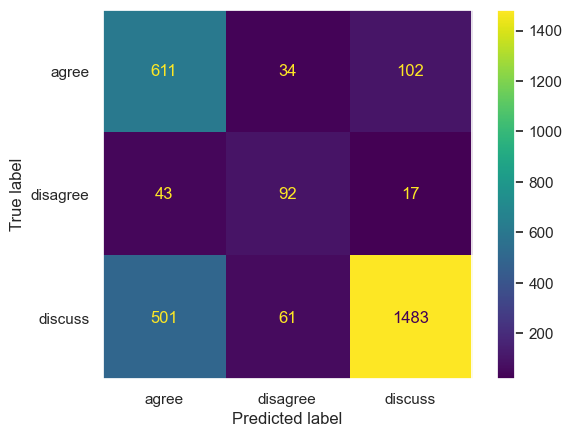

[2023-04-17 22:22:42] Classification Report:
[2023-04-17 22:22:42]               precision    recall  f1-score   support

           0       0.53      0.82      0.64       747
           1       0.49      0.61      0.54       152
           2       0.93      0.73      0.81      2045

    accuracy                           0.74      2944
   macro avg       0.65      0.72      0.67      2944
weighted avg       0.80      0.74      0.76      2944

[2023-04-17 22:22:42] Epoch Accuracy {'accuracy': 0.7425271739130435}
[2023-04-17 22:22:42] Finished validation evaluation
[2023-04-17 22:22:42] Early stopping triggered, best validation loss achieved at 2 (loss: 0.6127809498398362)
[2023-04-17 22:22:42] Loading best model (epoch 0.6127809498398362) for evaluation
[2023-04-17 22:22:42] Starting test evaluation
[2023-04-17 22:22:42] Using model to generate predictions
[2023-04-17 22:22:42] Set model to eval mode


  0%|          | 0/883 [00:00<?, ?it/s]

[2023-04-17 22:25:28] Set model to train mode


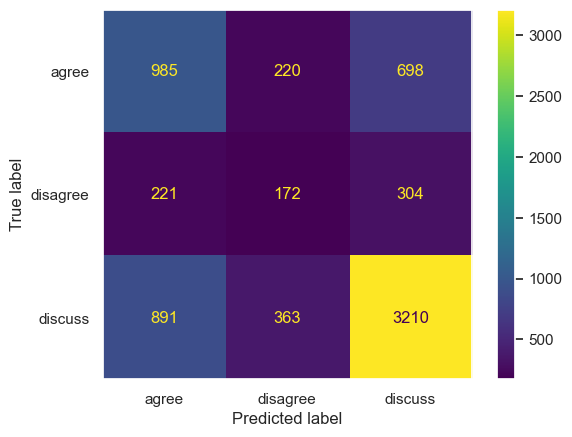

[2023-04-17 22:25:32] Classification Report:
[2023-04-17 22:25:32]               precision    recall  f1-score   support

           0       0.47      0.52      0.49      1903
           1       0.23      0.25      0.24       697
           2       0.76      0.72      0.74      4464

    accuracy                           0.62      7064
   macro avg       0.49      0.49      0.49      7064
weighted avg       0.63      0.62      0.62      7064

[2023-04-17 22:25:32] Finished test evaluation


In [305]:
model_trainer.train()

## Transformer CNN

# Part 2.c: End-to-End Testing